# Apply AI Superresolution to video - Train New Network from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long - complete
- set kernel range from 1 to 20 - vs 4-20 need lower range too - complete
- combination of hi res perceptual and mse on smoothed versions of input.- complete
- give more emphasis to mse

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up
- better model and apply to all 3 colors - tried, but no improvement.
- try vgg perception metric
- focus prediction


RCAN Results
- Uses lots of resources as scale of image increases
- Does not handle different scales well
- not meant for restoration - 
To try
- Apply pretrained model on a patch thats 48x48 then can judge if its worth making an approach to apply repeatedly to larger images.
- train vdsr with a convolutional upscaling up front, attention, residuals.

UNET results
- Some sharpening but not drastic.  Not better than VDSR
- Used 2x GPU mem than VDSR

New Network results
- Performs as well as VDSR qualitatively, need to check.
- using Div2K gives better results (needs low learning rate)
- try with L1 norm (less noise sensitive)
- add upscale in the middle to allow more flexibility - nn.ConvTranspose2d(in_channels=C, out_channels=M, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
- add  with torch.no_grad():  to validation and prediction with the model to speed up computations.


To Try
- UNET or VDSR with MAXout nonlinear function.  Try different activation functions (mish,etc).
- consistency error measure like fastai superres
- provide input,target  pairs with no fuzziness in the training set.
- Train exclusively on very sharp  images (DIV2K)
- Predict focus as a segmentation in addition to enhancing
- have 3 channel inputs (RGB or ??) and then have 1 channel output
- provide frame-1,frame,frame+1 to predict frame
- opposite of bottleneck - input resolution -> high res -> input res blocks.
- combo of UNET and VDSR
- attention?
- combo of perception and mse measure
- add validation set
- sort dataset into hard cases and easy cases, making cases harder with time.  (train on easy cases first, then fine tune with harder cases)
- make the camera model version of the data loader
- use mse but give more error to perception
- try reflection padding







## Share results
- put out an example on youtube to allow comparison


# Project Documentation

In [1]:

from pathlib import Path
import os


project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"

model_name_base = "NEWCNN4"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train New Network upscale PRelu L1 Div2 camspec training-Copy1.ipynb


In [4]:
nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder , nb_path.stem )
print(result_path)
os.makedirs(result_path, exist_ok=True)

/SSD_link/superres/Superresolution train New Network upscale PRelu L1 Div2 camspec training-Copy1.ipynb
/media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 camspec training-Copy1


In [5]:
model_out_path=Path(project_base)/model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/superres/checkpoint


In [6]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [7]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale,ToPILImage

import random

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [8]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers

torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [9]:
import fnmatch

In [10]:
from superres_utils import make_framelist, load_frame, RescaleCrop, Multifuz, DatasetFromVideoFolder
from superres_utils import show_batch
from superres_utils import pil_disk_blur, display_PSNR, test_results, superres_mp4

In [11]:
# get a list of all the data
instances = make_framelist("/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR",1)

(731, 491) (720, 480)


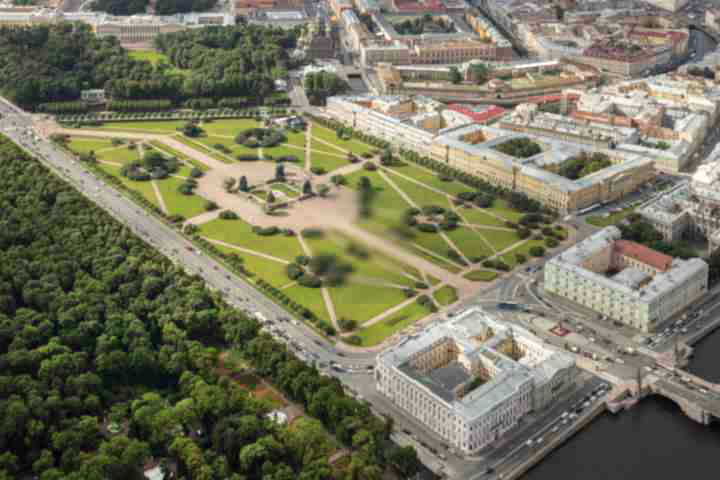

In [12]:
#test the Multifuz transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
im = RescaleCrop(crop_size=(480,720),kernel_width=10)(im)
im_res = Multifuz(crop_size = (480,720),
                  center=(360,240),
                  kernel_a=2, 
                  kernel_b=10,
                  quality=np.int16(22), 
                  slope=.1,
                 radius=50,
                 scale=1)(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [13]:
def input_transform():        
    return Compose([        
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])


In [14]:
train_dir = "/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR"
#train_dir = "/home/filip/SSD_link/superres/video_data/train_data"
frame_sample_size =10
batch_size = 4 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
#crop_size = (256,256)
kernel_range=(1,16)
quality_range=(30,90) 
slope_range=(0.001, 0.1)
radius_range=(0,0)  # make all one fuzziness
scale_range=(1/2,2)
Flip_hor=True
Rand_bright_contrast=True

In [15]:
train_set = DatasetFromVideoFolder(train_dir,crop_size,frame_sample_size,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   max_kernel=10
                            )
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

In [16]:
valid_dir = "/home/filip/SSD_link/superres/DIV2K/DIV2K_valid_HR"
#frame_sample_size =10
#batch_size = 4 # Make 4 For FP16, 480x720 size images
#crop_size = (480,720)

kernel_range=(1,16)
quality_range=(30,99) 
slope_range=(0.001, 0.1)
radius_range=(0,0)  # make all one fuzziness
scale_range=(1/2,2)
Flip_hor=False
Rand_bright_contrast=False
match_exp = "*.*"

In [17]:
valid_set = DatasetFromVideoFolder(valid_dir,crop_size,frame_sample_size,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   max_kernel=10,
                                   match_exp=match_exp,
                            )
valid_data_loader = DataLoader(dataset=valid_set, num_workers=0, batch_size=batch_size, shuffle=False)

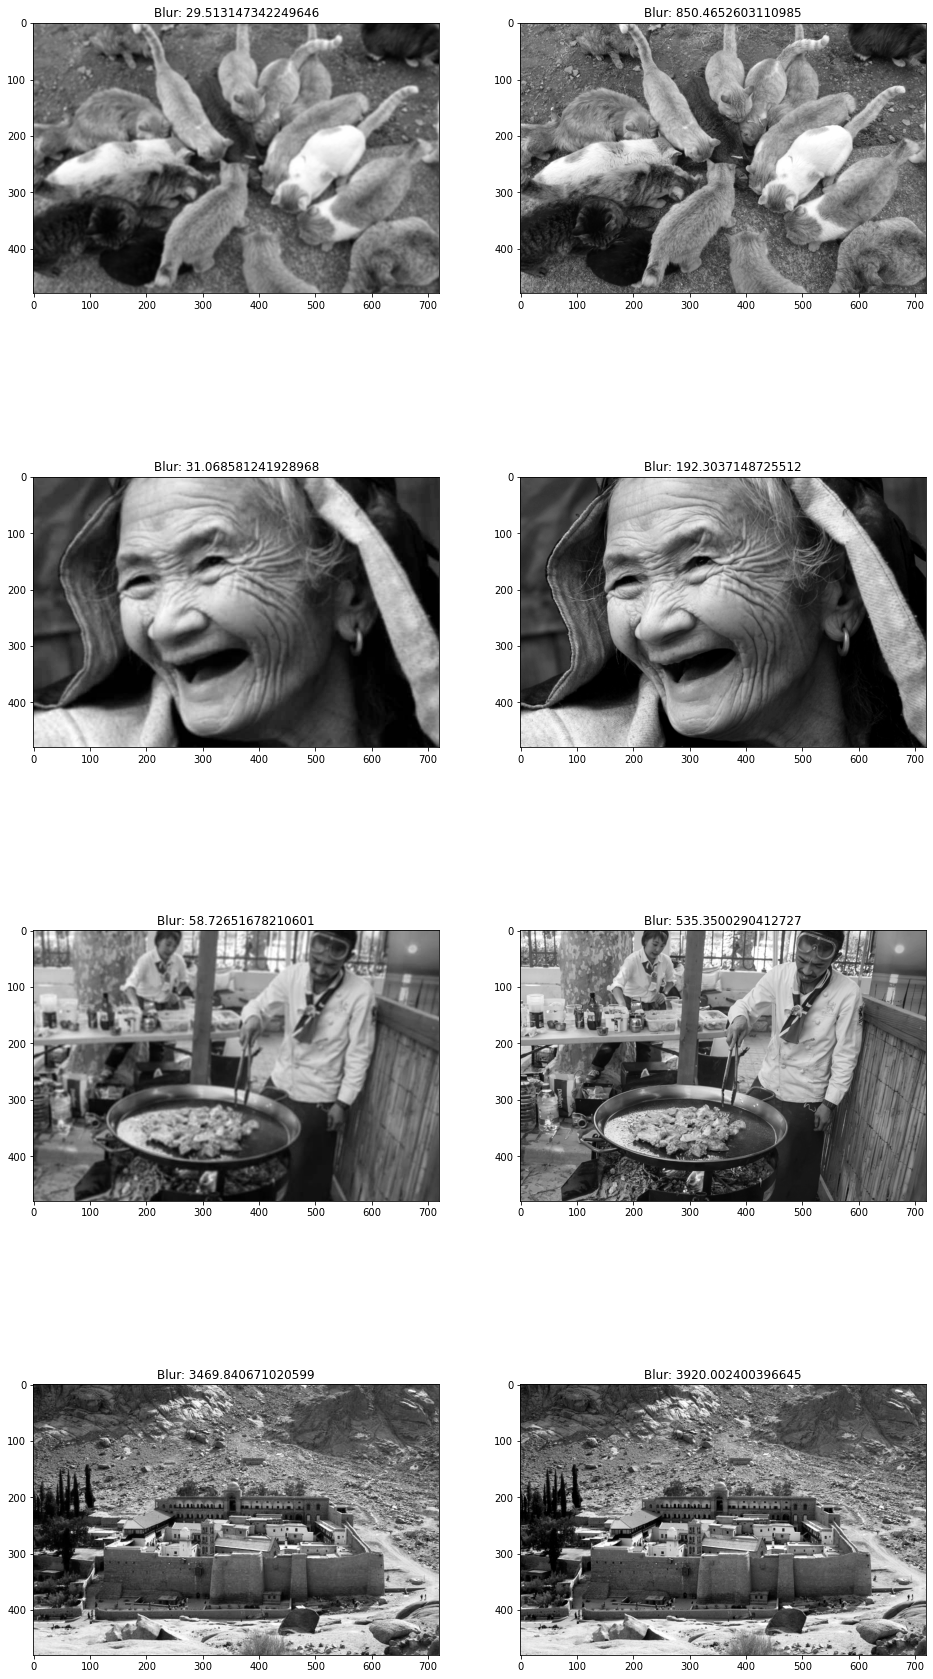

In [18]:
show_batch(training_data_loader,size =8)

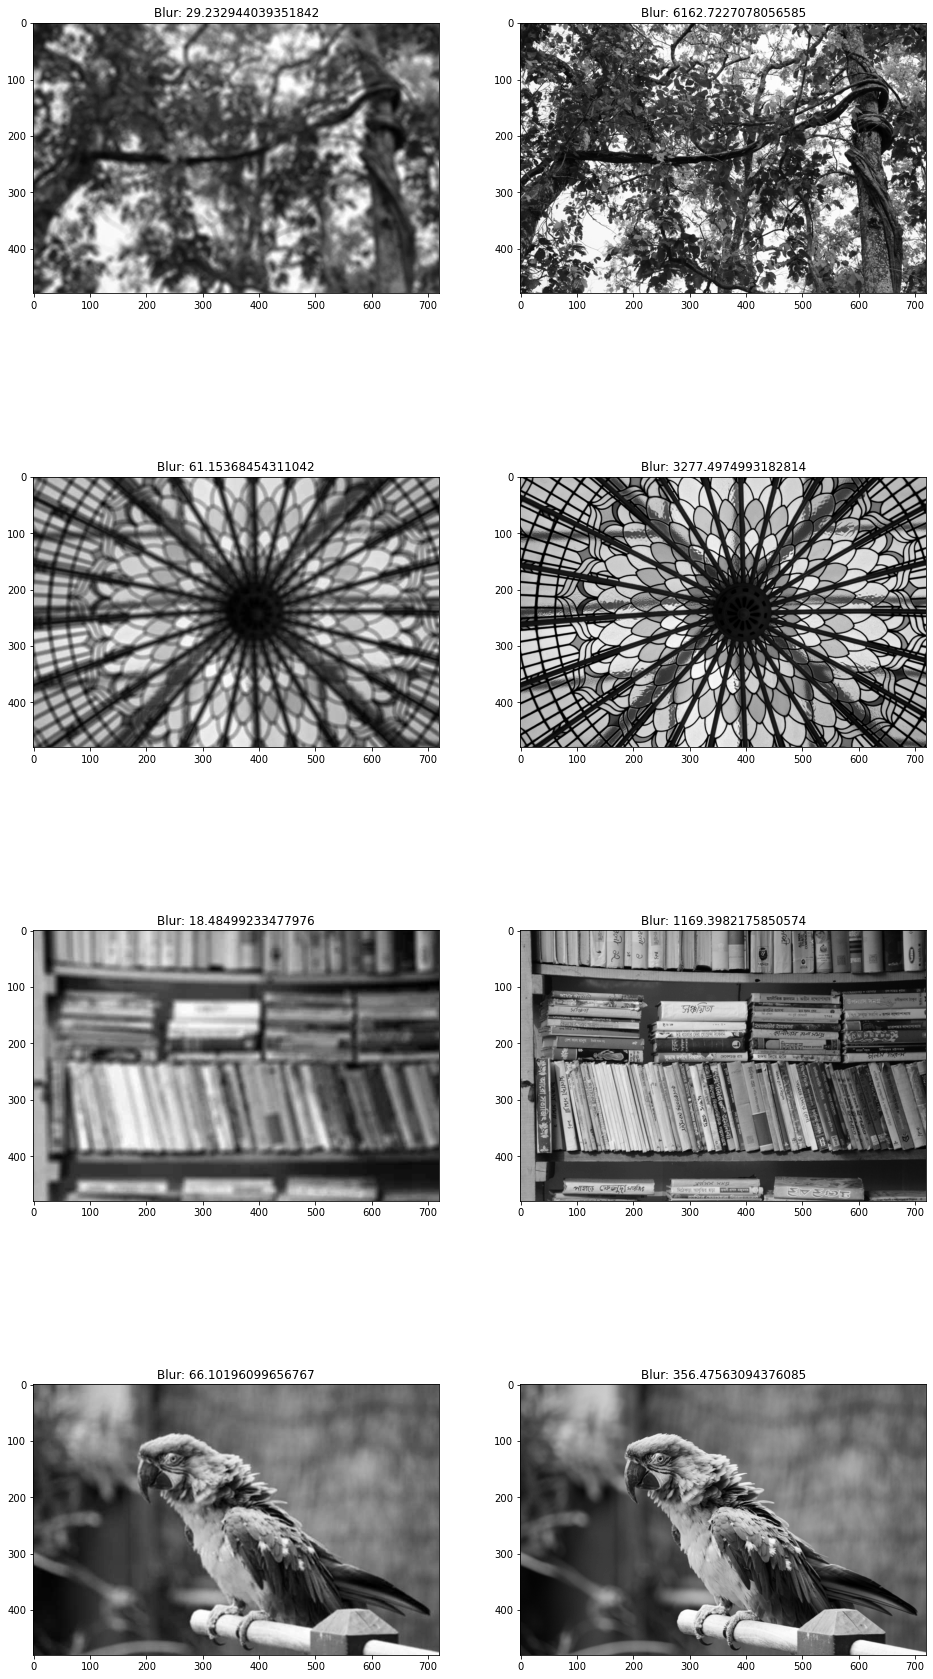

In [19]:
show_batch(valid_data_loader,size =8)

# NEW CNN

In [11]:
import torch.nn as nn

class NEWNet3(nn.Module):
    def __init__(self, c1, c2, c3):
        super(NEWNet3, self).__init__()   
        
        self.p1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PReLU(),
            nn.Conv2d(in_channels=c1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.PReLU(),
            nn.Conv2d(in_channels=c1, out_channels=c1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.PReLU()
        )
        
        self.p2 = nn.Sequential(
            nn.Conv2d(in_channels=c1, out_channels=c2, kernel_size=1, stride=1, padding=0, bias=True),
            nn.PReLU(),
            nn.Conv2d(in_channels=c2, out_channels=c2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.PReLU(),
            nn.Conv2d(in_channels=c2, out_channels=c1, kernel_size=1, stride=1, padding=0, bias=True)
        )
        
        

        
        self.prelu = nn.PReLU()
        self.convf = nn.Conv2d(in_channels=c1, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.features = nn.Sequential(
            
            nn.Conv2d(c1, c1, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(c1, c1, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.regression = nn.Sequential(
            nn.Dropout(),
            nn.Linear(c1 * 6 * 6, c3),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(c3, c3),
            nn.ReLU(inplace=True),
            nn.Linear(c3, 1),
        )

              
        
        
    def forward(self, x):    
        residual = x
        x = self.p1(x)
        skip1 = x
        
        k = self.features(x)
        k = self.avgpool(k)
        k = torch.flatten(k, 1)
        k = self.regression(k)
        
        
        x = self.p2(x)
        x = x.add_(skip1)
        x = self.prelu(x)
        x = self.convf(x)
        out = torch.add(x,residual)
        return out, k

# build the model

In [21]:
#model = NEWNet2(c1=64,c2=128)
model = NEWNet3(c1=64,c2=64, c3=1024)
model.cuda()

NEWNet3(
  (p1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): PReLU(num_parameters=1)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): PReLU(num_parameters=1)
  )
  (p2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (prelu): PReLU(num_parameters=1)
  (convf): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4

In [ ]:
num_pixels = crop_size[0] * crop_size[1]

In [ ]:
def loss_scaler(im):
    # scale to -1,1 and convert to 3 channel (greyscale to RBG)
    return (im * 2 - 1).expand(-1, 3, -1, -1)

In [ ]:
class Pixel_Loss(torch.nn.Module):
    
    def __init__(self,num_pixels):
        super(Pixel_Loss,self).__init__()
        self.lossfn = nn.MSELoss(reduction = 'mean')
        
        self.percep_loss_fn = lpips.LPIPS(net='alex').cuda()


        self.num_pixels = num_pixels
    #def forward(self,x,y):
        
     #   return self.num_pixels*(self.lossfn.forward(x,y))
    
    
    def forward(self,x,y):
        
        totloss = torch.mean(self.percep_loss_fn.forward(loss_scaler(x),loss_scaler(y)))
        #print("perceptual:",totloss)
        
        totloss.add_(50 * self.lossfn.forward(x,y))
        #print("total:",totloss)
        
        return totloss


In [22]:
#criterion = Pixel_Loss(num_pixels)
criterion1 = nn.L1Loss(reduction = 'mean')
criterion2 = nn.MSELoss(reduction = 'mean')

In [23]:
init_lr = .001
lr_step = 6
gradient_clip = 0.4
epochs = 54
max_kernel_scale = 17
loops = 8

In [24]:

#optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=0)



In [25]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [26]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [27]:
def save_checkpoint(experiment, model, epoch, valid_error):

    model_out_str = str(model_out_path/(model_name_base+"_epoch_{}.pth")).format(epoch)
    
    state = {"experiment": experiment, "epoch": epoch ,"model": model, "valid_error": valid_error}

    torch.save(state, model_out_str)

    print("Checkpoint saved to {}".format(model_out_str))

In [28]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
#import kornia


In [29]:
from torch.optim.swa_utils import AveragedModel
swa_model = torch.optim.swa_utils.AveragedModel(model)

In [30]:
def trainfp16(training_data_loader, optimizer, scheduler, model,  epoch,scaler, loops):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss1 = 0
    ct=0  ##need to use a different variable.
    ct2=0

    pbar = tqdm(total=loops*len(training_data_loader))
    for ct in range(loops):  ##need to use a different variable.
        for iteration, batch in enumerate(training_data_loader, 1):
            input, target, camera_specs = batch[0], batch[1], batch[2]


            input = input.cuda()

            target = target.cuda()
            
            k_target = (camera_specs["kernel_a"].float()/max_kernel_scale).cuda()

            optimizer.zero_grad()

            # Runs the forward pass with autocasting.
            with autocast():
                output, k = model(input)
                loss1 = criterion1(output, target)
                loss2 = criterion2(k[:,0],k_target )
                loss = loss1 + loss2


            
            scaler.scale(loss).backward()
            #loss.backward() 

            # Unscales the gradients of optimizer's assigned params in-place
            #scaler.unscale_(optimizer)

            #nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 

            #optimizer.step()
            scaler.step(optimizer)

            if epoch>1:
                swa_model.update_parameters(model)

            # Updates the scale for next iteration.
            scaler.update()

            #scheduler.step()

            cum_loss1 = cum_loss1 + loss1.data
            cum_loss2 = cum_loss2 + loss2.data

            ct = ct +1 ## Used to be batch_size



            pbar.update(1)
    pbar.close()    
   
    print("Epoch Loss:", cum_loss1/ct, " kernel est loss:", cum_loss2/ct)        

In [31]:
def validatefp16(valid_data_loader, model,  loop=10):

    model.eval()
    cum_loss2=0
    cum_loss1 = 0
    ct=0 
    
    with torch.no_grad():
        for r in trange(loop):
            for iteration, batch in enumerate(valid_data_loader, 1):
                input, target, camera_specs = batch[0], batch[1], batch[2]


                input = input.cuda()

                target = target.cuda()
                k_target = (camera_specs["kernel_a"].float()/max_kernel_scale).cuda()
                
                # Runs the forward pass with autocasting.
                with autocast():
                    output, k = model(input)
                    loss1 = criterion1(output, target)
                    loss2 = criterion2(k[:,0],k_target)

               
                cum_loss1 = cum_loss1 + loss1.data
                cum_loss2 = cum_loss2 + loss2.data

                ct = ct + 1 ## Used to be batch_size





        print("===> Epoch Validation Loss: {:.10f} , kernel pred {:.10f}".format(cum_loss1/ct,cum_loss2/ct) )
    
    return (cum_loss1/ct).item()

In [32]:
#model = torch.load("/media/SSD/superres/checkpoint/NEWCNN3_epoch_54.pth")["model"]

In [33]:
#validatefp16(valid_data_loader, model, criterion, loop=1)

f1 = "/media/SSD/superres/checkpoint/NEWCNN_epoch_"
f3 = ".pth"
lst =[]
for i in range(1,13):
    model = torch.load(f1+str(i)+f3)["model"]
    lst.append(validatefp16(valid_data_loader, model, criterion, loop=10))
    print(lst)
    
    

In [34]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, epoch,scaler,loops)
        valid_error = validatefp16(valid_data_loader, model)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch, valid_error)

  0%|          | 0/1600 [00:00<?, ?it/s]

Start Time: 2020-10-27 15:58:44.801453
Epoch = 1, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4564, device='cuda:0')  kernel est loss: tensor(0.2467, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0518930256 , kernel pred 0.0096182795
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_1.pth
Start Time: 2020-10-27 16:21:23.530433
Epoch = 2, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4474, device='cuda:0')  kernel est loss: tensor(0.0621, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0490958802 , kernel pred 0.0040925215
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_2.pth
Start Time: 2020-10-27 16:42:26.839929
Epoch = 3, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4511, device='cuda:0')  kernel est loss: tensor(0.0616, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0506291650 , kernel pred 0.0069968347
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_3.pth
Start Time: 2020-10-27 17:03:20.361433
Epoch = 4, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4474, device='cuda:0')  kernel est loss: tensor(0.0543, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0498767868 , kernel pred 0.0044183428
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_4.pth
Start Time: 2020-10-27 17:24:13.998907
Epoch = 5, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4434, device='cuda:0')  kernel est loss: tensor(0.0429, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0504040569 , kernel pred 0.0030458525
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_5.pth
Start Time: 2020-10-27 17:45:07.476631
Epoch = 6, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4475, device='cuda:0')  kernel est loss: tensor(0.0396, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0511006638 , kernel pred 0.0030029507
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_6.pth
Start Time: 2020-10-27 18:06:01.929698
Epoch = 7, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4384, device='cuda:0')  kernel est loss: tensor(0.0243, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0495630614 , kernel pred 0.0022518251
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_7.pth
Start Time: 2020-10-27 18:26:56.366444
Epoch = 8, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4347, device='cuda:0')  kernel est loss: tensor(0.0198, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0491167158 , kernel pred 0.0020653647
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_8.pth
Start Time: 2020-10-27 18:47:49.690958
Epoch = 9, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4395, device='cuda:0')  kernel est loss: tensor(0.0190, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0482744202 , kernel pred 0.0016856464
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_9.pth
Start Time: 2020-10-27 19:08:43.869514
Epoch = 10, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4358, device='cuda:0')  kernel est loss: tensor(0.0178, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0498629585 , kernel pred 0.0018075304
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_10.pth
Start Time: 2020-10-27 19:29:41.110002
Epoch = 11, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4358, device='cuda:0')  kernel est loss: tensor(0.0166, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0482730456 , kernel pred 0.0016381770
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_11.pth
Start Time: 2020-10-27 19:50:37.880571
Epoch = 12, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4351, device='cuda:0')  kernel est loss: tensor(0.0152, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0484585501 , kernel pred 0.0016166131
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_12.pth
Start Time: 2020-10-27 20:11:34.962647
Epoch = 13, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4343, device='cuda:0')  kernel est loss: tensor(0.0126, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0482320078 , kernel pred 0.0012799911
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_13.pth
Start Time: 2020-10-27 20:32:28.381868
Epoch = 14, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4307, device='cuda:0')  kernel est loss: tensor(0.0115, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0470308624 , kernel pred 0.0010301800
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_14.pth
Start Time: 2020-10-27 20:53:21.808482
Epoch = 15, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4310, device='cuda:0')  kernel est loss: tensor(0.0111, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0499662384 , kernel pred 0.0010662561
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_15.pth
Start Time: 2020-10-27 21:14:16.655078
Epoch = 16, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4359, device='cuda:0')  kernel est loss: tensor(0.0105, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0491808131 , kernel pred 0.0009984068
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_16.pth
Start Time: 2020-10-27 21:35:10.591621
Epoch = 17, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4341, device='cuda:0')  kernel est loss: tensor(0.0106, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0493309535 , kernel pred 0.0010062967
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_17.pth
Start Time: 2020-10-27 21:56:04.818322
Epoch = 18, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4294, device='cuda:0')  kernel est loss: tensor(0.0101, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0486794114 , kernel pred 0.0008492036
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_18.pth
Start Time: 2020-10-27 22:16:57.966095
Epoch = 19, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4299, device='cuda:0')  kernel est loss: tensor(0.0088, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0496151820 , kernel pred 0.0007969806
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_19.pth
Start Time: 2020-10-27 22:37:51.298473
Epoch = 20, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4310, device='cuda:0')  kernel est loss: tensor(0.0091, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0479488038 , kernel pred 0.0007521886
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_20.pth
Start Time: 2020-10-27 22:58:46.080702
Epoch = 21, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4300, device='cuda:0')  kernel est loss: tensor(0.0087, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0488959551 , kernel pred 0.0009041294
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_21.pth
Start Time: 2020-10-27 23:19:41.732316
Epoch = 22, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4271, device='cuda:0')  kernel est loss: tensor(0.0084, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0482749827 , kernel pred 0.0009044298
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_22.pth
Start Time: 2020-10-27 23:40:39.896325
Epoch = 23, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4289, device='cuda:0')  kernel est loss: tensor(0.0084, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0489756130 , kernel pred 0.0007570850
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_23.pth
Start Time: 2020-10-28 00:01:33.601370
Epoch = 24, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4308, device='cuda:0')  kernel est loss: tensor(0.0087, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0484144464 , kernel pred 0.0007641814
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_24.pth
Start Time: 2020-10-28 00:22:28.675130
Epoch = 25, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4307, device='cuda:0')  kernel est loss: tensor(0.0079, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0485085435 , kernel pred 0.0007277378
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_25.pth
Start Time: 2020-10-28 00:43:23.265874
Epoch = 26, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4270, device='cuda:0')  kernel est loss: tensor(0.0084, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0487476848 , kernel pred 0.0007837539
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_26.pth
Start Time: 2020-10-28 01:04:17.496364
Epoch = 27, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4287, device='cuda:0')  kernel est loss: tensor(0.0082, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0482717901 , kernel pred 0.0007640378
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_27.pth
Start Time: 2020-10-28 01:25:15.227393
Epoch = 28, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4304, device='cuda:0')  kernel est loss: tensor(0.0081, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0483507551 , kernel pred 0.0008060543
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_28.pth
Start Time: 2020-10-28 01:46:09.734571
Epoch = 29, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4299, device='cuda:0')  kernel est loss: tensor(0.0083, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0487767644 , kernel pred 0.0007296032
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_29.pth
Start Time: 2020-10-28 02:07:05.843145
Epoch = 30, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4301, device='cuda:0')  kernel est loss: tensor(0.0080, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0486756004 , kernel pred 0.0007378919
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_30.pth
Start Time: 2020-10-28 02:27:59.256763
Epoch = 31, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4288, device='cuda:0')  kernel est loss: tensor(0.0080, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0489285886 , kernel pred 0.0007423051
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_31.pth
Start Time: 2020-10-28 02:48:53.370512
Epoch = 32, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4283, device='cuda:0')  kernel est loss: tensor(0.0081, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0485789962 , kernel pred 0.0006950679
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_32.pth
Start Time: 2020-10-28 03:09:52.175130
Epoch = 33, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4308, device='cuda:0')  kernel est loss: tensor(0.0082, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0503580496 , kernel pred 0.0007534502
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_33.pth
Start Time: 2020-10-28 03:30:45.797517
Epoch = 34, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4282, device='cuda:0')  kernel est loss: tensor(0.0081, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0489718281 , kernel pred 0.0007565351
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_34.pth
Start Time: 2020-10-28 03:51:38.977069
Epoch = 35, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4305, device='cuda:0')  kernel est loss: tensor(0.0082, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0484282896 , kernel pred 0.0007753440
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_35.pth
Start Time: 2020-10-28 04:12:32.995539
Epoch = 36, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4265, device='cuda:0')  kernel est loss: tensor(0.0080, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0486088432 , kernel pred 0.0007306745
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_36.pth
Start Time: 2020-10-28 04:33:26.328122
Epoch = 37, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4269, device='cuda:0')  kernel est loss: tensor(0.0081, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0477258787 , kernel pred 0.0007487013
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_37.pth
Start Time: 2020-10-28 04:54:20.665371
Epoch = 38, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4297, device='cuda:0')  kernel est loss: tensor(0.0078, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0490466803 , kernel pred 0.0007059880
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_38.pth
Start Time: 2020-10-28 05:15:14.212954
Epoch = 39, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4284, device='cuda:0')  kernel est loss: tensor(0.0080, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0490306579 , kernel pred 0.0007360115
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_39.pth
Start Time: 2020-10-28 05:36:08.627599
Epoch = 40, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4273, device='cuda:0')  kernel est loss: tensor(0.0079, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0489998311 , kernel pred 0.0008052127
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_40.pth
Start Time: 2020-10-28 05:57:02.662058
Epoch = 41, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4283, device='cuda:0')  kernel est loss: tensor(0.0082, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0485530160 , kernel pred 0.0006805775
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_41.pth
Start Time: 2020-10-28 06:17:57.524223
Epoch = 42, lr = 1.0000000000000002e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4283, device='cuda:0')  kernel est loss: tensor(0.0082, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0489113145 , kernel pred 0.0007806808
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_42.pth
Start Time: 2020-10-28 06:38:54.048542
Epoch = 43, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4290, device='cuda:0')  kernel est loss: tensor(0.0079, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0491222441 , kernel pred 0.0006930294
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_43.pth
Start Time: 2020-10-28 06:59:50.646081
Epoch = 44, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4292, device='cuda:0')  kernel est loss: tensor(0.0078, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0489942394 , kernel pred 0.0007448288
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_44.pth
Start Time: 2020-10-28 07:20:44.292442
Epoch = 45, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4294, device='cuda:0')  kernel est loss: tensor(0.0081, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0492945425 , kernel pred 0.0007902267
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_45.pth
Start Time: 2020-10-28 07:41:38.307559
Epoch = 46, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4293, device='cuda:0')  kernel est loss: tensor(0.0077, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0486106463 , kernel pred 0.0006807129
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_46.pth
Start Time: 2020-10-28 08:02:32.612299
Epoch = 47, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4305, device='cuda:0')  kernel est loss: tensor(0.0078, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0490446277 , kernel pred 0.0007730715
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_47.pth
Start Time: 2020-10-28 08:23:26.669091
Epoch = 48, lr = 3.16227766016838e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4292, device='cuda:0')  kernel est loss: tensor(0.0079, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0484829657 , kernel pred 0.0008323031
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_48.pth
Start Time: 2020-10-28 08:44:20.298722
Epoch = 49, lr = 1.0000000000000002e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4310, device='cuda:0')  kernel est loss: tensor(0.0078, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0493456610 , kernel pred 0.0007440611
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_49.pth
Start Time: 2020-10-28 09:05:16.127961
Epoch = 50, lr = 1.0000000000000002e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4303, device='cuda:0')  kernel est loss: tensor(0.0077, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0487917364 , kernel pred 0.0006711484
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_50.pth
Start Time: 2020-10-28 09:26:10.661795
Epoch = 51, lr = 1.0000000000000002e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4319, device='cuda:0')  kernel est loss: tensor(0.0078, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0492203422 , kernel pred 0.0007210788
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_51.pth
Start Time: 2020-10-28 09:47:03.903205
Epoch = 52, lr = 1.0000000000000002e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4272, device='cuda:0')  kernel est loss: tensor(0.0079, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0496566482 , kernel pred 0.0007336764
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_52.pth
Start Time: 2020-10-28 10:07:58.955121
Epoch = 53, lr = 1.0000000000000002e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4313, device='cuda:0')  kernel est loss: tensor(0.0082, device='cuda:0')


  0%|          | 0/1600 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.0490058027 , kernel pred 0.0007286614
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_53.pth
Start Time: 2020-10-28 10:28:52.807619
Epoch = 54, lr = 1.0000000000000002e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.4310, device='cuda:0')  kernel est loss: tensor(0.0078, device='cuda:0')


100%|██████████| 10/10 [01:52<00:00, 11.22s/it]

===> Epoch Validation Loss: 0.0484487414 , kernel pred 0.0007628652
Checkpoint saved to /media/SSD/superres/checkpoint/NEWCNN4_epoch_54.pth


Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [12]:
model = torch.load("/media/SSD/superres/checkpoint/NEWCNN4_epoch_54.pth")["model"]

In [13]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")



im_b2 = pil_disk_blur(im_gt,6)


psnr for bicubic is 30.222371136419135dB
psnr for input is 28.501681302217943dB
psnr for Model is 29.39093585572352dB
PSNR improvement is 0.8892545535055767dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.66161937173456
Sharpness Measurement Input: 97.89891300513409
Sharpness Measurement Model: 694.5602440200746
Estimate of kernel: 6.354248046875


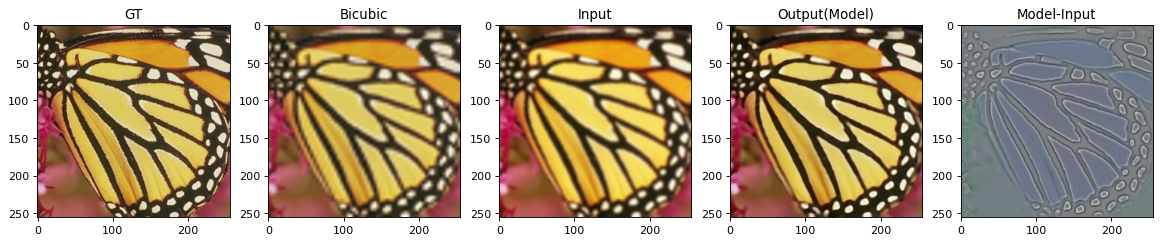

(6.354248046875, 29.39093585572352, 97.89891300513409)

In [14]:
display_PSNR(im_gt, im_b, im_b2, model, channels=1)


In [15]:
from jupyterplot import ProgressPlot


In [16]:
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/baby_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/baby_GT_scale_4.bmp").convert("RGB")
im_gt2 = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/head_GT.bmp").convert("RGB")
im_b2 = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/head_GT_scale_4.bmp").convert("RGB")

In [17]:
pp = ProgressPlot(x_iterator=False,
                  x_label="k_act",
                  x_lim=[2, 16],
                  y_lim=[[0, 16],[28,35.0],[0,30]],
                  plot_names=["kernel",'PSNR','blurryness'],
                  line_names=["pred1","pred2"])
k_act = []
k_pred = []
for k in range(2,16):
    
    kp1, err1, sharpness1 = display_PSNR(im_gt, im_b, pil_disk_blur(im_gt,k), model, channels=1, display = False)
    kp2, err2, sharpness2 = display_PSNR(im_gt2, im_b2, pil_disk_blur(im_gt2,k), model, channels=1, display = False)
    #k_act.append(k)
    #k_pred.append(display_PSNR(im_gt, im_b, pil_disk_blur(im_gt,k), model, channels=1, display = False))
    pp.update(k,[[kp1,kp2],[err1,err2],[100/sharpness1,100/sharpness2]])
    print(k, kp1, err1,100/sharpness1)
pp.finalize()    

2 3.216552734375 29.64884906939785 1.829382046125478
3 4.2437744140625 29.514401375484294 3.1138980534602365
4 4.893310546875 29.40044059643601 4.684576228915555
5 5.38720703125 29.328613210191314 7.463293757269293
6 6.022216796875 29.277726892629914 10.42101741127799
7 6.636474609375 29.248636738326724 13.129422461086673
8 7.723876953125 29.203795453485668 17.06806834427636
9 8.90673828125 29.138313987046356 22.78752346640277
10 9.4462890625 29.087407421836993 26.05328869885797
11 10.64990234375 29.031465652554797 29.77657346248509
12 12.47607421875 28.9733648933821 32.70537145935497
13 14.16943359375 28.885384552013 36.394029419657784
14 14.7255859375 28.851488586397508 37.931579124810796
15 15.38134765625 28.77947554479739 40.739687989075314


psnr for bicubic is 35.4212448343469dB
psnr for input is 34.215231387935965dB
psnr for Model is 29.318586052119635dB
PSNR improvement is -4.896645335816331dB
Sharpness Measurement GroundTruth: 247.28295878820063
Sharpness Measurement Bicubic: 25.114424224419054
Sharpness Measurement Input: 13.39890981814824
Sharpness Measurement Model: 50.58692534615693
Estimate of kernel: 5.38720703125


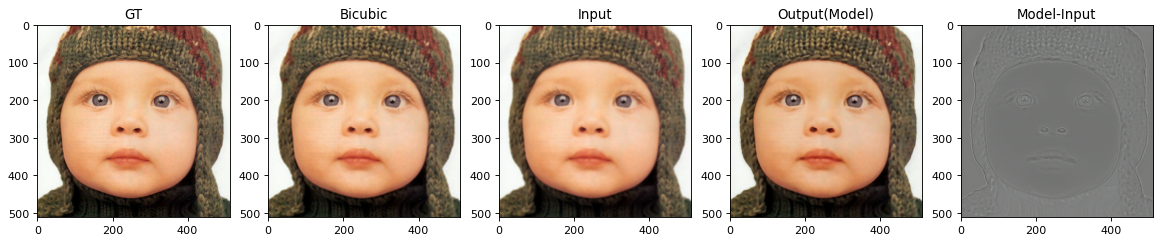

psnr for bicubic is 33.79334620764801dB
psnr for input is 32.66524913753282dB
psnr for Model is 30.95261206028976dB
PSNR improvement is -1.712637077243059dB
Sharpness Measurement GroundTruth: 726.1960912189749
Sharpness Measurement Bicubic: 86.32123035594319
Sharpness Measurement Input: 41.50798132625802
Sharpness Measurement Model: 202.80131039986526
Estimate of kernel: 5.013671875


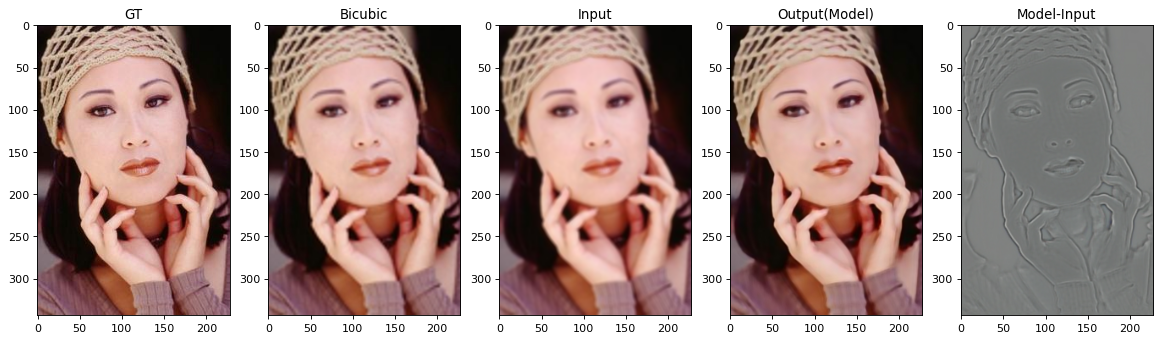

psnr for bicubic is 31.395553867347118dB
psnr for input is 28.832402264713913dB
psnr for Model is 29.899810763055296dB
PSNR improvement is 1.0674084983413827dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 220.94280080404133
Sharpness Measurement Input: 141.08107322454453
Sharpness Measurement Model: 743.681919827126
Estimate of kernel: 5.100830078125


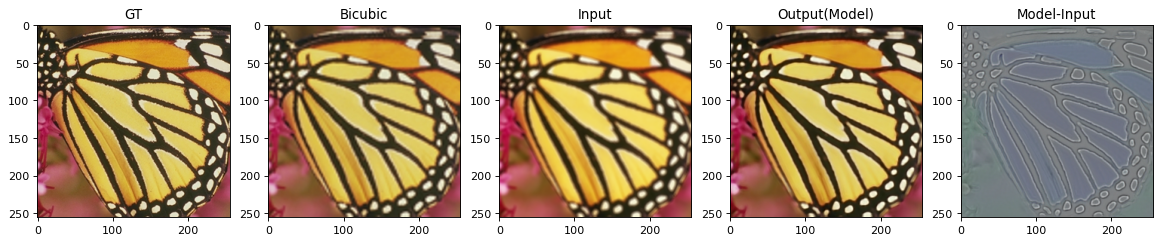

psnr for bicubic is 32.45693103332128dB
psnr for input is 31.56371005451374dB
psnr for Model is 30.525009220908146dB
PSNR improvement is -1.0387008336055956dB
Sharpness Measurement GroundTruth: 593.2631865654935
Sharpness Measurement Bicubic: 19.065994874531448
Sharpness Measurement Input: 12.302703915035403
Sharpness Measurement Model: 27.971135132334187
Estimate of kernel: 5.798095703125


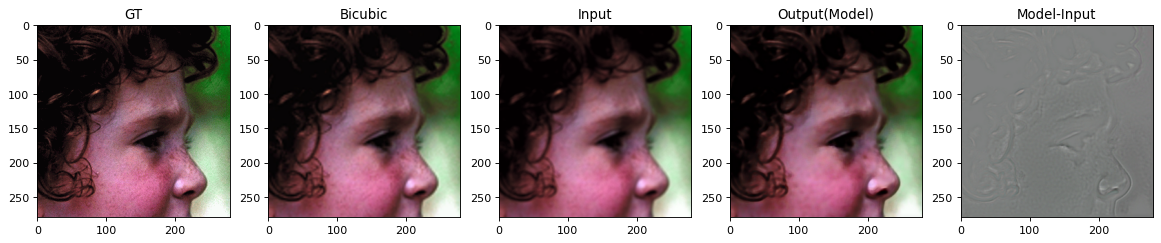

psnr for bicubic is 35.3610134150669dB
psnr for input is 33.73910171990677dB
psnr for Model is 32.2793258920865dB
PSNR improvement is -1.4597758278202733dB
Sharpness Measurement GroundTruth: 233.21159694144288
Sharpness Measurement Bicubic: 43.0580146532563
Sharpness Measurement Input: 20.922507876794594
Sharpness Measurement Model: 90.79934238816993
Estimate of kernel: 4.9638671875


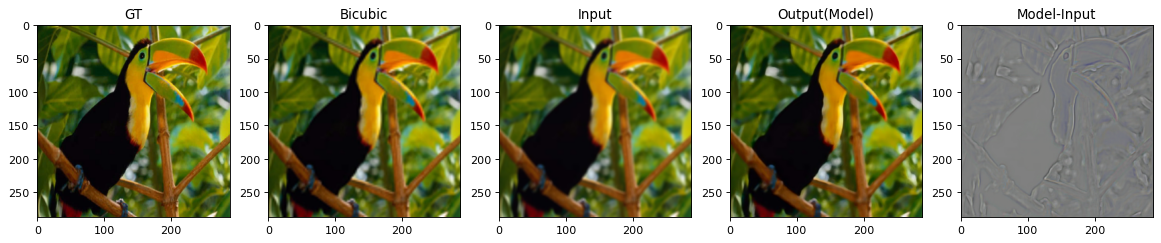

Bicubic average PSNR = 30.59506879769187
Model average PSNR = 45.842635232156155


In [18]:
test_results("/media/SSD/superres/video_data/test_data/Set5", 5, model, channels = 1,display = True)

# convert sample videos

In [78]:
from superres_utils import decolorize_cv, colorize_cv, cv_center_crop

from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=True,
                 bitrate= "12000k",errorfile = None, k_scale = 17, center_crop = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    if center_crop is None:
        width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
    else:
        width,height = center_crop
    
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(errorfile,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    k_preds = []
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            #crop frame if needed
            if center_crop is not None:
                frame = cv_center_crop(frame,(height,width))
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            
            if channels == 1:
                im_input, im_b_ycbcr = decolorize_cv(frame)

                im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
                im_input = im_input.cuda()

                with torch.no_grad():
                    with autocast():
                        mout = model(im_input)
                out = (mout[0]*255.0).clamp(0,255)
                
                

                out = out.cpu()

                im_h_y = out.data[0].numpy().astype(np.float32)

                im_h_y = im_h_y[0,:,:]

                im_h = colorize_cv(im_h_y, im_b_ycbcr)
            elif channels == 3:
                im_input = frame/255.
                im_input = Variable(torch.from_numpy(im_input).float()).\
                view(1, 3, im_input.shape[0], im_input.shape[1])
        
  
                im_input = im_input.cuda()
    
                
                
                with torch.no_grad():
                    with autocast():
                        mout = model(im_input)
                out = (mout[0]*255.0).clamp(0,255)

                out = out.cpu()
                
                im_h = out.data[0].view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)

                #im_h = out.data[0].numpy().astype(np.float32)

            #Add notation and crude bar chart to video frame
            
            if len(mout)>1:
                cv2.putText(im_h, text='k={:.2f}'.format(k_scale*mout[1].item()), org=(new_width-70,new_height-50),
                fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,0,255),
                thickness=1, lineType=cv2.LINE_AA)
                
                cv2.putText(im_h, text='_', org=(new_width-5,new_height - int(new_height*mout[1].item())),
                fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,0,255),
                thickness=2, lineType=cv2.LINE_AA)
                
                
            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

  0%|          | 5/7195 [3:08:54<4527:20:41, 2266.82s/it]


In [44]:
result_path

PosixPath('/media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 camspec training-Copy1')

In [79]:


infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-16.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.6,display=False,bitrate= "4000k")



  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 2/900 [00:00<01:04, 13.97it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 camspec training-Copy1/muffins30sec-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k




  0%|          | 4/900 [00:00<01:05, 13.63it/s]

  1%|          | 6/900 [00:00<01:08, 13.10it/s]

  1%|          | 8/900 [00:00<01:09, 12.88it/s]

  1%|          | 10/900 [00:00<01:07, 13.24it/s]

  1%|▏         | 12/900 [00:00<01:09, 12.79it/s]

  2%|▏         | 14/900 [00:01<01:09, 12.68it/s]

  2%|▏         | 16/900 [00:01<01:08, 12.88it/s]

  2%|▏         | 18/900 [00:01<01:09, 12.72it/s]

  2%|▏         | 20/900 [00:01<01:08, 12.76it/s]

  2%|▏         | 22/900 [00:01<01:08, 12.77it/s]

  3%|▎         | 24/900 [00:01<01:07, 12.99it/s]

  3%|▎         | 26/900 [00:02<01:07, 12.99it/s]

  3%|▎         | 28/900 [00:02<01:06, 13.07it/s]

  3%|▎         | 30/900 [00:02<01:07, 12.91it/s]

  4%|▎         | 32/900 [00:02<01:08, 12.74it/s]

  4%|▍         | 34/900 [00:02<01:07, 12.80it/s]

  4%|▍         | 36/900 [00:02<01:08, 12.58it/s]

  4%|▍         | 38/900 [00:02<01:08, 12.55it/s]

  4%|▍         | 40/900 [00:03<01:09, 12.44it/s]

  5%|▍         | 42/900 [00:03<01:09, 12.42it/s]

 

 32%|███▏      | 292/900 [00:22<00:46, 13.02it/s]

 33%|███▎      | 294/900 [00:22<00:46, 12.96it/s]

 33%|███▎      | 296/900 [00:22<00:45, 13.41it/s]

 33%|███▎      | 298/900 [00:22<00:45, 13.17it/s]

 33%|███▎      | 300/900 [00:22<00:46, 12.99it/s]

 34%|███▎      | 302/900 [00:22<00:45, 13.14it/s]

 34%|███▍      | 304/900 [00:23<00:45, 13.13it/s]

 34%|███▍      | 306/900 [00:23<00:43, 13.54it/s]

 34%|███▍      | 308/900 [00:23<00:44, 13.25it/s]

 34%|███▍      | 310/900 [00:23<00:44, 13.28it/s]

 35%|███▍      | 312/900 [00:23<00:43, 13.46it/s]

 35%|███▍      | 314/900 [00:23<00:43, 13.38it/s]

 35%|███▌      | 316/900 [00:24<00:43, 13.29it/s]

 35%|███▌      | 318/900 [00:24<00:42, 13.65it/s]

 36%|███▌      | 320/900 [00:24<00:43, 13.29it/s]

 36%|███▌      | 322/900 [00:24<00:44, 13.04it/s]

 36%|███▌      | 324/900 [00:24<00:42, 13.49it/s]

 36%|███▌      | 326/900 [00:24<00:42, 13.54it/s]

 36%|███▋      | 328/900 [00:24<00:42, 13.43it/s]

 37%|███▋      | 330/900 [00:25

 64%|██████▍   | 578/900 [00:43<00:23, 13.47it/s]

 64%|██████▍   | 580/900 [00:43<00:24, 13.21it/s]

 65%|██████▍   | 582/900 [00:43<00:23, 13.44it/s]

 65%|██████▍   | 584/900 [00:44<00:23, 13.47it/s]

 65%|██████▌   | 586/900 [00:44<00:23, 13.47it/s]

 65%|██████▌   | 588/900 [00:44<00:23, 13.24it/s]

 66%|██████▌   | 590/900 [00:44<00:23, 13.21it/s]

 66%|██████▌   | 592/900 [00:44<00:23, 13.15it/s]

 66%|██████▌   | 594/900 [00:44<00:22, 13.80it/s]

 66%|██████▌   | 596/900 [00:45<00:22, 13.33it/s]

 66%|██████▋   | 598/900 [00:45<00:22, 13.31it/s]

 67%|██████▋   | 600/900 [00:45<00:22, 13.50it/s]

 67%|██████▋   | 602/900 [00:45<00:21, 13.62it/s]

 67%|██████▋   | 604/900 [00:45<00:21, 14.05it/s]

 67%|██████▋   | 606/900 [00:45<00:20, 14.38it/s]

 68%|██████▊   | 608/900 [00:45<00:21, 13.74it/s]

 68%|██████▊   | 610/900 [00:46<00:20, 14.25it/s]

 68%|██████▊   | 612/900 [00:46<00:20, 14.33it/s]

 68%|██████▊   | 614/900 [00:46<00:20, 13.82it/s]

 68%|██████▊   | 616/900 [00:46

 96%|█████████▌| 864/900 [01:04<00:02, 13.75it/s]

 96%|█████████▌| 866/900 [01:04<00:02, 13.44it/s]

 96%|█████████▋| 868/900 [01:04<00:02, 13.48it/s]

 97%|█████████▋| 870/900 [01:05<00:02, 13.49it/s]

 97%|█████████▋| 872/900 [01:05<00:02, 13.94it/s]

 97%|█████████▋| 874/900 [01:05<00:01, 13.31it/s]

 97%|█████████▋| 876/900 [01:05<00:01, 13.63it/s]

 98%|█████████▊| 878/900 [01:05<00:01, 13.86it/s]

 98%|█████████▊| 880/900 [01:05<00:01, 13.98it/s]

 98%|█████████▊| 882/900 [01:05<00:01, 13.53it/s]

 98%|█████████▊| 884/900 [01:06<00:01, 13.33it/s]

 98%|█████████▊| 886/900 [01:06<00:01, 13.58it/s]

 99%|█████████▊| 888/900 [01:06<00:00, 13.31it/s]

 99%|█████████▉| 890/900 [01:06<00:00, 13.65it/s]

 99%|█████████▉| 892/900 [01:06<00:00, 13.36it/s]

 99%|█████████▉| 894/900 [01:06<00:00, 13.52it/s]

100%|█████████▉| 896/900 [01:06<00:00, 13.36it/s]

100%|█████████▉| 898/900 [01:07<00:00, 13.30it/s]

100%|██████████| 900/900 [01:07<00:00, 13.38it/s]


True

In [46]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-10.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k")



  0%|          | 0/900 [00:00<?, ?it/s]

  2%|▏         | 14/900 [00:00<00:06, 139.55it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 camspec training-Copy1/muffins30sec-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k




  4%|▎         | 33/900 [00:00<00:05, 149.70it/s]

  6%|▌         | 52/900 [00:00<00:05, 158.46it/s]

  8%|▊         | 73/900 [00:00<00:04, 170.20it/s]

 11%|█         | 95/900 [00:00<00:04, 180.95it/s]

 13%|█▎        | 117/900 [00:00<00:04, 189.24it/s]

 15%|█▌        | 138/900 [00:00<00:03, 194.44it/s]

 18%|█▊        | 160/900 [00:00<00:03, 199.09it/s]

 20%|██        | 181/900 [00:00<00:03, 200.92it/s]

 22%|██▏       | 202/900 [00:01<00:03, 203.46it/s]

 25%|██▍       | 223/900 [00:01<00:03, 205.02it/s]

 27%|██▋       | 244/900 [00:01<00:03, 203.30it/s]

 29%|██▉       | 265/900 [00:01<00:03, 204.86it/s]

 32%|███▏      | 286/900 [00:01<00:02, 205.34it/s]

 34%|███▍      | 308/900 [00:01<00:02, 207.22it/s]

 37%|███▋      | 329/900 [00:01<00:02, 208.02it/s]

 39%|███▉      | 350/900 [00:01<00:02, 208.06it/s]

 41%|████▏     | 372/900 [00:01<00:02, 208.97it/s]

 44%|████▎     | 393/900 [00:01<00:02, 208.67it/s]

 46%|████▌     | 414/900 [00:02<00:02, 208.24it/s]

 48%|████▊    

([], True)

In [47]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-20.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=2.0,display=False,bitrate= "4000k")



  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 2/900 [00:00<00:57, 15.54it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 camspec training-Copy1/muffins30sec-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k




  0%|          | 4/900 [00:00<01:00, 14.88it/s]

  1%|          | 6/900 [00:00<01:02, 14.28it/s]

  1%|          | 8/900 [00:00<01:00, 14.80it/s]

  1%|          | 10/900 [00:00<01:00, 14.77it/s]

  1%|▏         | 12/900 [00:00<01:01, 14.33it/s]

  2%|▏         | 14/900 [00:00<01:02, 14.22it/s]

  2%|▏         | 16/900 [00:01<01:03, 13.81it/s]

  2%|▏         | 18/900 [00:01<01:03, 13.88it/s]

  2%|▏         | 20/900 [00:01<01:03, 13.86it/s]

  2%|▏         | 22/900 [00:01<01:03, 13.84it/s]

  3%|▎         | 24/900 [00:01<01:03, 13.78it/s]

  3%|▎         | 26/900 [00:01<01:03, 13.78it/s]

  3%|▎         | 28/900 [00:02<01:06, 13.15it/s]

  3%|▎         | 30/900 [00:02<01:05, 13.31it/s]

  4%|▎         | 32/900 [00:02<01:04, 13.48it/s]

  4%|▍         | 34/900 [00:02<01:04, 13.45it/s]

  4%|▍         | 36/900 [00:02<01:04, 13.43it/s]

  4%|▍         | 38/900 [00:02<01:04, 13.42it/s]

  4%|▍         | 40/900 [00:02<01:03, 13.46it/s]

  5%|▍         | 42/900 [00:03<01:05, 13.11it/s]

 

 32%|███▏      | 292/900 [00:22<00:45, 13.34it/s]

 33%|███▎      | 294/900 [00:22<00:47, 12.80it/s]

 33%|███▎      | 296/900 [00:22<00:47, 12.82it/s]

 33%|███▎      | 298/900 [00:22<00:46, 13.01it/s]

 33%|███▎      | 300/900 [00:22<00:45, 13.14it/s]

 34%|███▎      | 302/900 [00:22<00:46, 12.95it/s]

 34%|███▍      | 304/900 [00:23<00:45, 13.23it/s]

 34%|███▍      | 306/900 [00:23<00:44, 13.25it/s]

 34%|███▍      | 308/900 [00:23<00:45, 13.15it/s]

 34%|███▍      | 310/900 [00:23<00:42, 13.75it/s]

 35%|███▍      | 312/900 [00:23<00:42, 13.72it/s]

 35%|███▍      | 314/900 [00:23<00:44, 13.30it/s]

 35%|███▌      | 316/900 [00:23<00:42, 13.66it/s]

 35%|███▌      | 318/900 [00:24<00:43, 13.46it/s]

 36%|███▌      | 320/900 [00:24<00:42, 13.78it/s]

 36%|███▌      | 322/900 [00:24<00:42, 13.62it/s]

 36%|███▌      | 324/900 [00:24<00:41, 13.75it/s]

 36%|███▌      | 326/900 [00:24<00:41, 13.73it/s]

 36%|███▋      | 328/900 [00:24<00:43, 13.11it/s]

 37%|███▋      | 330/900 [00:25

 64%|██████▍   | 578/900 [00:43<00:23, 13.69it/s]

 64%|██████▍   | 580/900 [00:43<00:23, 13.80it/s]

 65%|██████▍   | 582/900 [00:43<00:23, 13.77it/s]

 65%|██████▍   | 584/900 [00:43<00:23, 13.71it/s]

 65%|██████▌   | 586/900 [00:43<00:23, 13.50it/s]

 65%|██████▌   | 588/900 [00:44<00:23, 13.40it/s]

 66%|██████▌   | 590/900 [00:44<00:24, 12.85it/s]

 66%|██████▌   | 592/900 [00:44<00:23, 13.19it/s]

 66%|██████▌   | 594/900 [00:44<00:22, 13.61it/s]

 66%|██████▌   | 596/900 [00:44<00:22, 13.79it/s]

 66%|██████▋   | 598/900 [00:44<00:22, 13.53it/s]

 67%|██████▋   | 600/900 [00:44<00:21, 13.66it/s]

 67%|██████▋   | 602/900 [00:45<00:21, 14.03it/s]

 67%|██████▋   | 604/900 [00:45<00:21, 13.93it/s]

 67%|██████▋   | 606/900 [00:45<00:20, 14.08it/s]

 68%|██████▊   | 608/900 [00:45<00:20, 14.05it/s]

 68%|██████▊   | 610/900 [00:45<00:21, 13.50it/s]

 68%|██████▊   | 612/900 [00:45<00:21, 13.56it/s]

 68%|██████▊   | 614/900 [00:46<00:21, 13.43it/s]

 68%|██████▊   | 616/900 [00:46

 96%|█████████▌| 864/900 [01:04<00:02, 13.31it/s]

 96%|█████████▌| 866/900 [01:04<00:02, 13.43it/s]

 96%|█████████▋| 868/900 [01:04<00:02, 13.24it/s]

 97%|█████████▋| 870/900 [01:04<00:02, 13.34it/s]

 97%|█████████▋| 872/900 [01:04<00:02, 13.85it/s]

 97%|█████████▋| 874/900 [01:05<00:01, 13.86it/s]

 97%|█████████▋| 876/900 [01:05<00:01, 13.62it/s]

 98%|█████████▊| 878/900 [01:05<00:01, 13.30it/s]

 98%|█████████▊| 880/900 [01:05<00:01, 13.56it/s]

 98%|█████████▊| 882/900 [01:05<00:01, 12.97it/s]

 98%|█████████▊| 884/900 [01:05<00:01, 13.04it/s]

 98%|█████████▊| 886/900 [01:06<00:01, 12.63it/s]

 99%|█████████▊| 888/900 [01:06<00:00, 13.17it/s]

 99%|█████████▉| 890/900 [01:06<00:00, 13.59it/s]

 99%|█████████▉| 892/900 [01:06<00:00, 13.85it/s]

 99%|█████████▉| 894/900 [01:06<00:00, 13.72it/s]

100%|█████████▉| 896/900 [01:06<00:00, 13.95it/s]

100%|█████████▉| 898/900 [01:06<00:00, 13.35it/s]

100%|██████████| 900/900 [01:07<00:00, 13.43it/s]


([], True)

In [48]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-30.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=3.0,display=False,bitrate= "4000k")




  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 camspec training-Copy1/muffins30sec-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k




  0%|          | 2/900 [00:00<01:21, 11.07it/s]

  0%|          | 4/900 [00:00<01:19, 11.23it/s]

  1%|          | 5/900 [00:00<01:26, 10.39it/s]

  1%|          | 7/900 [00:00<01:24, 10.58it/s]

  1%|          | 9/900 [00:00<01:25, 10.44it/s]

  1%|          | 11/900 [00:01<01:25, 10.44it/s]

  1%|▏         | 12/900 [00:01<01:28,  9.99it/s]

  1%|▏         | 13/900 [00:01<01:29,  9.87it/s]

  2%|▏         | 15/900 [00:01<01:26, 10.26it/s]

  2%|▏         | 17/900 [00:01<01:24, 10.50it/s]

  2%|▏         | 19/900 [00:01<01:23, 10.59it/s]

  2%|▏         | 21/900 [00:01<01:21, 10.84it/s]

  3%|▎         | 23/900 [00:02<01:20, 10.87it/s]

  3%|▎         | 25/900 [00:02<01:19, 11.05it/s]

  3%|▎         | 27/900 [00:02<01:21, 10.70it/s]

  3%|▎         | 29/900 [00:02<01:22, 10.61it/s]

  3%|▎         | 31/900 [00:02<01:22, 10.48it/s]

  4%|▎         | 33/900 [00:03<01:21, 10.62it/s]

  4%|▍         | 35/900 [00:03<01:20, 10.76it/s]

  4%|▍         | 37/900 [00:03<01:19, 10.83it/s]

  4

 32%|███▏      | 286/900 [00:27<00:59, 10.31it/s]

 32%|███▏      | 288/900 [00:27<00:58, 10.45it/s]

 32%|███▏      | 290/900 [00:27<00:57, 10.65it/s]

 32%|███▏      | 292/900 [00:27<00:56, 10.72it/s]

 33%|███▎      | 294/900 [00:28<00:56, 10.71it/s]

 33%|███▎      | 296/900 [00:28<00:56, 10.74it/s]

 33%|███▎      | 298/900 [00:28<00:55, 10.77it/s]

 33%|███▎      | 300/900 [00:28<00:54, 10.94it/s]

 34%|███▎      | 302/900 [00:28<00:54, 10.90it/s]

 34%|███▍      | 304/900 [00:28<00:53, 11.11it/s]

 34%|███▍      | 306/900 [00:29<00:52, 11.34it/s]

 34%|███▍      | 308/900 [00:29<00:52, 11.24it/s]

 34%|███▍      | 310/900 [00:29<00:51, 11.49it/s]

 35%|███▍      | 312/900 [00:29<00:48, 12.22it/s]

 35%|███▍      | 314/900 [00:29<00:49, 11.91it/s]

 35%|███▌      | 316/900 [00:29<00:50, 11.51it/s]

 35%|███▌      | 318/900 [00:30<00:51, 11.38it/s]

 36%|███▌      | 320/900 [00:30<00:52, 11.14it/s]

 36%|███▌      | 322/900 [00:30<00:53, 10.89it/s]

 36%|███▌      | 324/900 [00:30

 64%|██████▎   | 572/900 [00:51<00:28, 11.43it/s]

 64%|██████▍   | 574/900 [00:51<00:27, 11.92it/s]

 64%|██████▍   | 576/900 [00:52<00:27, 11.89it/s]

 64%|██████▍   | 578/900 [00:52<00:27, 11.88it/s]

 64%|██████▍   | 580/900 [00:52<00:27, 11.65it/s]

 65%|██████▍   | 582/900 [00:52<00:26, 11.79it/s]

 65%|██████▍   | 584/900 [00:52<00:27, 11.61it/s]

 65%|██████▌   | 586/900 [00:53<00:27, 11.50it/s]

 65%|██████▌   | 588/900 [00:53<00:27, 11.49it/s]

 66%|██████▌   | 590/900 [00:53<00:26, 11.56it/s]

 66%|██████▌   | 592/900 [00:53<00:26, 11.49it/s]

 66%|██████▌   | 594/900 [00:53<00:26, 11.45it/s]

 66%|██████▌   | 596/900 [00:53<00:26, 11.36it/s]

 66%|██████▋   | 598/900 [00:54<00:26, 11.44it/s]

 67%|██████▋   | 600/900 [00:54<00:26, 11.25it/s]

 67%|██████▋   | 602/900 [00:54<00:25, 11.66it/s]

 67%|██████▋   | 604/900 [00:54<00:25, 11.57it/s]

 67%|██████▋   | 606/900 [00:54<00:25, 11.47it/s]

 68%|██████▊   | 608/900 [00:54<00:25, 11.41it/s]

 68%|██████▊   | 610/900 [00:55

 95%|█████████▌| 858/900 [01:16<00:03, 11.59it/s]

 96%|█████████▌| 860/900 [01:16<00:03, 11.37it/s]

 96%|█████████▌| 862/900 [01:16<00:03, 11.19it/s]

 96%|█████████▌| 864/900 [01:16<00:03, 11.47it/s]

 96%|█████████▌| 866/900 [01:16<00:02, 11.47it/s]

 96%|█████████▋| 868/900 [01:17<00:02, 11.25it/s]

 97%|█████████▋| 870/900 [01:17<00:02, 11.45it/s]

 97%|█████████▋| 872/900 [01:17<00:02, 11.26it/s]

 97%|█████████▋| 874/900 [01:17<00:02, 11.22it/s]

 97%|█████████▋| 876/900 [01:17<00:02, 11.09it/s]

 98%|█████████▊| 878/900 [01:17<00:01, 11.18it/s]

 98%|█████████▊| 880/900 [01:18<00:01, 11.09it/s]

 98%|█████████▊| 882/900 [01:18<00:01, 11.22it/s]

 98%|█████████▊| 884/900 [01:18<00:01, 11.43it/s]

 98%|█████████▊| 886/900 [01:18<00:01, 11.73it/s]

 99%|█████████▊| 888/900 [01:18<00:01, 11.46it/s]

 99%|█████████▉| 890/900 [01:18<00:00, 11.58it/s]

 99%|█████████▉| 892/900 [01:19<00:00, 12.18it/s]

 99%|█████████▉| 894/900 [01:19<00:00, 12.08it/s]

100%|█████████▉| 896/900 [01:19

([], True)

In [49]:
dualfile= str(result_path/"muffins30sec-30dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [50]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [51]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [70]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = result_path/"super8.mp4"
error_file = "/media/SSD/superres/error.txt"
#superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [71]:

dualfile = str(result_path/"super8dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [72]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [73]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 training/super8.mp4"
outfile = str(result_path/"super8.mp4")
dualfile= str(result_path/"super8-tolast-dual.mp4")

In [74]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [75]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = str(result_path/"super8long.mp4")
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/Old 8mm Reels_1.mp4
frames= 121409 
width= 600 
height= 460 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 camspec training-Copy1/super8long.mp4
factor: 1.0 
width= 600 
height= 460 
bitrate= 4000k






  0%|          | 0/121409 [00:00<?, ?it/s]



  0%|          | 3/121409 [00:00<1:08:00, 29.76it/s]



  0%|          | 9/121409 [00:00<59:23, 34.07it/s]  



  0%|          | 16/121409 [00:00<51:25, 39.34it/s]



  0%|          | 23/121409 [00:00<45:53, 44.08it/s]



  0%|          | 29/121409 [00:00<42:56, 47.10it/s]



  0%|          | 36/121409 [00:00<40:26, 50.02it/s]



  0%|          | 43/121409 [00:00<37:34, 53.83it/s]



  0%|          | 49/121409 [00:00<40:08, 50.39it/s]



  0%|          | 55/121409 [00:01<40:53, 49.47it/s]



  0%|          | 61/121409 [00:01<45:23, 44.56it/s]



  0%|          | 66/121409 [00:01<46:49, 43.20it/s]



  0%|          | 71/121409 [00:01<50:48, 39.81it/s]



  0%|          | 76/121409 [00:01<52:20, 38.64it/s]



  0%|          | 80/121409 [00:01<54:20, 37.21it/s]



  0%|          | 84/121409 [00:01<55:52, 36.19it/s]



  0%|          | 88/121409 [00:01<54:50, 36.87it/s]



  0%|          | 92/121409 [00:02<58:29, 34.57it/s]



  0%|        

  0%|          | 516/121409 [00:14<59:24, 33.91it/s]  



  0%|          | 520/121409 [00:14<59:12, 34.03it/s]



  0%|          | 524/121409 [00:14<59:32, 33.84it/s]



  0%|          | 528/121409 [00:14<59:09, 34.06it/s]



  0%|          | 532/121409 [00:14<1:00:46, 33.15it/s]



  0%|          | 536/121409 [00:14<1:01:59, 32.49it/s]



  0%|          | 541/121409 [00:15<58:23, 34.50it/s]  



  0%|          | 545/121409 [00:15<57:00, 35.33it/s]



  0%|          | 549/121409 [00:15<56:20, 35.75it/s]



  0%|          | 553/121409 [00:15<57:55, 34.77it/s]



  0%|          | 558/121409 [00:15<55:43, 36.14it/s]



  0%|          | 562/121409 [00:15<1:00:19, 33.38it/s]



  0%|          | 566/121409 [00:15<1:00:11, 33.46it/s]



  0%|          | 570/121409 [00:15<1:00:51, 33.10it/s]



  0%|          | 575/121409 [00:16<58:29, 34.43it/s]  



  0%|          | 579/121409 [00:16<1:01:08, 32.94it/s]



  0%|          | 583/121409 [00:16<1:01:41, 32.64it/s]



  0%|          | 587/121409 

  1%|          | 1010/121409 [00:28<1:04:10, 31.26it/s]



  1%|          | 1014/121409 [00:28<1:00:32, 33.14it/s]



  1%|          | 1018/121409 [00:28<58:51, 34.09it/s]  



  1%|          | 1022/121409 [00:29<59:30, 33.72it/s]



  1%|          | 1026/121409 [00:29<58:40, 34.19it/s]



  1%|          | 1030/121409 [00:29<1:00:25, 33.21it/s]



  1%|          | 1034/121409 [00:29<59:37, 33.65it/s]  



  1%|          | 1039/121409 [00:29<57:40, 34.78it/s]



  1%|          | 1043/121409 [00:29<1:01:04, 32.85it/s]



  1%|          | 1047/121409 [00:29<1:00:18, 33.26it/s]



  1%|          | 1051/121409 [00:29<59:27, 33.74it/s]  



  1%|          | 1055/121409 [00:29<59:58, 33.45it/s]



  1%|          | 1059/121409 [00:30<59:49, 33.52it/s]



  1%|          | 1063/121409 [00:30<59:18, 33.82it/s]



  1%|          | 1067/121409 [00:30<57:16, 35.02it/s]



  1%|          | 1071/121409 [00:30<57:12, 35.06it/s]



  1%|          | 1075/121409 [00:30<57:31, 34.87it/s]



  1%|          

  1%|          | 1497/121409 [00:42<54:14, 36.84it/s]



  1%|          | 1501/121409 [00:42<58:14, 34.31it/s]



  1%|          | 1505/121409 [00:42<59:13, 33.75it/s]



  1%|          | 1509/121409 [00:42<58:53, 33.93it/s]



  1%|          | 1514/121409 [00:42<55:08, 36.23it/s]



  1%|▏         | 1518/121409 [00:43<57:41, 34.64it/s]



  1%|▏         | 1522/121409 [00:43<57:06, 34.98it/s]



  1%|▏         | 1526/121409 [00:43<55:05, 36.26it/s]



  1%|▏         | 1530/121409 [00:43<56:32, 35.34it/s]



  1%|▏         | 1534/121409 [00:43<57:56, 34.48it/s]



  1%|▏         | 1538/121409 [00:43<59:40, 33.48it/s]



  1%|▏         | 1542/121409 [00:43<1:00:19, 33.12it/s]



  1%|▏         | 1546/121409 [00:43<59:04, 33.82it/s]  



  1%|▏         | 1550/121409 [00:44<1:01:03, 32.72it/s]



  1%|▏         | 1554/121409 [00:44<1:04:02, 31.20it/s]



  1%|▏         | 1558/121409 [00:44<1:04:11, 31.11it/s]



  1%|▏         | 1563/121409 [00:44<1:00:08, 33.21it/s]



  1%|▏         | 15

  2%|▏         | 1981/121409 [00:56<55:48, 35.67it/s]



  2%|▏         | 1985/121409 [00:56<56:22, 35.31it/s]



  2%|▏         | 1989/121409 [00:56<56:45, 35.06it/s]



  2%|▏         | 1993/121409 [00:57<55:52, 35.62it/s]



  2%|▏         | 1997/121409 [00:57<55:50, 35.64it/s]



  2%|▏         | 2002/121409 [00:57<53:53, 36.93it/s]



  2%|▏         | 2006/121409 [00:57<53:12, 37.40it/s]



  2%|▏         | 2010/121409 [00:57<52:14, 38.09it/s]



  2%|▏         | 2014/121409 [00:57<53:36, 37.12it/s]



  2%|▏         | 2018/121409 [00:57<53:48, 36.98it/s]



  2%|▏         | 2022/121409 [00:57<54:54, 36.23it/s]



  2%|▏         | 2026/121409 [00:57<56:28, 35.24it/s]



  2%|▏         | 2030/121409 [00:58<58:43, 33.88it/s]



  2%|▏         | 2034/121409 [00:58<57:45, 34.44it/s]



  2%|▏         | 2038/121409 [00:58<1:00:36, 32.83it/s]



  2%|▏         | 2042/121409 [00:58<1:00:38, 32.80it/s]



  2%|▏         | 2047/121409 [00:58<58:34, 33.97it/s]  



  2%|▏         | 2051/121

  2%|▏         | 2465/121409 [01:10<56:34, 35.04it/s]



  2%|▏         | 2470/121409 [01:10<54:14, 36.54it/s]



  2%|▏         | 2474/121409 [01:10<55:47, 35.53it/s]



  2%|▏         | 2478/121409 [01:11<54:51, 36.13it/s]



  2%|▏         | 2482/121409 [01:11<55:54, 35.45it/s]



  2%|▏         | 2486/121409 [01:11<55:06, 35.97it/s]



  2%|▏         | 2490/121409 [01:11<58:35, 33.83it/s]



  2%|▏         | 2494/121409 [01:11<59:34, 33.27it/s]



  2%|▏         | 2498/121409 [01:11<59:12, 33.47it/s]



  2%|▏         | 2502/121409 [01:11<59:54, 33.08it/s]



  2%|▏         | 2507/121409 [01:11<58:01, 34.15it/s]



  2%|▏         | 2511/121409 [01:12<59:03, 33.55it/s]



  2%|▏         | 2517/121409 [01:12<52:39, 37.63it/s]



  2%|▏         | 2523/121409 [01:12<49:10, 40.30it/s]



  2%|▏         | 2528/121409 [01:12<47:36, 41.62it/s]



  2%|▏         | 2533/121409 [01:12<45:50, 43.21it/s]



  2%|▏         | 2538/121409 [01:12<44:38, 44.38it/s]



  2%|▏         | 2543/121409 [0

  3%|▎         | 3127/121409 [01:24<41:22, 47.65it/s]



  3%|▎         | 3133/121409 [01:24<39:42, 49.64it/s]



  3%|▎         | 3139/121409 [01:24<39:43, 49.63it/s]



  3%|▎         | 3144/121409 [01:24<40:33, 48.59it/s]



  3%|▎         | 3150/121409 [01:24<39:16, 50.19it/s]



  3%|▎         | 3156/121409 [01:24<39:21, 50.07it/s]



  3%|▎         | 3162/121409 [01:25<40:01, 49.25it/s]



  3%|▎         | 3167/121409 [01:25<41:38, 47.33it/s]



  3%|▎         | 3172/121409 [01:25<42:48, 46.04it/s]



  3%|▎         | 3178/121409 [01:25<40:48, 48.30it/s]



  3%|▎         | 3184/121409 [01:25<40:56, 48.12it/s]



  3%|▎         | 3190/121409 [01:25<39:50, 49.46it/s]



  3%|▎         | 3195/121409 [01:25<40:18, 48.89it/s]



  3%|▎         | 3201/121409 [01:25<38:38, 50.98it/s]



  3%|▎         | 3207/121409 [01:26<39:11, 50.27it/s]



  3%|▎         | 3213/121409 [01:26<38:55, 50.62it/s]



  3%|▎         | 3219/121409 [01:26<38:20, 51.38it/s]



  3%|▎         | 3225/121409 [0

  3%|▎         | 3806/121409 [01:38<39:23, 49.75it/s]



  3%|▎         | 3811/121409 [01:38<40:37, 48.25it/s]



  3%|▎         | 3816/121409 [01:38<42:31, 46.09it/s]



  3%|▎         | 3822/121409 [01:38<40:05, 48.89it/s]



  3%|▎         | 3827/121409 [01:38<40:01, 48.97it/s]



  3%|▎         | 3833/121409 [01:38<39:46, 49.28it/s]



  3%|▎         | 3838/121409 [01:38<40:51, 47.97it/s]



  3%|▎         | 3844/121409 [01:38<39:35, 49.49it/s]



  3%|▎         | 3849/121409 [01:38<39:35, 49.48it/s]



  3%|▎         | 3855/121409 [01:39<39:51, 49.15it/s]



  3%|▎         | 3861/121409 [01:39<39:39, 49.40it/s]



  3%|▎         | 3867/121409 [01:39<38:18, 51.13it/s]



  3%|▎         | 3873/121409 [01:39<39:06, 50.09it/s]



  3%|▎         | 3879/121409 [01:39<37:25, 52.35it/s]



  3%|▎         | 3886/121409 [01:39<35:52, 54.60it/s]



  3%|▎         | 3892/121409 [01:39<37:30, 52.22it/s]



  3%|▎         | 3898/121409 [01:39<37:23, 52.38it/s]



  3%|▎         | 3904/121409 [0

  4%|▎         | 4502/121409 [01:51<40:11, 48.48it/s]



  4%|▎         | 4508/121409 [01:51<38:58, 49.98it/s]



  4%|▎         | 4514/121409 [01:51<39:31, 49.28it/s]



  4%|▎         | 4520/121409 [01:52<38:43, 50.30it/s]



  4%|▎         | 4526/121409 [01:52<40:23, 48.24it/s]



  4%|▎         | 4532/121409 [01:52<38:21, 50.79it/s]



  4%|▎         | 4538/121409 [01:52<37:28, 51.98it/s]



  4%|▎         | 4544/121409 [01:52<38:26, 50.68it/s]



  4%|▎         | 4550/121409 [01:52<38:19, 50.82it/s]



  4%|▍         | 4556/121409 [01:52<39:21, 49.48it/s]



  4%|▍         | 4561/121409 [01:52<41:18, 47.14it/s]



  4%|▍         | 4567/121409 [01:53<39:42, 49.04it/s]



  4%|▍         | 4573/121409 [01:53<38:19, 50.82it/s]



  4%|▍         | 4579/121409 [01:53<37:21, 52.11it/s]



  4%|▍         | 4585/121409 [01:53<37:59, 51.25it/s]



  4%|▍         | 4591/121409 [01:53<38:12, 50.95it/s]



  4%|▍         | 4597/121409 [01:53<39:23, 49.42it/s]



  4%|▍         | 4603/121409 [0

  4%|▍         | 5198/121409 [02:05<40:51, 47.40it/s]



  4%|▍         | 5204/121409 [02:05<39:34, 48.94it/s]



  4%|▍         | 5209/121409 [02:05<39:25, 49.13it/s]



  4%|▍         | 5215/121409 [02:05<38:38, 50.12it/s]



  4%|▍         | 5221/121409 [02:06<38:00, 50.94it/s]



  4%|▍         | 5227/121409 [02:06<37:15, 51.96it/s]



  4%|▍         | 5233/121409 [02:06<38:02, 50.91it/s]



  4%|▍         | 5240/121409 [02:06<36:10, 53.52it/s]



  4%|▍         | 5246/121409 [02:06<38:39, 50.08it/s]



  4%|▍         | 5252/121409 [02:06<38:23, 50.42it/s]



  4%|▍         | 5258/121409 [02:06<38:58, 49.67it/s]



  4%|▍         | 5264/121409 [02:06<38:21, 50.46it/s]



  4%|▍         | 5270/121409 [02:07<37:14, 51.97it/s]



  4%|▍         | 5276/121409 [02:07<39:40, 48.79it/s]



  4%|▍         | 5281/121409 [02:07<47:44, 40.54it/s]



  4%|▍         | 5286/121409 [02:07<49:47, 38.87it/s]



  4%|▍         | 5291/121409 [02:07<47:33, 40.69it/s]



  4%|▍         | 5296/121409 [0

  5%|▍         | 5875/121409 [02:19<39:07, 49.21it/s]



  5%|▍         | 5881/121409 [02:19<38:30, 49.99it/s]



  5%|▍         | 5887/121409 [02:19<39:22, 48.89it/s]



  5%|▍         | 5892/121409 [02:19<40:41, 47.30it/s]



  5%|▍         | 5897/121409 [02:19<40:14, 47.85it/s]



  5%|▍         | 5902/121409 [02:19<41:00, 46.95it/s]



  5%|▍         | 5907/121409 [02:19<40:38, 47.37it/s]



  5%|▍         | 5912/121409 [02:20<40:59, 46.95it/s]



  5%|▍         | 5918/121409 [02:20<39:32, 48.69it/s]



  5%|▍         | 5923/121409 [02:20<39:59, 48.12it/s]



  5%|▍         | 5929/121409 [02:20<38:49, 49.58it/s]



  5%|▍         | 5934/121409 [02:20<38:56, 49.43it/s]



  5%|▍         | 5939/121409 [02:20<38:48, 49.60it/s]



  5%|▍         | 5944/121409 [02:20<40:44, 47.24it/s]



  5%|▍         | 5949/121409 [02:20<40:47, 47.17it/s]



  5%|▍         | 5956/121409 [02:20<38:05, 50.51it/s]



  5%|▍         | 5962/121409 [02:21<37:25, 51.41it/s]



  5%|▍         | 5968/121409 [0

  5%|▌         | 6527/121409 [02:32<40:30, 47.26it/s]



  5%|▌         | 6534/121409 [02:32<37:35, 50.93it/s]



  5%|▌         | 6540/121409 [02:32<37:19, 51.30it/s]



  5%|▌         | 6546/121409 [02:33<37:57, 50.42it/s]



  5%|▌         | 6552/121409 [02:33<39:25, 48.55it/s]



  5%|▌         | 6558/121409 [02:33<38:54, 49.19it/s]



  5%|▌         | 6564/121409 [02:33<38:07, 50.21it/s]



  5%|▌         | 6570/121409 [02:33<37:31, 51.01it/s]



  5%|▌         | 6576/121409 [02:33<37:03, 51.64it/s]



  5%|▌         | 6582/121409 [02:33<37:31, 51.00it/s]



  5%|▌         | 6588/121409 [02:33<37:22, 51.21it/s]



  5%|▌         | 6594/121409 [02:33<38:13, 50.05it/s]



  5%|▌         | 6600/121409 [02:34<38:26, 49.78it/s]



  5%|▌         | 6605/121409 [02:34<38:32, 49.64it/s]



  5%|▌         | 6611/121409 [02:34<37:29, 51.02it/s]



  5%|▌         | 6617/121409 [02:34<35:55, 53.26it/s]



  5%|▌         | 6623/121409 [02:34<36:17, 52.71it/s]



  5%|▌         | 6629/121409 [0

  6%|▌         | 7228/121409 [02:46<38:06, 49.94it/s]



  6%|▌         | 7234/121409 [02:46<36:43, 51.82it/s]



  6%|▌         | 7240/121409 [02:46<38:58, 48.82it/s]



  6%|▌         | 7246/121409 [02:46<38:31, 49.38it/s]



  6%|▌         | 7252/121409 [02:46<37:55, 50.16it/s]



  6%|▌         | 7258/121409 [02:46<37:55, 50.17it/s]



  6%|▌         | 7264/121409 [02:47<37:13, 51.11it/s]



  6%|▌         | 7270/121409 [02:47<38:29, 49.43it/s]



  6%|▌         | 7275/121409 [02:47<38:43, 49.12it/s]



  6%|▌         | 7281/121409 [02:47<38:07, 49.89it/s]



  6%|▌         | 7287/121409 [02:47<37:52, 50.22it/s]



  6%|▌         | 7293/121409 [02:47<37:51, 50.24it/s]



  6%|▌         | 7299/121409 [02:47<37:20, 50.92it/s]



  6%|▌         | 7305/121409 [02:47<37:46, 50.34it/s]



  6%|▌         | 7311/121409 [02:47<38:30, 49.37it/s]



  6%|▌         | 7316/121409 [02:48<38:55, 48.84it/s]



  6%|▌         | 7321/121409 [02:48<39:55, 47.62it/s]



  6%|▌         | 7326/121409 [0

  6%|▋         | 7887/121409 [02:59<30:48, 61.41it/s]



  7%|▋         | 7894/121409 [02:59<31:28, 60.11it/s]



  7%|▋         | 7901/121409 [02:59<31:55, 59.25it/s]



  7%|▋         | 7907/121409 [02:59<32:27, 58.28it/s]



  7%|▋         | 7913/121409 [02:59<33:23, 56.65it/s]



  7%|▋         | 7919/121409 [03:00<34:04, 55.50it/s]



  7%|▋         | 7925/121409 [03:00<33:22, 56.67it/s]



  7%|▋         | 7931/121409 [03:00<33:44, 56.05it/s]



  7%|▋         | 7937/121409 [03:00<33:28, 56.51it/s]



  7%|▋         | 7943/121409 [03:00<33:10, 57.01it/s]



  7%|▋         | 7949/121409 [03:00<33:38, 56.22it/s]



  7%|▋         | 7956/121409 [03:00<32:57, 57.38it/s]



  7%|▋         | 7963/121409 [03:00<32:19, 58.48it/s]



  7%|▋         | 7969/121409 [03:00<32:10, 58.76it/s]



  7%|▋         | 7975/121409 [03:01<33:00, 57.26it/s]



  7%|▋         | 7981/121409 [03:01<32:53, 57.47it/s]



  7%|▋         | 7987/121409 [03:01<32:45, 57.71it/s]



  7%|▋         | 7993/121409 [0

  7%|▋         | 8679/121409 [03:12<31:28, 59.69it/s]



  7%|▋         | 8686/121409 [03:12<31:41, 59.28it/s]



  7%|▋         | 8693/121409 [03:12<31:25, 59.80it/s]



  7%|▋         | 8700/121409 [03:13<30:58, 60.63it/s]



  7%|▋         | 8707/121409 [03:13<31:24, 59.80it/s]



  7%|▋         | 8714/121409 [03:13<31:02, 60.52it/s]



  7%|▋         | 8721/121409 [03:13<31:26, 59.74it/s]



  7%|▋         | 8728/121409 [03:13<31:02, 60.50it/s]



  7%|▋         | 8735/121409 [03:13<31:01, 60.51it/s]



  7%|▋         | 8742/121409 [03:13<30:44, 61.09it/s]



  7%|▋         | 8749/121409 [03:13<30:50, 60.87it/s]



  7%|▋         | 8756/121409 [03:14<30:52, 60.81it/s]



  7%|▋         | 8763/121409 [03:14<30:54, 60.74it/s]



  7%|▋         | 8770/121409 [03:14<31:27, 59.66it/s]



  7%|▋         | 8777/121409 [03:14<31:50, 58.94it/s]



  7%|▋         | 8784/121409 [03:14<31:30, 59.57it/s]



  7%|▋         | 8791/121409 [03:14<31:03, 60.43it/s]



  7%|▋         | 8798/121409 [0

  8%|▊         | 9491/121409 [03:26<31:05, 59.98it/s]



  8%|▊         | 9498/121409 [03:26<31:35, 59.03it/s]



  8%|▊         | 9505/121409 [03:26<30:51, 60.45it/s]



  8%|▊         | 9512/121409 [03:26<30:39, 60.84it/s]



  8%|▊         | 9519/121409 [03:26<30:42, 60.73it/s]



  8%|▊         | 9526/121409 [03:26<30:25, 61.28it/s]



  8%|▊         | 9533/121409 [03:26<29:59, 62.17it/s]



  8%|▊         | 9540/121409 [03:26<30:11, 61.76it/s]



  8%|▊         | 9547/121409 [03:27<30:07, 61.90it/s]



  8%|▊         | 9554/121409 [03:27<30:04, 61.99it/s]



  8%|▊         | 9561/121409 [03:27<30:08, 61.84it/s]



  8%|▊         | 9568/121409 [03:27<30:17, 61.54it/s]



  8%|▊         | 9575/121409 [03:27<30:33, 61.00it/s]



  8%|▊         | 9582/121409 [03:27<30:58, 60.17it/s]



  8%|▊         | 9589/121409 [03:27<31:09, 59.80it/s]



  8%|▊         | 9596/121409 [03:27<30:32, 61.02it/s]



  8%|▊         | 9603/121409 [03:27<30:26, 61.21it/s]



  8%|▊         | 9610/121409 [0

  8%|▊         | 10269/121409 [03:39<31:42, 58.42it/s]



  8%|▊         | 10275/121409 [03:39<32:15, 57.42it/s]



  8%|▊         | 10282/121409 [03:39<31:33, 58.69it/s]



  8%|▊         | 10288/121409 [03:39<31:50, 58.16it/s]



  8%|▊         | 10294/121409 [03:39<32:18, 57.33it/s]



  8%|▊         | 10300/121409 [03:39<32:08, 57.63it/s]



  8%|▊         | 10307/121409 [03:39<31:25, 58.93it/s]



  8%|▊         | 10313/121409 [03:40<31:22, 59.01it/s]



  8%|▊         | 10319/121409 [03:40<32:30, 56.95it/s]



  9%|▊         | 10326/121409 [03:40<31:30, 58.76it/s]



  9%|▊         | 10332/121409 [03:40<32:08, 57.60it/s]



  9%|▊         | 10338/121409 [03:40<31:47, 58.22it/s]



  9%|▊         | 10345/121409 [03:40<31:08, 59.43it/s]



  9%|▊         | 10351/121409 [03:40<31:17, 59.16it/s]



  9%|▊         | 10357/121409 [03:40<31:09, 59.39it/s]



  9%|▊         | 10364/121409 [03:40<30:41, 60.29it/s]



  9%|▊         | 10371/121409 [03:41<30:28, 60.72it/s]



  9%|▊        

  9%|▉         | 11069/121409 [03:52<31:17, 58.76it/s]



  9%|▉         | 11075/121409 [03:52<33:05, 55.56it/s]



  9%|▉         | 11082/121409 [03:52<32:10, 57.16it/s]



  9%|▉         | 11089/121409 [03:52<31:20, 58.65it/s]



  9%|▉         | 11095/121409 [03:52<31:35, 58.19it/s]



  9%|▉         | 11102/121409 [03:53<31:07, 59.08it/s]



  9%|▉         | 11109/121409 [03:53<30:33, 60.15it/s]



  9%|▉         | 11116/121409 [03:53<30:52, 59.52it/s]



  9%|▉         | 11123/121409 [03:53<30:21, 60.54it/s]



  9%|▉         | 11130/121409 [03:53<29:53, 61.49it/s]



  9%|▉         | 11137/121409 [03:53<29:32, 62.23it/s]



  9%|▉         | 11144/121409 [03:53<29:54, 61.46it/s]



  9%|▉         | 11151/121409 [03:53<29:56, 61.36it/s]



  9%|▉         | 11158/121409 [03:54<30:13, 60.80it/s]



  9%|▉         | 11165/121409 [03:54<30:08, 60.96it/s]



  9%|▉         | 11172/121409 [03:54<30:05, 61.07it/s]



  9%|▉         | 11179/121409 [03:54<31:15, 58.76it/s]



  9%|▉        

 10%|▉         | 11871/121409 [04:05<30:11, 60.45it/s]



 10%|▉         | 11878/121409 [04:05<31:09, 58.59it/s]



 10%|▉         | 11884/121409 [04:05<31:04, 58.76it/s]



 10%|▉         | 11891/121409 [04:06<30:41, 59.47it/s]



 10%|▉         | 11898/121409 [04:06<30:33, 59.71it/s]



 10%|▉         | 11905/121409 [04:06<30:40, 59.50it/s]



 10%|▉         | 11911/121409 [04:06<30:45, 59.32it/s]



 10%|▉         | 11917/121409 [04:06<30:43, 59.41it/s]



 10%|▉         | 11923/121409 [04:06<30:44, 59.34it/s]



 10%|▉         | 11930/121409 [04:06<30:13, 60.36it/s]



 10%|▉         | 11937/121409 [04:06<30:04, 60.68it/s]



 10%|▉         | 11944/121409 [04:06<30:26, 59.92it/s]



 10%|▉         | 11950/121409 [04:07<31:23, 58.11it/s]



 10%|▉         | 11956/121409 [04:07<32:33, 56.03it/s]



 10%|▉         | 11962/121409 [04:07<32:42, 55.78it/s]



 10%|▉         | 11968/121409 [04:07<34:41, 52.59it/s]



 10%|▉         | 11975/121409 [04:07<34:03, 53.56it/s]



 10%|▉        

 10%|█         | 12674/121409 [04:18<29:37, 61.16it/s]



 10%|█         | 12681/121409 [04:19<30:45, 58.91it/s]



 10%|█         | 12688/121409 [04:19<30:12, 59.99it/s]



 10%|█         | 12695/121409 [04:19<30:13, 59.93it/s]



 10%|█         | 12702/121409 [04:19<30:14, 59.91it/s]



 10%|█         | 12709/121409 [04:19<30:10, 60.04it/s]



 10%|█         | 12716/121409 [04:19<29:29, 61.41it/s]



 10%|█         | 12723/121409 [04:19<29:21, 61.72it/s]



 10%|█         | 12730/121409 [04:19<29:18, 61.82it/s]



 10%|█         | 12737/121409 [04:20<29:13, 61.97it/s]



 10%|█         | 12744/121409 [04:20<29:01, 62.40it/s]



 11%|█         | 12751/121409 [04:20<29:02, 62.37it/s]



 11%|█         | 12758/121409 [04:20<29:26, 61.50it/s]



 11%|█         | 12765/121409 [04:20<29:17, 61.81it/s]



 11%|█         | 12772/121409 [04:20<28:52, 62.69it/s]



 11%|█         | 12779/121409 [04:20<28:41, 63.09it/s]



 11%|█         | 12786/121409 [04:20<29:08, 62.12it/s]



 11%|█        

 11%|█         | 13492/121409 [04:32<29:03, 61.91it/s]



 11%|█         | 13499/121409 [04:32<29:06, 61.80it/s]



 11%|█         | 13506/121409 [04:32<29:08, 61.73it/s]



 11%|█         | 13513/121409 [04:32<29:45, 60.42it/s]



 11%|█         | 13520/121409 [04:32<29:32, 60.86it/s]



 11%|█         | 13527/121409 [04:32<29:33, 60.85it/s]



 11%|█         | 13534/121409 [04:32<29:48, 60.32it/s]



 11%|█         | 13541/121409 [04:33<29:35, 60.77it/s]



 11%|█         | 13548/121409 [04:33<29:31, 60.90it/s]



 11%|█         | 13555/121409 [04:33<29:16, 61.40it/s]



 11%|█         | 13562/121409 [04:33<29:54, 60.10it/s]



 11%|█         | 13569/121409 [04:33<29:24, 61.11it/s]



 11%|█         | 13576/121409 [04:33<29:50, 60.22it/s]



 11%|█         | 13583/121409 [04:33<30:27, 59.01it/s]



 11%|█         | 13589/121409 [04:33<30:30, 58.89it/s]



 11%|█         | 13596/121409 [04:33<30:04, 59.76it/s]



 11%|█         | 13603/121409 [04:34<29:37, 60.65it/s]



 11%|█        

 12%|█▏        | 14269/121409 [04:45<30:24, 58.71it/s]



 12%|█▏        | 14276/121409 [04:45<30:10, 59.18it/s]



 12%|█▏        | 14283/121409 [04:45<29:35, 60.35it/s]



 12%|█▏        | 14290/121409 [04:45<29:14, 61.05it/s]



 12%|█▏        | 14297/121409 [04:45<29:10, 61.21it/s]



 12%|█▏        | 14304/121409 [04:45<29:13, 61.08it/s]



 12%|█▏        | 14311/121409 [04:45<29:16, 60.96it/s]



 12%|█▏        | 14318/121409 [04:46<29:14, 61.02it/s]



 12%|█▏        | 14325/121409 [04:46<29:02, 61.46it/s]



 12%|█▏        | 14332/121409 [04:46<29:07, 61.29it/s]



 12%|█▏        | 14339/121409 [04:46<29:03, 61.41it/s]



 12%|█▏        | 14346/121409 [04:46<28:59, 61.55it/s]



 12%|█▏        | 14353/121409 [04:46<28:55, 61.69it/s]



 12%|█▏        | 14360/121409 [04:46<29:15, 60.99it/s]



 12%|█▏        | 14367/121409 [04:46<28:48, 61.94it/s]



 12%|█▏        | 14374/121409 [04:46<28:44, 62.07it/s]



 12%|█▏        | 14381/121409 [04:47<28:42, 62.12it/s]



 12%|█▏       

 12%|█▏        | 15079/121409 [04:58<30:07, 58.84it/s]



 12%|█▏        | 15085/121409 [04:58<30:11, 58.69it/s]



 12%|█▏        | 15092/121409 [04:58<29:44, 59.59it/s]



 12%|█▏        | 15099/121409 [04:58<29:24, 60.26it/s]



 12%|█▏        | 15106/121409 [04:59<29:40, 59.72it/s]



 12%|█▏        | 15112/121409 [04:59<29:57, 59.12it/s]



 12%|█▏        | 15119/121409 [04:59<29:29, 60.05it/s]



 12%|█▏        | 15126/121409 [04:59<29:20, 60.37it/s]



 12%|█▏        | 15133/121409 [04:59<29:42, 59.64it/s]



 12%|█▏        | 15139/121409 [04:59<29:50, 59.35it/s]



 12%|█▏        | 15145/121409 [04:59<30:44, 57.62it/s]



 12%|█▏        | 15151/121409 [04:59<30:38, 57.81it/s]



 12%|█▏        | 15157/121409 [04:59<30:44, 57.61it/s]



 12%|█▏        | 15163/121409 [05:00<30:24, 58.23it/s]



 12%|█▏        | 15170/121409 [05:00<29:54, 59.20it/s]



 12%|█▏        | 15176/121409 [05:00<30:13, 58.59it/s]



 13%|█▎        | 15183/121409 [05:00<29:42, 59.59it/s]



 13%|█▎       

 13%|█▎        | 15878/121409 [05:11<29:06, 60.43it/s]



 13%|█▎        | 15885/121409 [05:11<29:43, 59.16it/s]



 13%|█▎        | 15892/121409 [05:12<29:14, 60.16it/s]



 13%|█▎        | 15899/121409 [05:12<29:24, 59.79it/s]



 13%|█▎        | 15906/121409 [05:12<28:54, 60.81it/s]



 13%|█▎        | 15913/121409 [05:12<29:04, 60.48it/s]



 13%|█▎        | 15920/121409 [05:12<29:03, 60.52it/s]



 13%|█▎        | 15927/121409 [05:12<29:05, 60.45it/s]



 13%|█▎        | 15934/121409 [05:12<29:24, 59.78it/s]



 13%|█▎        | 15941/121409 [05:12<29:12, 60.20it/s]



 13%|█▎        | 15948/121409 [05:13<28:59, 60.64it/s]



 13%|█▎        | 15955/121409 [05:13<29:41, 59.20it/s]



 13%|█▎        | 15962/121409 [05:13<29:12, 60.18it/s]



 13%|█▎        | 15969/121409 [05:13<29:10, 60.23it/s]



 13%|█▎        | 15976/121409 [05:13<28:32, 61.55it/s]



 13%|█▎        | 15983/121409 [05:13<28:47, 61.04it/s]



 13%|█▎        | 15990/121409 [05:13<28:42, 61.19it/s]



 13%|█▎       

 14%|█▎        | 16686/121409 [05:25<27:37, 63.19it/s]



 14%|█▎        | 16693/121409 [05:25<27:24, 63.66it/s]



 14%|█▍        | 16700/121409 [05:25<27:17, 63.96it/s]



 14%|█▍        | 16707/121409 [05:25<27:08, 64.29it/s]



 14%|█▍        | 16714/121409 [05:25<27:06, 64.36it/s]



 14%|█▍        | 16721/121409 [05:25<27:10, 64.20it/s]



 14%|█▍        | 16728/121409 [05:25<27:03, 64.50it/s]



 14%|█▍        | 16735/121409 [05:25<26:57, 64.73it/s]



 14%|█▍        | 16742/121409 [05:25<27:04, 64.43it/s]



 14%|█▍        | 16749/121409 [05:26<26:58, 64.67it/s]



 14%|█▍        | 16756/121409 [05:26<26:39, 65.43it/s]



 14%|█▍        | 16763/121409 [05:26<26:43, 65.24it/s]



 14%|█▍        | 16770/121409 [05:26<26:57, 64.67it/s]



 14%|█▍        | 16777/121409 [05:26<27:28, 63.48it/s]



 14%|█▍        | 16784/121409 [05:26<28:02, 62.17it/s]



 14%|█▍        | 16791/121409 [05:26<27:35, 63.19it/s]



 14%|█▍        | 16798/121409 [05:26<27:15, 63.95it/s]



 14%|█▍       

 14%|█▍        | 17505/121409 [05:37<27:07, 63.85it/s]



 14%|█▍        | 17512/121409 [05:38<27:02, 64.04it/s]



 14%|█▍        | 17519/121409 [05:38<27:05, 63.91it/s]



 14%|█▍        | 17526/121409 [05:38<27:06, 63.85it/s]



 14%|█▍        | 17533/121409 [05:38<27:03, 63.96it/s]



 14%|█▍        | 17540/121409 [05:38<27:03, 63.98it/s]



 14%|█▍        | 17547/121409 [05:38<27:00, 64.09it/s]



 14%|█▍        | 17554/121409 [05:38<26:57, 64.19it/s]



 14%|█▍        | 17561/121409 [05:38<27:01, 64.06it/s]



 14%|█▍        | 17568/121409 [05:38<26:44, 64.70it/s]



 14%|█▍        | 17575/121409 [05:38<26:41, 64.84it/s]



 14%|█▍        | 17582/121409 [05:39<26:42, 64.79it/s]



 14%|█▍        | 17589/121409 [05:39<26:36, 65.04it/s]



 14%|█▍        | 17596/121409 [05:39<26:35, 65.05it/s]



 14%|█▍        | 17603/121409 [05:39<26:50, 64.46it/s]



 15%|█▍        | 17610/121409 [05:39<26:41, 64.82it/s]



 15%|█▍        | 17617/121409 [05:39<26:37, 64.96it/s]



 15%|█▍       

 15%|█▌        | 18324/121409 [05:50<27:07, 63.34it/s]



 15%|█▌        | 18331/121409 [05:50<27:08, 63.28it/s]



 15%|█▌        | 18338/121409 [05:50<27:09, 63.24it/s]



 15%|█▌        | 18345/121409 [05:51<26:52, 63.91it/s]



 15%|█▌        | 18352/121409 [05:51<26:55, 63.80it/s]



 15%|█▌        | 18359/121409 [05:51<26:54, 63.83it/s]



 15%|█▌        | 18366/121409 [05:51<26:43, 64.25it/s]



 15%|█▌        | 18373/121409 [05:51<26:43, 64.25it/s]



 15%|█▌        | 18380/121409 [05:51<26:38, 64.45it/s]



 15%|█▌        | 18387/121409 [05:51<26:35, 64.57it/s]



 15%|█▌        | 18394/121409 [05:51<27:25, 62.61it/s]



 15%|█▌        | 18401/121409 [05:51<27:31, 62.37it/s]



 15%|█▌        | 18408/121409 [05:52<27:23, 62.69it/s]



 15%|█▌        | 18415/121409 [05:52<27:05, 63.38it/s]



 15%|█▌        | 18422/121409 [05:52<26:51, 63.89it/s]



 15%|█▌        | 18429/121409 [05:52<26:46, 64.09it/s]



 15%|█▌        | 18436/121409 [05:52<26:40, 64.33it/s]



 15%|█▌       

 16%|█▌        | 19143/121409 [06:03<26:21, 64.66it/s]



 16%|█▌        | 19150/121409 [06:03<26:29, 64.35it/s]



 16%|█▌        | 19157/121409 [06:03<26:21, 64.64it/s]



 16%|█▌        | 19164/121409 [06:03<26:25, 64.47it/s]



 16%|█▌        | 19171/121409 [06:03<26:15, 64.89it/s]



 16%|█▌        | 19178/121409 [06:04<26:26, 64.42it/s]



 16%|█▌        | 19185/121409 [06:04<26:15, 64.88it/s]



 16%|█▌        | 19192/121409 [06:04<26:15, 64.89it/s]



 16%|█▌        | 19199/121409 [06:04<26:19, 64.71it/s]



 16%|█▌        | 19206/121409 [06:04<26:23, 64.55it/s]



 16%|█▌        | 19213/121409 [06:04<26:12, 65.01it/s]



 16%|█▌        | 19220/121409 [06:04<26:23, 64.54it/s]



 16%|█▌        | 19227/121409 [06:04<26:22, 64.59it/s]



 16%|█▌        | 19234/121409 [06:04<26:16, 64.82it/s]



 16%|█▌        | 19241/121409 [06:05<26:01, 65.45it/s]



 16%|█▌        | 19248/121409 [06:05<26:05, 65.26it/s]



 16%|█▌        | 19255/121409 [06:05<26:04, 65.30it/s]



 16%|█▌       

 16%|█▋        | 19962/121409 [06:16<27:37, 61.22it/s]



 16%|█▋        | 19969/121409 [06:16<27:37, 61.22it/s]



 16%|█▋        | 19976/121409 [06:16<27:26, 61.60it/s]



 16%|█▋        | 19983/121409 [06:16<26:59, 62.63it/s]



 16%|█▋        | 19990/121409 [06:16<26:52, 62.88it/s]



 16%|█▋        | 19997/121409 [06:17<26:55, 62.79it/s]



 16%|█▋        | 20004/121409 [06:17<27:26, 61.60it/s]



 16%|█▋        | 20011/121409 [06:17<27:19, 61.84it/s]



 16%|█▋        | 20018/121409 [06:17<27:29, 61.47it/s]



 16%|█▋        | 20025/121409 [06:17<27:00, 62.57it/s]



 16%|█▋        | 20032/121409 [06:17<26:53, 62.82it/s]



 17%|█▋        | 20039/121409 [06:17<26:44, 63.18it/s]



 17%|█▋        | 20046/121409 [06:17<26:25, 63.95it/s]



 17%|█▋        | 20053/121409 [06:17<26:19, 64.18it/s]



 17%|█▋        | 20060/121409 [06:18<26:19, 64.16it/s]



 17%|█▋        | 20067/121409 [06:18<26:12, 64.45it/s]



 17%|█▋        | 20074/121409 [06:18<26:02, 64.85it/s]



 17%|█▋       

 17%|█▋        | 20781/121409 [06:29<26:10, 64.07it/s]



 17%|█▋        | 20788/121409 [06:29<26:21, 63.64it/s]



 17%|█▋        | 20795/121409 [06:29<26:25, 63.46it/s]



 17%|█▋        | 20802/121409 [06:29<26:05, 64.28it/s]



 17%|█▋        | 20809/121409 [06:29<25:55, 64.66it/s]



 17%|█▋        | 20816/121409 [06:29<26:03, 64.35it/s]



 17%|█▋        | 20823/121409 [06:30<26:21, 63.61it/s]



 17%|█▋        | 20830/121409 [06:30<26:23, 63.53it/s]



 17%|█▋        | 20837/121409 [06:30<26:14, 63.87it/s]



 17%|█▋        | 20844/121409 [06:30<26:05, 64.22it/s]



 17%|█▋        | 20851/121409 [06:30<25:59, 64.47it/s]



 17%|█▋        | 20858/121409 [06:30<25:54, 64.67it/s]



 17%|█▋        | 20865/121409 [06:30<25:58, 64.50it/s]



 17%|█▋        | 20872/121409 [06:30<26:08, 64.08it/s]



 17%|█▋        | 20879/121409 [06:30<26:26, 63.38it/s]



 17%|█▋        | 20886/121409 [06:31<26:33, 63.08it/s]



 17%|█▋        | 20893/121409 [06:31<26:16, 63.77it/s]



 17%|█▋       

 18%|█▊        | 21600/121409 [06:42<25:39, 64.83it/s]



 18%|█▊        | 21607/121409 [06:42<25:48, 64.44it/s]



 18%|█▊        | 21614/121409 [06:42<25:53, 64.23it/s]



 18%|█▊        | 21621/121409 [06:42<26:04, 63.77it/s]



 18%|█▊        | 21628/121409 [06:42<26:16, 63.31it/s]



 18%|█▊        | 21635/121409 [06:42<26:11, 63.47it/s]



 18%|█▊        | 21642/121409 [06:42<26:35, 62.52it/s]



 18%|█▊        | 21649/121409 [06:43<26:30, 62.72it/s]



 18%|█▊        | 21656/121409 [06:43<26:15, 63.30it/s]



 18%|█▊        | 21663/121409 [06:43<26:09, 63.57it/s]



 18%|█▊        | 21670/121409 [06:43<26:50, 61.94it/s]



 18%|█▊        | 21677/121409 [06:43<26:42, 62.22it/s]



 18%|█▊        | 21684/121409 [06:43<26:43, 62.20it/s]



 18%|█▊        | 21691/121409 [06:43<26:32, 62.61it/s]



 18%|█▊        | 21698/121409 [06:43<26:32, 62.60it/s]



 18%|█▊        | 21705/121409 [06:43<26:49, 61.94it/s]



 18%|█▊        | 21712/121409 [06:44<26:38, 62.36it/s]



 18%|█▊       

 18%|█▊        | 22419/121409 [06:55<26:09, 63.06it/s]



 18%|█▊        | 22426/121409 [06:55<26:15, 62.84it/s]



 18%|█▊        | 22433/121409 [06:55<26:10, 63.04it/s]



 18%|█▊        | 22440/121409 [06:55<26:22, 62.53it/s]



 18%|█▊        | 22447/121409 [06:55<26:22, 62.53it/s]



 18%|█▊        | 22454/121409 [06:55<26:19, 62.65it/s]



 19%|█▊        | 22461/121409 [06:55<26:12, 62.92it/s]



 19%|█▊        | 22468/121409 [06:56<25:58, 63.47it/s]



 19%|█▊        | 22475/121409 [06:56<25:51, 63.78it/s]



 19%|█▊        | 22482/121409 [06:56<25:49, 63.85it/s]



 19%|█▊        | 22489/121409 [06:56<25:51, 63.76it/s]



 19%|█▊        | 22496/121409 [06:56<26:12, 62.89it/s]



 19%|█▊        | 22503/121409 [06:56<26:03, 63.24it/s]



 19%|█▊        | 22510/121409 [06:56<26:04, 63.22it/s]



 19%|█▊        | 22517/121409 [06:56<26:00, 63.35it/s]



 19%|█▊        | 22524/121409 [06:56<25:56, 63.52it/s]



 19%|█▊        | 22531/121409 [06:57<26:19, 62.61it/s]



 19%|█▊       

 19%|█▉        | 23238/121409 [07:08<25:22, 64.47it/s]



 19%|█▉        | 23245/121409 [07:08<25:13, 64.85it/s]



 19%|█▉        | 23252/121409 [07:08<25:16, 64.71it/s]



 19%|█▉        | 23259/121409 [07:08<25:18, 64.64it/s]



 19%|█▉        | 23266/121409 [07:08<25:09, 65.03it/s]



 19%|█▉        | 23273/121409 [07:08<25:20, 64.56it/s]



 19%|█▉        | 23280/121409 [07:08<25:10, 64.97it/s]



 19%|█▉        | 23287/121409 [07:08<25:06, 65.15it/s]



 19%|█▉        | 23294/121409 [07:08<25:20, 64.54it/s]



 19%|█▉        | 23301/121409 [07:09<25:19, 64.55it/s]



 19%|█▉        | 23308/121409 [07:09<25:25, 64.31it/s]



 19%|█▉        | 23315/121409 [07:09<25:14, 64.75it/s]



 19%|█▉        | 23322/121409 [07:09<25:22, 64.43it/s]



 19%|█▉        | 23329/121409 [07:09<25:27, 64.21it/s]



 19%|█▉        | 23336/121409 [07:09<25:34, 63.89it/s]



 19%|█▉        | 23343/121409 [07:09<25:32, 64.01it/s]



 19%|█▉        | 23350/121409 [07:09<25:30, 64.06it/s]



 19%|█▉       

 20%|█▉        | 24057/121409 [07:20<25:22, 63.94it/s]



 20%|█▉        | 24064/121409 [07:21<25:23, 63.88it/s]



 20%|█▉        | 24071/121409 [07:21<25:17, 64.16it/s]



 20%|█▉        | 24078/121409 [07:21<25:15, 64.22it/s]



 20%|█▉        | 24085/121409 [07:21<25:32, 63.52it/s]



 20%|█▉        | 24092/121409 [07:21<25:30, 63.60it/s]



 20%|█▉        | 24099/121409 [07:21<25:45, 62.95it/s]



 20%|█▉        | 24106/121409 [07:21<25:37, 63.28it/s]



 20%|█▉        | 24113/121409 [07:21<25:18, 64.07it/s]



 20%|█▉        | 24120/121409 [07:21<25:20, 63.97it/s]



 20%|█▉        | 24127/121409 [07:22<25:28, 63.66it/s]



 20%|█▉        | 24134/121409 [07:22<25:14, 64.21it/s]



 20%|█▉        | 24141/121409 [07:22<25:13, 64.29it/s]



 20%|█▉        | 24148/121409 [07:22<25:12, 64.33it/s]



 20%|█▉        | 24155/121409 [07:22<25:08, 64.46it/s]



 20%|█▉        | 24162/121409 [07:22<25:11, 64.35it/s]



 20%|█▉        | 24169/121409 [07:22<25:07, 64.50it/s]



 20%|█▉       

 20%|██        | 24876/121409 [07:33<24:59, 64.37it/s]



 20%|██        | 24883/121409 [07:33<25:09, 63.96it/s]



 21%|██        | 24890/121409 [07:34<25:22, 63.41it/s]



 21%|██        | 24897/121409 [07:34<25:50, 62.25it/s]



 21%|██        | 24904/121409 [07:34<25:35, 62.84it/s]



 21%|██        | 24911/121409 [07:34<25:34, 62.87it/s]



 21%|██        | 24918/121409 [07:34<25:18, 63.54it/s]



 21%|██        | 24925/121409 [07:34<25:32, 62.96it/s]



 21%|██        | 24932/121409 [07:34<25:36, 62.81it/s]



 21%|██        | 24939/121409 [07:34<25:22, 63.36it/s]



 21%|██        | 24946/121409 [07:34<25:07, 64.00it/s]



 21%|██        | 24953/121409 [07:35<24:59, 64.32it/s]



 21%|██        | 24960/121409 [07:35<24:52, 64.62it/s]



 21%|██        | 24967/121409 [07:35<25:07, 63.98it/s]



 21%|██        | 24974/121409 [07:35<25:02, 64.20it/s]



 21%|██        | 24981/121409 [07:35<24:52, 64.60it/s]



 21%|██        | 24988/121409 [07:35<24:49, 64.72it/s]



 21%|██       

 21%|██        | 25695/121409 [07:46<25:15, 63.14it/s]



 21%|██        | 25702/121409 [07:46<25:11, 63.31it/s]



 21%|██        | 25709/121409 [07:46<25:29, 62.57it/s]



 21%|██        | 25716/121409 [07:47<25:25, 62.73it/s]



 21%|██        | 25723/121409 [07:47<25:12, 63.25it/s]



 21%|██        | 25730/121409 [07:47<24:58, 63.84it/s]



 21%|██        | 25737/121409 [07:47<24:55, 63.97it/s]



 21%|██        | 25744/121409 [07:47<25:06, 63.50it/s]



 21%|██        | 25751/121409 [07:47<25:22, 62.82it/s]



 21%|██        | 25758/121409 [07:47<25:38, 62.16it/s]



 21%|██        | 25765/121409 [07:47<25:24, 62.74it/s]



 21%|██        | 25772/121409 [07:47<25:27, 62.61it/s]



 21%|██        | 25779/121409 [07:48<25:28, 62.55it/s]



 21%|██        | 25786/121409 [07:48<25:10, 63.29it/s]



 21%|██        | 25793/121409 [07:48<25:13, 63.19it/s]



 21%|██▏       | 25800/121409 [07:48<25:02, 63.64it/s]



 21%|██▏       | 25807/121409 [07:48<24:53, 64.00it/s]



 21%|██▏      

 22%|██▏       | 26514/121409 [07:59<24:35, 64.33it/s]



 22%|██▏       | 26521/121409 [07:59<24:31, 64.47it/s]



 22%|██▏       | 26528/121409 [07:59<24:46, 63.81it/s]



 22%|██▏       | 26535/121409 [07:59<24:47, 63.77it/s]



 22%|██▏       | 26542/121409 [07:59<24:57, 63.34it/s]



 22%|██▏       | 26549/121409 [08:00<24:51, 63.61it/s]



 22%|██▏       | 26556/121409 [08:00<24:37, 64.18it/s]



 22%|██▏       | 26563/121409 [08:00<25:03, 63.10it/s]



 22%|██▏       | 26570/121409 [08:00<24:51, 63.57it/s]



 22%|██▏       | 26577/121409 [08:00<24:36, 64.22it/s]



 22%|██▏       | 26584/121409 [08:00<24:29, 64.53it/s]



 22%|██▏       | 26591/121409 [08:00<24:21, 64.88it/s]



 22%|██▏       | 26598/121409 [08:00<24:20, 64.91it/s]



 22%|██▏       | 26605/121409 [08:00<24:27, 64.60it/s]



 22%|██▏       | 26612/121409 [08:01<24:22, 64.82it/s]



 22%|██▏       | 26619/121409 [08:01<24:11, 65.28it/s]



 22%|██▏       | 26626/121409 [08:01<24:09, 65.38it/s]



 22%|██▏      

 23%|██▎       | 27333/121409 [08:12<24:30, 63.99it/s]



 23%|██▎       | 27340/121409 [08:12<25:31, 61.42it/s]



 23%|██▎       | 27347/121409 [08:12<25:25, 61.68it/s]



 23%|██▎       | 27354/121409 [08:12<25:07, 62.38it/s]



 23%|██▎       | 27361/121409 [08:12<25:04, 62.52it/s]



 23%|██▎       | 27368/121409 [08:12<24:37, 63.64it/s]



 23%|██▎       | 27375/121409 [08:13<24:27, 64.09it/s]



 23%|██▎       | 27382/121409 [08:13<24:24, 64.19it/s]



 23%|██▎       | 27389/121409 [08:13<24:16, 64.56it/s]



 23%|██▎       | 27396/121409 [08:13<24:15, 64.57it/s]



 23%|██▎       | 27403/121409 [08:13<24:36, 63.65it/s]



 23%|██▎       | 27410/121409 [08:13<24:37, 63.62it/s]



 23%|██▎       | 27417/121409 [08:13<24:31, 63.89it/s]



 23%|██▎       | 27424/121409 [08:13<24:41, 63.44it/s]



 23%|██▎       | 27431/121409 [08:13<24:32, 63.82it/s]



 23%|██▎       | 27438/121409 [08:14<24:24, 64.17it/s]



 23%|██▎       | 27445/121409 [08:14<24:12, 64.68it/s]



 23%|██▎      

 23%|██▎       | 28152/121409 [08:25<24:31, 63.37it/s]



 23%|██▎       | 28159/121409 [08:25<24:35, 63.22it/s]



 23%|██▎       | 28166/121409 [08:25<24:22, 63.76it/s]



 23%|██▎       | 28173/121409 [08:25<24:11, 64.23it/s]



 23%|██▎       | 28180/121409 [08:25<24:09, 64.32it/s]



 23%|██▎       | 28187/121409 [08:25<24:02, 64.63it/s]



 23%|██▎       | 28194/121409 [08:25<24:08, 64.35it/s]



 23%|██▎       | 28201/121409 [08:26<24:40, 62.97it/s]



 23%|██▎       | 28208/121409 [08:26<24:21, 63.78it/s]



 23%|██▎       | 28215/121409 [08:26<24:17, 63.95it/s]



 23%|██▎       | 28222/121409 [08:26<24:06, 64.41it/s]



 23%|██▎       | 28229/121409 [08:26<24:11, 64.20it/s]



 23%|██▎       | 28236/121409 [08:26<24:05, 64.47it/s]



 23%|██▎       | 28243/121409 [08:26<24:09, 64.30it/s]



 23%|██▎       | 28250/121409 [08:26<23:58, 64.76it/s]



 23%|██▎       | 28257/121409 [08:26<24:19, 63.84it/s]



 23%|██▎       | 28264/121409 [08:26<24:15, 63.98it/s]



 23%|██▎      

 24%|██▍       | 28971/121409 [08:38<23:57, 64.30it/s]



 24%|██▍       | 28978/121409 [08:38<23:50, 64.62it/s]



 24%|██▍       | 28985/121409 [08:38<23:43, 64.92it/s]



 24%|██▍       | 28992/121409 [08:38<23:52, 64.50it/s]



 24%|██▍       | 28999/121409 [08:38<23:46, 64.80it/s]



 24%|██▍       | 29006/121409 [08:38<23:52, 64.49it/s]



 24%|██▍       | 29013/121409 [08:38<23:59, 64.17it/s]



 24%|██▍       | 29020/121409 [08:38<24:12, 63.61it/s]



 24%|██▍       | 29027/121409 [08:38<24:18, 63.35it/s]



 24%|██▍       | 29034/121409 [08:39<23:57, 64.26it/s]



 24%|██▍       | 29041/121409 [08:39<23:48, 64.65it/s]



 24%|██▍       | 29048/121409 [08:39<23:55, 64.33it/s]



 24%|██▍       | 29055/121409 [08:39<23:53, 64.42it/s]



 24%|██▍       | 29062/121409 [08:39<23:49, 64.60it/s]



 24%|██▍       | 29069/121409 [08:39<23:48, 64.64it/s]



 24%|██▍       | 29076/121409 [08:39<23:47, 64.70it/s]



 24%|██▍       | 29083/121409 [08:39<23:49, 64.59it/s]



 24%|██▍      

 25%|██▍       | 29790/121409 [08:50<23:46, 64.21it/s]



 25%|██▍       | 29797/121409 [08:50<24:32, 62.22it/s]



 25%|██▍       | 29804/121409 [08:51<24:11, 63.11it/s]



 25%|██▍       | 29811/121409 [08:51<24:03, 63.44it/s]



 25%|██▍       | 29818/121409 [08:51<24:04, 63.42it/s]



 25%|██▍       | 29825/121409 [08:51<23:46, 64.21it/s]



 25%|██▍       | 29832/121409 [08:51<24:00, 63.56it/s]



 25%|██▍       | 29839/121409 [08:51<23:45, 64.23it/s]



 25%|██▍       | 29846/121409 [08:51<23:52, 63.92it/s]



 25%|██▍       | 29853/121409 [08:51<24:13, 62.97it/s]



 25%|██▍       | 29860/121409 [08:51<24:18, 62.77it/s]



 25%|██▍       | 29867/121409 [08:52<23:59, 63.59it/s]



 25%|██▍       | 29874/121409 [08:52<24:01, 63.48it/s]



 25%|██▍       | 29881/121409 [08:52<23:59, 63.59it/s]



 25%|██▍       | 29888/121409 [08:52<24:09, 63.14it/s]



 25%|██▍       | 29895/121409 [08:52<23:56, 63.72it/s]



 25%|██▍       | 29902/121409 [08:52<23:49, 63.99it/s]



 25%|██▍      

 25%|██▌       | 30609/121409 [09:03<23:36, 64.12it/s]



 25%|██▌       | 30616/121409 [09:03<23:34, 64.18it/s]



 25%|██▌       | 30623/121409 [09:03<23:34, 64.19it/s]



 25%|██▌       | 30630/121409 [09:03<23:23, 64.68it/s]



 25%|██▌       | 30637/121409 [09:04<23:18, 64.90it/s]



 25%|██▌       | 30644/121409 [09:04<23:11, 65.21it/s]



 25%|██▌       | 30651/121409 [09:04<23:14, 65.09it/s]



 25%|██▌       | 30658/121409 [09:04<23:08, 65.34it/s]



 25%|██▌       | 30665/121409 [09:04<23:09, 65.31it/s]



 25%|██▌       | 30672/121409 [09:04<23:07, 65.40it/s]



 25%|██▌       | 30679/121409 [09:04<23:07, 65.39it/s]



 25%|██▌       | 30686/121409 [09:04<23:16, 64.97it/s]



 25%|██▌       | 30693/121409 [09:04<23:15, 65.00it/s]



 25%|██▌       | 30700/121409 [09:05<23:14, 65.03it/s]



 25%|██▌       | 30707/121409 [09:05<23:19, 64.79it/s]



 25%|██▌       | 30714/121409 [09:05<23:27, 64.42it/s]



 25%|██▌       | 30721/121409 [09:05<23:18, 64.83it/s]



 25%|██▌      

 26%|██▌       | 31428/121409 [09:16<23:14, 64.50it/s]



 26%|██▌       | 31435/121409 [09:16<23:16, 64.42it/s]



 26%|██▌       | 31442/121409 [09:16<23:31, 63.73it/s]



 26%|██▌       | 31449/121409 [09:16<23:41, 63.28it/s]



 26%|██▌       | 31456/121409 [09:16<23:31, 63.72it/s]



 26%|██▌       | 31463/121409 [09:16<23:29, 63.83it/s]



 26%|██▌       | 31470/121409 [09:16<23:22, 64.11it/s]



 26%|██▌       | 31477/121409 [09:17<23:13, 64.52it/s]



 26%|██▌       | 31484/121409 [09:17<23:15, 64.45it/s]



 26%|██▌       | 31491/121409 [09:17<23:13, 64.52it/s]



 26%|██▌       | 31498/121409 [09:17<23:05, 64.91it/s]



 26%|██▌       | 31505/121409 [09:17<23:11, 64.61it/s]



 26%|██▌       | 31512/121409 [09:17<23:07, 64.78it/s]



 26%|██▌       | 31519/121409 [09:17<23:06, 64.84it/s]



 26%|██▌       | 31526/121409 [09:17<23:12, 64.53it/s]



 26%|██▌       | 31533/121409 [09:17<23:19, 64.24it/s]



 26%|██▌       | 31540/121409 [09:18<23:36, 63.44it/s]



 26%|██▌      

 27%|██▋       | 32247/121409 [09:28<22:53, 64.93it/s]



 27%|██▋       | 32254/121409 [09:29<22:50, 65.05it/s]



 27%|██▋       | 32261/121409 [09:29<23:00, 64.57it/s]



 27%|██▋       | 32268/121409 [09:29<23:01, 64.54it/s]



 27%|██▋       | 32275/121409 [09:29<22:59, 64.61it/s]



 27%|██▋       | 32282/121409 [09:29<22:56, 64.75it/s]



 27%|██▋       | 32289/121409 [09:29<22:56, 64.73it/s]



 27%|██▋       | 32296/121409 [09:29<23:02, 64.46it/s]



 27%|██▋       | 32303/121409 [09:29<23:07, 64.21it/s]



 27%|██▋       | 32310/121409 [09:29<23:05, 64.29it/s]



 27%|██▋       | 32317/121409 [09:30<22:56, 64.70it/s]



 27%|██▋       | 32324/121409 [09:30<23:01, 64.46it/s]



 27%|██▋       | 32331/121409 [09:30<22:55, 64.75it/s]



 27%|██▋       | 32338/121409 [09:30<23:03, 64.39it/s]



 27%|██▋       | 32345/121409 [09:30<23:01, 64.48it/s]



 27%|██▋       | 32352/121409 [09:30<22:51, 64.92it/s]



 27%|██▋       | 32359/121409 [09:30<22:51, 64.95it/s]



 27%|██▋      

 27%|██▋       | 33066/121409 [09:41<22:45, 64.69it/s]



 27%|██▋       | 33073/121409 [09:41<22:47, 64.59it/s]



 27%|██▋       | 33080/121409 [09:41<22:44, 64.75it/s]



 27%|██▋       | 33087/121409 [09:42<22:36, 65.09it/s]



 27%|██▋       | 33094/121409 [09:42<22:28, 65.51it/s]



 27%|██▋       | 33101/121409 [09:42<22:30, 65.39it/s]



 27%|██▋       | 33108/121409 [09:42<22:40, 64.92it/s]



 27%|██▋       | 33115/121409 [09:42<22:47, 64.59it/s]



 27%|██▋       | 33122/121409 [09:42<22:47, 64.57it/s]



 27%|██▋       | 33129/121409 [09:42<22:50, 64.42it/s]



 27%|██▋       | 33136/121409 [09:42<22:50, 64.43it/s]



 27%|██▋       | 33143/121409 [09:42<22:45, 64.64it/s]



 27%|██▋       | 33150/121409 [09:43<22:46, 64.56it/s]



 27%|██▋       | 33157/121409 [09:43<22:56, 64.10it/s]



 27%|██▋       | 33164/121409 [09:43<23:04, 63.73it/s]



 27%|██▋       | 33171/121409 [09:43<22:49, 64.44it/s]



 27%|██▋       | 33178/121409 [09:43<22:51, 64.34it/s]



 27%|██▋      

 28%|██▊       | 33885/121409 [09:54<22:26, 65.00it/s]



 28%|██▊       | 33892/121409 [09:54<22:22, 65.17it/s]



 28%|██▊       | 33899/121409 [09:54<22:44, 64.14it/s]



 28%|██▊       | 33906/121409 [09:54<22:29, 64.82it/s]



 28%|██▊       | 33913/121409 [09:54<22:30, 64.77it/s]



 28%|██▊       | 33920/121409 [09:54<22:32, 64.70it/s]



 28%|██▊       | 33927/121409 [09:55<22:36, 64.49it/s]



 28%|██▊       | 33934/121409 [09:55<22:31, 64.75it/s]



 28%|██▊       | 33941/121409 [09:55<22:27, 64.91it/s]



 28%|██▊       | 33948/121409 [09:55<22:24, 65.03it/s]



 28%|██▊       | 33955/121409 [09:55<22:22, 65.16it/s]



 28%|██▊       | 33962/121409 [09:55<22:25, 64.98it/s]



 28%|██▊       | 33969/121409 [09:55<22:26, 64.93it/s]



 28%|██▊       | 33976/121409 [09:55<22:26, 64.93it/s]



 28%|██▊       | 33983/121409 [09:55<22:41, 64.21it/s]



 28%|██▊       | 33990/121409 [09:56<22:33, 64.57it/s]



 28%|██▊       | 33997/121409 [09:56<22:34, 64.55it/s]



 28%|██▊      

 29%|██▊       | 34704/121409 [10:07<22:25, 64.44it/s]



 29%|██▊       | 34711/121409 [10:07<22:50, 63.24it/s]



 29%|██▊       | 34718/121409 [10:07<22:45, 63.48it/s]



 29%|██▊       | 34725/121409 [10:07<22:40, 63.73it/s]



 29%|██▊       | 34732/121409 [10:07<22:51, 63.18it/s]



 29%|██▊       | 34739/121409 [10:07<22:45, 63.48it/s]



 29%|██▊       | 34746/121409 [10:07<22:31, 64.12it/s]



 29%|██▊       | 34753/121409 [10:07<22:26, 64.34it/s]



 29%|██▊       | 34760/121409 [10:07<22:22, 64.56it/s]



 29%|██▊       | 34767/121409 [10:08<22:18, 64.73it/s]



 29%|██▊       | 34774/121409 [10:08<22:09, 65.15it/s]



 29%|██▊       | 34781/121409 [10:08<22:08, 65.23it/s]



 29%|██▊       | 34788/121409 [10:08<22:01, 65.55it/s]



 29%|██▊       | 34795/121409 [10:08<22:12, 65.00it/s]



 29%|██▊       | 34802/121409 [10:08<22:08, 65.17it/s]



 29%|██▊       | 34809/121409 [10:08<22:26, 64.33it/s]



 29%|██▊       | 34816/121409 [10:08<22:25, 64.37it/s]



 29%|██▊      

 29%|██▉       | 35523/121409 [10:19<22:02, 64.94it/s]



 29%|██▉       | 35530/121409 [10:19<22:05, 64.81it/s]



 29%|██▉       | 35537/121409 [10:19<22:00, 65.03it/s]



 29%|██▉       | 35544/121409 [10:20<22:03, 64.88it/s]



 29%|██▉       | 35551/121409 [10:20<22:11, 64.48it/s]



 29%|██▉       | 35558/121409 [10:20<22:19, 64.09it/s]



 29%|██▉       | 35565/121409 [10:20<22:13, 64.39it/s]



 29%|██▉       | 35572/121409 [10:20<22:12, 64.43it/s]



 29%|██▉       | 35579/121409 [10:20<22:14, 64.31it/s]



 29%|██▉       | 35586/121409 [10:20<22:15, 64.25it/s]



 29%|██▉       | 35593/121409 [10:20<22:10, 64.52it/s]



 29%|██▉       | 35600/121409 [10:20<22:12, 64.39it/s]



 29%|██▉       | 35607/121409 [10:21<22:12, 64.41it/s]



 29%|██▉       | 35614/121409 [10:21<22:04, 64.79it/s]



 29%|██▉       | 35621/121409 [10:21<21:57, 65.14it/s]



 29%|██▉       | 35628/121409 [10:21<22:06, 64.69it/s]



 29%|██▉       | 35635/121409 [10:21<22:07, 64.61it/s]



 29%|██▉      

 30%|██▉       | 36342/121409 [10:32<21:54, 64.71it/s]



 30%|██▉       | 36349/121409 [10:32<21:48, 65.02it/s]



 30%|██▉       | 36356/121409 [10:32<22:03, 64.27it/s]



 30%|██▉       | 36363/121409 [10:32<22:06, 64.13it/s]



 30%|██▉       | 36370/121409 [10:32<21:58, 64.49it/s]



 30%|██▉       | 36377/121409 [10:32<21:52, 64.79it/s]



 30%|██▉       | 36384/121409 [10:33<21:50, 64.90it/s]



 30%|██▉       | 36391/121409 [10:33<21:46, 65.08it/s]



 30%|██▉       | 36398/121409 [10:33<21:43, 65.21it/s]



 30%|██▉       | 36405/121409 [10:33<21:46, 65.05it/s]



 30%|██▉       | 36412/121409 [10:33<21:50, 64.83it/s]



 30%|██▉       | 36419/121409 [10:33<21:44, 65.14it/s]



 30%|███       | 36426/121409 [10:33<21:40, 65.36it/s]



 30%|███       | 36433/121409 [10:33<21:47, 65.00it/s]



 30%|███       | 36440/121409 [10:33<21:54, 64.64it/s]



 30%|███       | 36447/121409 [10:34<21:54, 64.65it/s]



 30%|███       | 36454/121409 [10:34<21:47, 64.96it/s]



 30%|███      

 31%|███       | 37161/121409 [10:45<22:01, 63.73it/s]



 31%|███       | 37168/121409 [10:45<21:56, 63.98it/s]



 31%|███       | 37175/121409 [10:45<21:51, 64.21it/s]



 31%|███       | 37182/121409 [10:45<21:58, 63.89it/s]



 31%|███       | 37189/121409 [10:45<21:50, 64.29it/s]



 31%|███       | 37196/121409 [10:45<21:46, 64.47it/s]



 31%|███       | 37203/121409 [10:45<21:43, 64.58it/s]



 31%|███       | 37210/121409 [10:45<21:41, 64.70it/s]



 31%|███       | 37217/121409 [10:45<21:43, 64.57it/s]



 31%|███       | 37224/121409 [10:46<21:47, 64.40it/s]



 31%|███       | 37231/121409 [10:46<21:44, 64.55it/s]



 31%|███       | 37238/121409 [10:46<21:34, 65.01it/s]



 31%|███       | 37245/121409 [10:46<21:36, 64.89it/s]



 31%|███       | 37252/121409 [10:46<21:31, 65.15it/s]



 31%|███       | 37259/121409 [10:46<21:25, 65.49it/s]



 31%|███       | 37266/121409 [10:46<21:28, 65.31it/s]



 31%|███       | 37273/121409 [10:46<21:30, 65.18it/s]



 31%|███      

 31%|███▏      | 37980/121409 [10:57<21:29, 64.68it/s]



 31%|███▏      | 37987/121409 [10:57<21:32, 64.57it/s]



 31%|███▏      | 37994/121409 [10:57<21:35, 64.38it/s]



 31%|███▏      | 38001/121409 [10:58<21:39, 64.18it/s]



 31%|███▏      | 38008/121409 [10:58<21:23, 64.99it/s]



 31%|███▏      | 38015/121409 [10:58<21:29, 64.65it/s]



 31%|███▏      | 38022/121409 [10:58<21:26, 64.82it/s]



 31%|███▏      | 38029/121409 [10:58<21:23, 64.96it/s]



 31%|███▏      | 38036/121409 [10:58<21:23, 64.95it/s]



 31%|███▏      | 38043/121409 [10:58<21:23, 64.96it/s]



 31%|███▏      | 38050/121409 [10:58<21:24, 64.88it/s]



 31%|███▏      | 38057/121409 [10:58<21:19, 65.16it/s]



 31%|███▏      | 38064/121409 [10:58<21:17, 65.26it/s]



 31%|███▏      | 38071/121409 [10:59<21:18, 65.18it/s]



 31%|███▏      | 38078/121409 [10:59<21:24, 64.88it/s]



 31%|███▏      | 38085/121409 [10:59<21:30, 64.55it/s]



 31%|███▏      | 38092/121409 [10:59<21:41, 64.04it/s]



 31%|███▏     

 32%|███▏      | 38799/121409 [11:10<21:20, 64.53it/s]



 32%|███▏      | 38806/121409 [11:10<21:12, 64.94it/s]



 32%|███▏      | 38813/121409 [11:10<21:19, 64.55it/s]



 32%|███▏      | 38820/121409 [11:10<21:14, 64.79it/s]



 32%|███▏      | 38827/121409 [11:10<21:09, 65.07it/s]



 32%|███▏      | 38834/121409 [11:10<21:12, 64.89it/s]



 32%|███▏      | 38841/121409 [11:10<21:15, 64.73it/s]



 32%|███▏      | 38848/121409 [11:11<21:16, 64.66it/s]



 32%|███▏      | 38855/121409 [11:11<21:14, 64.79it/s]



 32%|███▏      | 38862/121409 [11:11<21:22, 64.39it/s]



 32%|███▏      | 38869/121409 [11:11<21:23, 64.31it/s]



 32%|███▏      | 38876/121409 [11:11<21:23, 64.29it/s]



 32%|███▏      | 38883/121409 [11:11<21:21, 64.40it/s]



 32%|███▏      | 38890/121409 [11:11<21:25, 64.19it/s]



 32%|███▏      | 38897/121409 [11:11<21:19, 64.48it/s]



 32%|███▏      | 38904/121409 [11:11<21:17, 64.60it/s]



 32%|███▏      | 38911/121409 [11:12<21:18, 64.53it/s]



 32%|███▏     

 33%|███▎      | 39618/121409 [11:22<20:58, 64.98it/s]



 33%|███▎      | 39625/121409 [11:23<20:52, 65.29it/s]



 33%|███▎      | 39632/121409 [11:23<21:06, 64.57it/s]



 33%|███▎      | 39639/121409 [11:23<21:02, 64.77it/s]



 33%|███▎      | 39646/121409 [11:23<21:01, 64.83it/s]



 33%|███▎      | 39653/121409 [11:23<20:57, 64.99it/s]



 33%|███▎      | 39660/121409 [11:23<21:05, 64.62it/s]



 33%|███▎      | 39667/121409 [11:23<21:03, 64.71it/s]



 33%|███▎      | 39674/121409 [11:23<21:03, 64.67it/s]



 33%|███▎      | 39681/121409 [11:23<21:03, 64.68it/s]



 33%|███▎      | 39688/121409 [11:24<21:09, 64.37it/s]



 33%|███▎      | 39695/121409 [11:24<21:04, 64.63it/s]



 33%|███▎      | 39702/121409 [11:24<20:58, 64.93it/s]



 33%|███▎      | 39709/121409 [11:24<20:54, 65.11it/s]



 33%|███▎      | 39716/121409 [11:24<20:54, 65.10it/s]



 33%|███▎      | 39723/121409 [11:24<20:50, 65.31it/s]



 33%|███▎      | 39730/121409 [11:24<20:54, 65.12it/s]



 33%|███▎     

 33%|███▎      | 40437/121409 [11:35<20:51, 64.68it/s]



 33%|███▎      | 40444/121409 [11:35<21:06, 63.93it/s]



 33%|███▎      | 40451/121409 [11:35<21:04, 64.01it/s]



 33%|███▎      | 40458/121409 [11:35<20:55, 64.49it/s]



 33%|███▎      | 40465/121409 [11:36<20:51, 64.65it/s]



 33%|███▎      | 40472/121409 [11:36<20:53, 64.57it/s]



 33%|███▎      | 40479/121409 [11:36<20:48, 64.83it/s]



 33%|███▎      | 40486/121409 [11:36<20:41, 65.20it/s]



 33%|███▎      | 40493/121409 [11:36<20:43, 65.06it/s]



 33%|███▎      | 40500/121409 [11:36<20:44, 64.99it/s]



 33%|███▎      | 40507/121409 [11:36<20:51, 64.62it/s]



 33%|███▎      | 40514/121409 [11:36<20:44, 65.01it/s]



 33%|███▎      | 40521/121409 [11:36<20:35, 65.48it/s]



 33%|███▎      | 40528/121409 [11:37<20:41, 65.17it/s]



 33%|███▎      | 40535/121409 [11:37<20:48, 64.77it/s]



 33%|███▎      | 40542/121409 [11:37<20:42, 65.07it/s]



 33%|███▎      | 40549/121409 [11:37<20:45, 64.94it/s]



 33%|███▎     

 34%|███▍      | 41256/121409 [11:48<20:40, 64.60it/s]



 34%|███▍      | 41263/121409 [11:48<20:44, 64.38it/s]



 34%|███▍      | 41270/121409 [11:48<20:46, 64.31it/s]



 34%|███▍      | 41277/121409 [11:48<20:38, 64.70it/s]



 34%|███▍      | 41284/121409 [11:48<20:50, 64.09it/s]



 34%|███▍      | 41291/121409 [11:48<20:46, 64.26it/s]



 34%|███▍      | 41298/121409 [11:48<20:47, 64.23it/s]



 34%|███▍      | 41305/121409 [11:49<20:56, 63.74it/s]



 34%|███▍      | 41312/121409 [11:49<20:45, 64.28it/s]



 34%|███▍      | 41319/121409 [11:49<20:36, 64.77it/s]



 34%|███▍      | 41326/121409 [11:49<20:32, 64.97it/s]



 34%|███▍      | 41333/121409 [11:49<20:33, 64.93it/s]



 34%|███▍      | 41340/121409 [11:49<20:35, 64.79it/s]



 34%|███▍      | 41347/121409 [11:49<20:28, 65.15it/s]



 34%|███▍      | 41354/121409 [11:49<20:30, 65.07it/s]



 34%|███▍      | 41361/121409 [11:49<20:41, 64.50it/s]



 34%|███▍      | 41368/121409 [11:50<20:34, 64.86it/s]



 34%|███▍     

 35%|███▍      | 42075/121409 [12:01<20:36, 64.13it/s]



 35%|███▍      | 42082/121409 [12:01<20:38, 64.04it/s]



 35%|███▍      | 42089/121409 [12:01<20:34, 64.24it/s]



 35%|███▍      | 42096/121409 [12:01<20:26, 64.66it/s]



 35%|███▍      | 42103/121409 [12:01<20:24, 64.79it/s]



 35%|███▍      | 42110/121409 [12:01<20:27, 64.60it/s]



 35%|███▍      | 42117/121409 [12:01<20:41, 63.88it/s]



 35%|███▍      | 42124/121409 [12:01<20:38, 64.00it/s]



 35%|███▍      | 42131/121409 [12:01<20:37, 64.04it/s]



 35%|███▍      | 42138/121409 [12:01<20:38, 64.03it/s]



 35%|███▍      | 42145/121409 [12:02<20:49, 63.45it/s]



 35%|███▍      | 42152/121409 [12:02<20:43, 63.73it/s]



 35%|███▍      | 42159/121409 [12:02<20:37, 64.06it/s]



 35%|███▍      | 42166/121409 [12:02<20:40, 63.88it/s]



 35%|███▍      | 42173/121409 [12:02<20:32, 64.29it/s]



 35%|███▍      | 42180/121409 [12:02<20:23, 64.77it/s]



 35%|███▍      | 42187/121409 [12:02<20:21, 64.84it/s]



 35%|███▍     

 35%|███▌      | 42894/121409 [12:13<20:07, 65.00it/s]



 35%|███▌      | 42901/121409 [12:13<20:19, 64.37it/s]



 35%|███▌      | 42908/121409 [12:13<20:28, 63.90it/s]



 35%|███▌      | 42915/121409 [12:14<20:17, 64.45it/s]



 35%|███▌      | 42922/121409 [12:14<20:11, 64.78it/s]



 35%|███▌      | 42929/121409 [12:14<20:20, 64.33it/s]



 35%|███▌      | 42936/121409 [12:14<20:14, 64.59it/s]



 35%|███▌      | 42943/121409 [12:14<20:10, 64.80it/s]



 35%|███▌      | 42950/121409 [12:14<20:12, 64.71it/s]



 35%|███▌      | 42957/121409 [12:14<20:16, 64.50it/s]



 35%|███▌      | 42964/121409 [12:14<20:15, 64.56it/s]



 35%|███▌      | 42971/121409 [12:14<20:07, 64.98it/s]



 35%|███▌      | 42978/121409 [12:15<20:04, 65.11it/s]



 35%|███▌      | 42985/121409 [12:15<20:01, 65.25it/s]



 35%|███▌      | 42992/121409 [12:15<19:58, 65.44it/s]



 35%|███▌      | 42999/121409 [12:15<19:57, 65.49it/s]



 35%|███▌      | 43006/121409 [12:15<20:04, 65.10it/s]



 35%|███▌     

 36%|███▌      | 43713/121409 [12:26<20:05, 64.46it/s]



 36%|███▌      | 43720/121409 [12:26<19:59, 64.75it/s]



 36%|███▌      | 43727/121409 [12:26<19:55, 64.97it/s]



 36%|███▌      | 43734/121409 [12:26<20:07, 64.30it/s]



 36%|███▌      | 43741/121409 [12:26<20:08, 64.26it/s]



 36%|███▌      | 43748/121409 [12:26<20:03, 64.53it/s]



 36%|███▌      | 43755/121409 [12:27<20:04, 64.48it/s]



 36%|███▌      | 43762/121409 [12:27<19:58, 64.77it/s]



 36%|███▌      | 43769/121409 [12:27<19:57, 64.83it/s]



 36%|███▌      | 43776/121409 [12:27<20:00, 64.65it/s]



 36%|███▌      | 43783/121409 [12:27<20:01, 64.61it/s]



 36%|███▌      | 43790/121409 [12:27<19:55, 64.94it/s]



 36%|███▌      | 43797/121409 [12:27<19:57, 64.81it/s]



 36%|███▌      | 43804/121409 [12:27<19:58, 64.74it/s]



 36%|███▌      | 43811/121409 [12:27<20:04, 64.44it/s]



 36%|███▌      | 43818/121409 [12:28<20:07, 64.23it/s]



 36%|███▌      | 43825/121409 [12:28<20:14, 63.88it/s]



 36%|███▌     

 37%|███▋      | 44532/121409 [12:39<19:52, 64.47it/s]



 37%|███▋      | 44539/121409 [12:39<19:50, 64.58it/s]



 37%|███▋      | 44546/121409 [12:39<19:44, 64.88it/s]



 37%|███▋      | 44553/121409 [12:39<19:39, 65.18it/s]



 37%|███▋      | 44560/121409 [12:39<19:43, 64.93it/s]



 37%|███▋      | 44567/121409 [12:39<19:46, 64.79it/s]



 37%|███▋      | 44574/121409 [12:39<19:50, 64.54it/s]



 37%|███▋      | 44581/121409 [12:39<19:47, 64.70it/s]



 37%|███▋      | 44588/121409 [12:39<19:40, 65.06it/s]



 37%|███▋      | 44595/121409 [12:40<19:41, 65.03it/s]



 37%|███▋      | 44602/121409 [12:40<19:44, 64.82it/s]



 37%|███▋      | 44609/121409 [12:40<19:35, 65.33it/s]



 37%|███▋      | 44616/121409 [12:40<19:44, 64.86it/s]



 37%|███▋      | 44623/121409 [12:40<19:44, 64.81it/s]



 37%|███▋      | 44630/121409 [12:40<19:46, 64.73it/s]



 37%|███▋      | 44637/121409 [12:40<19:49, 64.54it/s]



 37%|███▋      | 44644/121409 [12:40<19:52, 64.35it/s]



 37%|███▋     

 37%|███▋      | 45351/121409 [12:51<20:02, 63.27it/s]



 37%|███▋      | 45358/121409 [12:51<19:47, 64.06it/s]



 37%|███▋      | 45365/121409 [12:51<19:37, 64.57it/s]



 37%|███▋      | 45372/121409 [12:52<19:31, 64.92it/s]



 37%|███▋      | 45379/121409 [12:52<19:25, 65.22it/s]



 37%|███▋      | 45386/121409 [12:52<19:31, 64.89it/s]



 37%|███▋      | 45393/121409 [12:52<19:21, 65.44it/s]



 37%|███▋      | 45400/121409 [12:52<19:26, 65.15it/s]



 37%|███▋      | 45407/121409 [12:52<19:31, 64.85it/s]



 37%|███▋      | 45414/121409 [12:52<19:29, 64.99it/s]



 37%|███▋      | 45421/121409 [12:52<19:31, 64.89it/s]



 37%|███▋      | 45428/121409 [12:52<19:36, 64.59it/s]



 37%|███▋      | 45435/121409 [12:53<19:38, 64.46it/s]



 37%|███▋      | 45442/121409 [12:53<19:34, 64.65it/s]



 37%|███▋      | 45449/121409 [12:53<19:25, 65.15it/s]



 37%|███▋      | 45456/121409 [12:53<19:22, 65.33it/s]



 37%|███▋      | 45463/121409 [12:53<19:24, 65.21it/s]



 37%|███▋     

 38%|███▊      | 46170/121409 [13:04<19:13, 65.20it/s]



 38%|███▊      | 46177/121409 [13:04<19:13, 65.23it/s]



 38%|███▊      | 46184/121409 [13:04<19:20, 64.83it/s]



 38%|███▊      | 46191/121409 [13:04<19:23, 64.64it/s]



 38%|███▊      | 46198/121409 [13:04<19:20, 64.80it/s]



 38%|███▊      | 46205/121409 [13:05<19:12, 65.24it/s]



 38%|███▊      | 46212/121409 [13:05<19:09, 65.41it/s]



 38%|███▊      | 46219/121409 [13:05<19:09, 65.42it/s]



 38%|███▊      | 46226/121409 [13:05<19:05, 65.64it/s]



 38%|███▊      | 46233/121409 [13:05<19:08, 65.44it/s]



 38%|███▊      | 46240/121409 [13:05<19:06, 65.57it/s]



 38%|███▊      | 46247/121409 [13:05<19:04, 65.67it/s]



 38%|███▊      | 46254/121409 [13:05<19:07, 65.50it/s]



 38%|███▊      | 46261/121409 [13:05<19:08, 65.41it/s]



 38%|███▊      | 46268/121409 [13:05<19:08, 65.42it/s]



 38%|███▊      | 46275/121409 [13:06<19:23, 64.55it/s]



 38%|███▊      | 46282/121409 [13:06<19:20, 64.71it/s]



 38%|███▊     

 39%|███▊      | 46989/121409 [13:17<19:13, 64.52it/s]



 39%|███▊      | 46996/121409 [13:17<19:16, 64.34it/s]



 39%|███▊      | 47003/121409 [13:17<19:13, 64.53it/s]



 39%|███▊      | 47010/121409 [13:17<19:06, 64.91it/s]



 39%|███▊      | 47017/121409 [13:17<19:01, 65.19it/s]



 39%|███▊      | 47024/121409 [13:17<19:01, 65.16it/s]



 39%|███▊      | 47031/121409 [13:17<18:59, 65.25it/s]



 39%|███▊      | 47038/121409 [13:17<18:58, 65.32it/s]



 39%|███▊      | 47045/121409 [13:17<18:56, 65.45it/s]



 39%|███▉      | 47052/121409 [13:17<18:53, 65.62it/s]



 39%|███▉      | 47059/121409 [13:18<18:57, 65.38it/s]



 39%|███▉      | 47066/121409 [13:18<19:05, 64.89it/s]



 39%|███▉      | 47073/121409 [13:18<19:10, 64.60it/s]



 39%|███▉      | 47080/121409 [13:18<19:06, 64.83it/s]



 39%|███▉      | 47087/121409 [13:18<19:03, 65.00it/s]



 39%|███▉      | 47094/121409 [13:18<19:10, 64.58it/s]



 39%|███▉      | 47101/121409 [13:18<19:05, 64.85it/s]



 39%|███▉     

 39%|███▉      | 47808/121409 [13:29<18:45, 65.38it/s]



 39%|███▉      | 47815/121409 [13:29<18:48, 65.20it/s]



 39%|███▉      | 47822/121409 [13:29<18:43, 65.48it/s]



 39%|███▉      | 47829/121409 [13:29<18:48, 65.20it/s]



 39%|███▉      | 47836/121409 [13:30<18:55, 64.81it/s]



 39%|███▉      | 47843/121409 [13:30<18:55, 64.76it/s]



 39%|███▉      | 47850/121409 [13:30<18:54, 64.84it/s]



 39%|███▉      | 47857/121409 [13:30<18:46, 65.27it/s]



 39%|███▉      | 47864/121409 [13:30<18:51, 65.02it/s]



 39%|███▉      | 47871/121409 [13:30<18:53, 64.88it/s]



 39%|███▉      | 47878/121409 [13:30<18:46, 65.29it/s]



 39%|███▉      | 47885/121409 [13:30<18:51, 64.98it/s]



 39%|███▉      | 47892/121409 [13:30<19:00, 64.45it/s]



 39%|███▉      | 47899/121409 [13:31<18:53, 64.88it/s]



 39%|███▉      | 47906/121409 [13:31<18:53, 64.85it/s]



 39%|███▉      | 47913/121409 [13:31<19:01, 64.41it/s]



 39%|███▉      | 47920/121409 [13:31<19:06, 64.11it/s]



 39%|███▉     

 40%|████      | 48627/121409 [13:42<18:41, 64.89it/s]



 40%|████      | 48634/121409 [13:42<18:39, 64.99it/s]



 40%|████      | 48641/121409 [13:42<18:42, 64.80it/s]



 40%|████      | 48648/121409 [13:42<18:38, 65.06it/s]



 40%|████      | 48655/121409 [13:42<18:36, 65.15it/s]



 40%|████      | 48662/121409 [13:42<18:40, 64.91it/s]



 40%|████      | 48669/121409 [13:42<18:36, 65.12it/s]



 40%|████      | 48676/121409 [13:42<18:34, 65.28it/s]



 40%|████      | 48683/121409 [13:43<18:38, 65.01it/s]



 40%|████      | 48690/121409 [13:43<18:46, 64.56it/s]



 40%|████      | 48697/121409 [13:43<18:35, 65.18it/s]



 40%|████      | 48704/121409 [13:43<18:34, 65.24it/s]



 40%|████      | 48711/121409 [13:43<18:35, 65.16it/s]



 40%|████      | 48718/121409 [13:43<18:35, 65.18it/s]



 40%|████      | 48725/121409 [13:43<18:39, 64.95it/s]



 40%|████      | 48732/121409 [13:43<18:30, 65.43it/s]



 40%|████      | 48739/121409 [13:43<18:39, 64.94it/s]



 40%|████     

 41%|████      | 49446/121409 [13:54<18:41, 64.18it/s]



 41%|████      | 49453/121409 [13:55<18:30, 64.82it/s]



 41%|████      | 49460/121409 [13:55<18:31, 64.72it/s]



 41%|████      | 49467/121409 [13:55<18:29, 64.82it/s]



 41%|████      | 49474/121409 [13:55<18:24, 65.15it/s]



 41%|████      | 49481/121409 [13:55<18:26, 65.03it/s]



 41%|████      | 49488/121409 [13:55<18:30, 64.76it/s]



 41%|████      | 49495/121409 [13:55<18:29, 64.81it/s]



 41%|████      | 49502/121409 [13:55<18:24, 65.10it/s]



 41%|████      | 49509/121409 [13:55<18:21, 65.28it/s]



 41%|████      | 49516/121409 [13:56<18:22, 65.24it/s]



 41%|████      | 49523/121409 [13:56<18:27, 64.92it/s]



 41%|████      | 49530/121409 [13:56<18:19, 65.39it/s]



 41%|████      | 49537/121409 [13:56<18:16, 65.52it/s]



 41%|████      | 49544/121409 [13:56<18:21, 65.25it/s]



 41%|████      | 49551/121409 [13:56<18:23, 65.13it/s]



 41%|████      | 49558/121409 [13:56<18:23, 65.08it/s]



 41%|████     

 41%|████▏     | 50262/121409 [14:07<20:20, 58.30it/s]



 41%|████▏     | 50269/121409 [14:07<19:39, 60.29it/s]



 41%|████▏     | 50276/121409 [14:07<19:21, 61.26it/s]



 41%|████▏     | 50283/121409 [14:08<19:01, 62.29it/s]



 41%|████▏     | 50290/121409 [14:08<18:53, 62.75it/s]



 41%|████▏     | 50297/121409 [14:08<18:43, 63.30it/s]



 41%|████▏     | 50304/121409 [14:08<18:31, 63.95it/s]



 41%|████▏     | 50311/121409 [14:08<18:22, 64.52it/s]



 41%|████▏     | 50318/121409 [14:08<18:20, 64.60it/s]



 41%|████▏     | 50325/121409 [14:08<18:18, 64.71it/s]



 41%|████▏     | 50332/121409 [14:08<18:17, 64.79it/s]



 41%|████▏     | 50339/121409 [14:08<18:20, 64.55it/s]



 41%|████▏     | 50346/121409 [14:09<18:17, 64.74it/s]



 41%|████▏     | 50353/121409 [14:09<18:09, 65.20it/s]



 41%|████▏     | 50360/121409 [14:09<18:12, 65.03it/s]



 41%|████▏     | 50367/121409 [14:09<18:17, 64.72it/s]



 41%|████▏     | 50374/121409 [14:09<18:10, 65.16it/s]



 41%|████▏    

 42%|████▏     | 51081/121409 [14:20<18:01, 65.04it/s]



 42%|████▏     | 51088/121409 [14:20<17:52, 65.58it/s]



 42%|████▏     | 51095/121409 [14:20<17:50, 65.68it/s]



 42%|████▏     | 51102/121409 [14:20<17:53, 65.48it/s]



 42%|████▏     | 51109/121409 [14:20<17:52, 65.54it/s]



 42%|████▏     | 51116/121409 [14:20<17:45, 65.94it/s]



 42%|████▏     | 51123/121409 [14:20<17:44, 66.05it/s]



 42%|████▏     | 51130/121409 [14:21<17:41, 66.23it/s]



 42%|████▏     | 51137/121409 [14:21<17:40, 66.28it/s]



 42%|████▏     | 51144/121409 [14:21<17:35, 66.56it/s]



 42%|████▏     | 51151/121409 [14:21<17:36, 66.48it/s]



 42%|████▏     | 51158/121409 [14:21<17:39, 66.31it/s]



 42%|████▏     | 51165/121409 [14:21<17:42, 66.09it/s]



 42%|████▏     | 51172/121409 [14:21<17:38, 66.33it/s]



 42%|████▏     | 51179/121409 [14:21<17:37, 66.43it/s]



 42%|████▏     | 51186/121409 [14:21<17:40, 66.22it/s]



 42%|████▏     | 51193/121409 [14:22<17:42, 66.06it/s]



 42%|████▏    

 43%|████▎     | 51900/121409 [14:32<17:50, 64.90it/s]



 43%|████▎     | 51907/121409 [14:32<17:51, 64.84it/s]



 43%|████▎     | 51914/121409 [14:32<17:52, 64.81it/s]



 43%|████▎     | 51921/121409 [14:33<17:44, 65.30it/s]



 43%|████▎     | 51928/121409 [14:33<17:45, 65.19it/s]



 43%|████▎     | 51935/121409 [14:33<17:50, 64.90it/s]



 43%|████▎     | 51942/121409 [14:33<17:46, 65.12it/s]



 43%|████▎     | 51949/121409 [14:33<17:53, 64.68it/s]



 43%|████▎     | 51956/121409 [14:33<17:47, 65.07it/s]



 43%|████▎     | 51963/121409 [14:33<17:42, 65.35it/s]



 43%|████▎     | 51970/121409 [14:33<17:35, 65.76it/s]



 43%|████▎     | 51977/121409 [14:33<17:43, 65.29it/s]



 43%|████▎     | 51984/121409 [14:34<17:41, 65.39it/s]



 43%|████▎     | 51991/121409 [14:34<17:42, 65.32it/s]



 43%|████▎     | 51998/121409 [14:34<17:36, 65.72it/s]



 43%|████▎     | 52005/121409 [14:34<17:33, 65.88it/s]



 43%|████▎     | 52012/121409 [14:34<17:38, 65.57it/s]



 43%|████▎    

 43%|████▎     | 52719/121409 [14:45<17:33, 65.22it/s]



 43%|████▎     | 52726/121409 [14:45<17:47, 64.36it/s]



 43%|████▎     | 52733/121409 [14:45<17:41, 64.73it/s]



 43%|████▎     | 52740/121409 [14:45<17:36, 65.02it/s]



 43%|████▎     | 52747/121409 [14:45<17:42, 64.64it/s]



 43%|████▎     | 52754/121409 [14:45<17:36, 65.01it/s]



 43%|████▎     | 52761/121409 [14:45<17:43, 64.53it/s]



 43%|████▎     | 52768/121409 [14:46<17:52, 64.01it/s]



 43%|████▎     | 52775/121409 [14:46<17:44, 64.46it/s]



 43%|████▎     | 52782/121409 [14:46<17:37, 64.88it/s]



 43%|████▎     | 52789/121409 [14:46<17:29, 65.38it/s]



 43%|████▎     | 52796/121409 [14:46<17:27, 65.52it/s]



 43%|████▎     | 52803/121409 [14:46<17:30, 65.33it/s]



 43%|████▎     | 52810/121409 [14:46<17:27, 65.48it/s]



 44%|████▎     | 52817/121409 [14:46<17:33, 65.13it/s]



 44%|████▎     | 52824/121409 [14:46<17:36, 64.94it/s]



 44%|████▎     | 52831/121409 [14:47<17:30, 65.30it/s]



 44%|████▎    

 44%|████▍     | 53538/121409 [14:57<17:15, 65.53it/s]



 44%|████▍     | 53545/121409 [14:57<17:23, 65.04it/s]



 44%|████▍     | 53552/121409 [14:58<17:18, 65.32it/s]



 44%|████▍     | 53559/121409 [14:58<17:14, 65.61it/s]



 44%|████▍     | 53566/121409 [14:58<17:13, 65.67it/s]



 44%|████▍     | 53573/121409 [14:58<17:15, 65.51it/s]



 44%|████▍     | 53580/121409 [14:58<17:13, 65.66it/s]



 44%|████▍     | 53587/121409 [14:58<17:10, 65.79it/s]



 44%|████▍     | 53594/121409 [14:58<17:06, 66.08it/s]



 44%|████▍     | 53601/121409 [14:58<17:07, 65.97it/s]



 44%|████▍     | 53608/121409 [14:58<17:08, 65.93it/s]



 44%|████▍     | 53615/121409 [14:59<17:11, 65.72it/s]



 44%|████▍     | 53622/121409 [14:59<17:08, 65.92it/s]



 44%|████▍     | 53629/121409 [14:59<17:15, 65.47it/s]



 44%|████▍     | 53636/121409 [14:59<17:23, 64.92it/s]



 44%|████▍     | 53643/121409 [14:59<17:24, 64.86it/s]



 44%|████▍     | 53650/121409 [14:59<17:24, 64.89it/s]



 44%|████▍    

 45%|████▍     | 54357/121409 [15:10<17:02, 65.59it/s]



 45%|████▍     | 54364/121409 [15:10<17:11, 65.03it/s]



 45%|████▍     | 54371/121409 [15:10<17:13, 64.85it/s]



 45%|████▍     | 54378/121409 [15:10<17:11, 64.99it/s]



 45%|████▍     | 54385/121409 [15:10<17:08, 65.19it/s]



 45%|████▍     | 54392/121409 [15:10<17:08, 65.16it/s]



 45%|████▍     | 54399/121409 [15:11<17:01, 65.61it/s]



 45%|████▍     | 54406/121409 [15:11<17:05, 65.33it/s]



 45%|████▍     | 54413/121409 [15:11<17:17, 64.59it/s]



 45%|████▍     | 54420/121409 [15:11<17:10, 65.03it/s]



 45%|████▍     | 54427/121409 [15:11<17:10, 65.02it/s]



 45%|████▍     | 54434/121409 [15:11<17:13, 64.82it/s]



 45%|████▍     | 54441/121409 [15:11<17:11, 64.92it/s]



 45%|████▍     | 54448/121409 [15:11<17:17, 64.56it/s]



 45%|████▍     | 54455/121409 [15:11<17:19, 64.42it/s]



 45%|████▍     | 54462/121409 [15:12<17:11, 64.90it/s]



 45%|████▍     | 54469/121409 [15:12<17:24, 64.11it/s]



 45%|████▍    

 45%|████▌     | 55176/121409 [15:22<17:00, 64.93it/s]



 45%|████▌     | 55183/121409 [15:23<16:56, 65.18it/s]



 45%|████▌     | 55190/121409 [15:23<16:48, 65.67it/s]



 45%|████▌     | 55197/121409 [15:23<16:52, 65.36it/s]



 45%|████▌     | 55204/121409 [15:23<16:49, 65.57it/s]



 45%|████▌     | 55211/121409 [15:23<16:51, 65.48it/s]



 45%|████▌     | 55218/121409 [15:23<16:53, 65.31it/s]



 45%|████▌     | 55225/121409 [15:23<16:53, 65.31it/s]



 45%|████▌     | 55232/121409 [15:23<16:51, 65.45it/s]



 45%|████▌     | 55239/121409 [15:23<16:48, 65.60it/s]



 46%|████▌     | 55246/121409 [15:24<16:48, 65.58it/s]



 46%|████▌     | 55253/121409 [15:24<16:50, 65.48it/s]



 46%|████▌     | 55260/121409 [15:24<16:53, 65.24it/s]



 46%|████▌     | 55267/121409 [15:24<16:52, 65.33it/s]



 46%|████▌     | 55274/121409 [15:24<16:52, 65.32it/s]



 46%|████▌     | 55281/121409 [15:24<16:51, 65.38it/s]



 46%|████▌     | 55288/121409 [15:24<16:49, 65.48it/s]



 46%|████▌    

 46%|████▌     | 55995/121409 [15:35<16:31, 65.95it/s]



 46%|████▌     | 56002/121409 [15:35<16:28, 66.14it/s]



 46%|████▌     | 56009/121409 [15:35<16:29, 66.11it/s]



 46%|████▌     | 56016/121409 [15:35<16:33, 65.80it/s]



 46%|████▌     | 56023/121409 [15:35<16:31, 65.95it/s]



 46%|████▌     | 56030/121409 [15:36<16:29, 66.05it/s]



 46%|████▌     | 56037/121409 [15:36<16:29, 66.07it/s]



 46%|████▌     | 56044/121409 [15:36<16:30, 65.98it/s]



 46%|████▌     | 56051/121409 [15:36<16:32, 65.83it/s]



 46%|████▌     | 56058/121409 [15:36<16:32, 65.85it/s]



 46%|████▌     | 56065/121409 [15:36<16:37, 65.51it/s]



 46%|████▌     | 56072/121409 [15:36<16:40, 65.33it/s]



 46%|████▌     | 56079/121409 [15:36<16:42, 65.19it/s]



 46%|████▌     | 56086/121409 [15:36<16:39, 65.35it/s]



 46%|████▌     | 56093/121409 [15:36<16:35, 65.59it/s]



 46%|████▌     | 56100/121409 [15:37<16:38, 65.38it/s]



 46%|████▌     | 56107/121409 [15:37<16:37, 65.44it/s]



 46%|████▌    

 47%|████▋     | 56814/121409 [15:48<16:28, 65.35it/s]



 47%|████▋     | 56821/121409 [15:48<16:25, 65.51it/s]



 47%|████▋     | 56828/121409 [15:48<16:27, 65.40it/s]



 47%|████▋     | 56835/121409 [15:48<16:21, 65.76it/s]



 47%|████▋     | 56842/121409 [15:48<16:21, 65.79it/s]



 47%|████▋     | 56849/121409 [15:48<16:25, 65.52it/s]



 47%|████▋     | 56856/121409 [15:48<16:38, 64.63it/s]



 47%|████▋     | 56863/121409 [15:48<16:45, 64.21it/s]



 47%|████▋     | 56870/121409 [15:48<16:37, 64.69it/s]



 47%|████▋     | 56877/121409 [15:48<16:37, 64.70it/s]



 47%|████▋     | 56884/121409 [15:49<16:34, 64.89it/s]



 47%|████▋     | 56891/121409 [15:49<16:28, 65.27it/s]



 47%|████▋     | 56898/121409 [15:49<16:25, 65.43it/s]



 47%|████▋     | 56905/121409 [15:49<16:28, 65.26it/s]



 47%|████▋     | 56912/121409 [15:49<16:29, 65.17it/s]



 47%|████▋     | 56919/121409 [15:49<16:32, 64.97it/s]



 47%|████▋     | 56926/121409 [15:49<16:27, 65.29it/s]



 47%|████▋    

 47%|████▋     | 57633/121409 [16:00<16:10, 65.70it/s]



 47%|████▋     | 57640/121409 [16:00<16:08, 65.85it/s]



 47%|████▋     | 57647/121409 [16:00<16:18, 65.14it/s]



 47%|████▋     | 57654/121409 [16:00<16:21, 64.98it/s]



 47%|████▋     | 57661/121409 [16:00<16:17, 65.22it/s]



 47%|████▋     | 57668/121409 [16:01<16:09, 65.73it/s]



 48%|████▊     | 57675/121409 [16:01<16:09, 65.76it/s]



 48%|████▊     | 57682/121409 [16:01<16:06, 65.94it/s]



 48%|████▊     | 57689/121409 [16:01<16:05, 66.00it/s]



 48%|████▊     | 57696/121409 [16:01<15:59, 66.38it/s]



 48%|████▊     | 57703/121409 [16:01<16:00, 66.30it/s]



 48%|████▊     | 57710/121409 [16:01<16:03, 66.11it/s]



 48%|████▊     | 57717/121409 [16:01<15:59, 66.41it/s]



 48%|████▊     | 57724/121409 [16:01<16:00, 66.31it/s]



 48%|████▊     | 57731/121409 [16:01<15:59, 66.35it/s]



 48%|████▊     | 57738/121409 [16:02<16:02, 66.18it/s]



 48%|████▊     | 57745/121409 [16:02<15:59, 66.38it/s]



 48%|████▊    

 48%|████▊     | 58452/121409 [16:13<15:57, 65.73it/s]



 48%|████▊     | 58459/121409 [16:13<15:59, 65.60it/s]



 48%|████▊     | 58466/121409 [16:13<15:57, 65.71it/s]



 48%|████▊     | 58473/121409 [16:13<15:56, 65.81it/s]



 48%|████▊     | 58480/121409 [16:13<16:02, 65.37it/s]



 48%|████▊     | 58487/121409 [16:13<15:58, 65.63it/s]



 48%|████▊     | 58494/121409 [16:13<16:03, 65.30it/s]



 48%|████▊     | 58501/121409 [16:13<16:03, 65.31it/s]



 48%|████▊     | 58508/121409 [16:13<16:05, 65.15it/s]



 48%|████▊     | 58515/121409 [16:13<16:05, 65.11it/s]



 48%|████▊     | 58522/121409 [16:14<15:58, 65.61it/s]



 48%|████▊     | 58529/121409 [16:14<16:01, 65.39it/s]



 48%|████▊     | 58536/121409 [16:14<16:00, 65.46it/s]



 48%|████▊     | 58543/121409 [16:14<16:06, 65.07it/s]



 48%|████▊     | 58550/121409 [16:14<16:02, 65.32it/s]



 48%|████▊     | 58557/121409 [16:14<16:06, 65.04it/s]



 48%|████▊     | 58564/121409 [16:14<16:11, 64.71it/s]



 48%|████▊    

 49%|████▉     | 59271/121409 [16:25<15:58, 64.81it/s]



 49%|████▉     | 59278/121409 [16:25<16:05, 64.35it/s]



 49%|████▉     | 59285/121409 [16:25<15:58, 64.83it/s]



 49%|████▉     | 59292/121409 [16:25<15:53, 65.15it/s]



 49%|████▉     | 59299/121409 [16:25<15:53, 65.13it/s]



 49%|████▉     | 59306/121409 [16:26<15:50, 65.31it/s]



 49%|████▉     | 59313/121409 [16:26<15:46, 65.62it/s]



 49%|████▉     | 59320/121409 [16:26<15:46, 65.63it/s]



 49%|████▉     | 59327/121409 [16:26<15:49, 65.38it/s]



 49%|████▉     | 59334/121409 [16:26<15:46, 65.57it/s]



 49%|████▉     | 59341/121409 [16:26<15:47, 65.49it/s]



 49%|████▉     | 59348/121409 [16:26<15:48, 65.42it/s]



 49%|████▉     | 59355/121409 [16:26<15:47, 65.50it/s]



 49%|████▉     | 59362/121409 [16:26<15:43, 65.73it/s]



 49%|████▉     | 59369/121409 [16:27<15:45, 65.60it/s]



 49%|████▉     | 59376/121409 [16:27<15:51, 65.19it/s]



 49%|████▉     | 59383/121409 [16:27<15:51, 65.21it/s]



 49%|████▉    

 49%|████▉     | 60090/121409 [16:38<15:28, 66.03it/s]



 49%|████▉     | 60097/121409 [16:38<15:33, 65.66it/s]



 50%|████▉     | 60104/121409 [16:38<15:41, 65.13it/s]



 50%|████▉     | 60111/121409 [16:38<15:42, 65.05it/s]



 50%|████▉     | 60118/121409 [16:38<15:38, 65.27it/s]



 50%|████▉     | 60125/121409 [16:38<15:36, 65.42it/s]



 50%|████▉     | 60132/121409 [16:38<15:36, 65.41it/s]



 50%|████▉     | 60139/121409 [16:38<15:37, 65.33it/s]



 50%|████▉     | 60146/121409 [16:38<15:33, 65.64it/s]



 50%|████▉     | 60153/121409 [16:39<15:34, 65.53it/s]



 50%|████▉     | 60160/121409 [16:39<15:33, 65.58it/s]



 50%|████▉     | 60167/121409 [16:39<15:33, 65.60it/s]



 50%|████▉     | 60174/121409 [16:39<15:28, 65.92it/s]



 50%|████▉     | 60181/121409 [16:39<15:33, 65.56it/s]



 50%|████▉     | 60188/121409 [16:39<15:38, 65.24it/s]



 50%|████▉     | 60195/121409 [16:39<15:38, 65.21it/s]



 50%|████▉     | 60202/121409 [16:39<15:38, 65.23it/s]



 50%|████▉    

 50%|█████     | 60909/121409 [16:50<15:37, 64.53it/s]



 50%|█████     | 60916/121409 [16:50<15:34, 64.71it/s]



 50%|█████     | 60923/121409 [16:50<15:27, 65.21it/s]



 50%|█████     | 60930/121409 [16:50<15:26, 65.29it/s]



 50%|█████     | 60937/121409 [16:51<15:29, 65.06it/s]



 50%|█████     | 60944/121409 [16:51<15:20, 65.67it/s]



 50%|█████     | 60951/121409 [16:51<15:20, 65.67it/s]



 50%|█████     | 60958/121409 [16:51<15:24, 65.36it/s]



 50%|█████     | 60965/121409 [16:51<15:23, 65.44it/s]



 50%|█████     | 60972/121409 [16:51<15:23, 65.48it/s]



 50%|█████     | 60979/121409 [16:51<15:21, 65.55it/s]



 50%|█████     | 60986/121409 [16:51<15:26, 65.24it/s]



 50%|█████     | 60993/121409 [16:51<15:24, 65.36it/s]



 50%|█████     | 61000/121409 [16:52<15:18, 65.80it/s]



 50%|█████     | 61007/121409 [16:52<15:15, 65.97it/s]



 50%|█████     | 61014/121409 [16:52<15:15, 65.98it/s]



 50%|█████     | 61021/121409 [16:52<15:18, 65.76it/s]



 50%|█████    

 51%|█████     | 61728/121409 [17:03<15:26, 64.41it/s]



 51%|█████     | 61735/121409 [17:03<15:26, 64.43it/s]



 51%|█████     | 61742/121409 [17:03<15:18, 64.98it/s]



 51%|█████     | 61749/121409 [17:03<15:15, 65.18it/s]



 51%|█████     | 61756/121409 [17:03<15:20, 64.80it/s]



 51%|█████     | 61763/121409 [17:03<15:23, 64.59it/s]



 51%|█████     | 61770/121409 [17:03<15:19, 64.85it/s]



 51%|█████     | 61777/121409 [17:03<15:14, 65.18it/s]



 51%|█████     | 61784/121409 [17:04<15:16, 65.08it/s]



 51%|█████     | 61791/121409 [17:04<15:13, 65.30it/s]



 51%|█████     | 61798/121409 [17:04<15:11, 65.36it/s]



 51%|█████     | 61805/121409 [17:04<15:09, 65.51it/s]



 51%|█████     | 61812/121409 [17:04<15:10, 65.43it/s]



 51%|█████     | 61819/121409 [17:04<15:08, 65.62it/s]



 51%|█████     | 61826/121409 [17:04<15:06, 65.76it/s]



 51%|█████     | 61833/121409 [17:04<15:06, 65.70it/s]



 51%|█████     | 61840/121409 [17:04<15:12, 65.25it/s]



 51%|█████    

 52%|█████▏    | 62547/121409 [17:15<15:04, 65.09it/s]



 52%|█████▏    | 62554/121409 [17:15<15:15, 64.27it/s]



 52%|█████▏    | 62561/121409 [17:15<15:26, 63.55it/s]



 52%|█████▏    | 62568/121409 [17:16<15:24, 63.67it/s]



 52%|█████▏    | 62575/121409 [17:16<15:21, 63.88it/s]



 52%|█████▏    | 62582/121409 [17:16<15:17, 64.10it/s]



 52%|█████▏    | 62589/121409 [17:16<15:12, 64.47it/s]



 52%|█████▏    | 62596/121409 [17:16<15:10, 64.61it/s]



 52%|█████▏    | 62603/121409 [17:16<15:09, 64.65it/s]



 52%|█████▏    | 62610/121409 [17:16<15:03, 65.06it/s]



 52%|█████▏    | 62617/121409 [17:16<15:02, 65.11it/s]



 52%|█████▏    | 62624/121409 [17:16<15:09, 64.66it/s]



 52%|█████▏    | 62631/121409 [17:17<15:10, 64.59it/s]



 52%|█████▏    | 62638/121409 [17:17<15:00, 65.29it/s]



 52%|█████▏    | 62645/121409 [17:17<14:54, 65.69it/s]



 52%|█████▏    | 62652/121409 [17:17<14:59, 65.32it/s]



 52%|█████▏    | 62659/121409 [17:17<14:55, 65.59it/s]



 52%|█████▏   

 52%|█████▏    | 63366/121409 [17:28<14:43, 65.67it/s]



 52%|█████▏    | 63373/121409 [17:28<14:47, 65.38it/s]



 52%|█████▏    | 63380/121409 [17:28<14:47, 65.36it/s]



 52%|█████▏    | 63387/121409 [17:28<14:42, 65.71it/s]



 52%|█████▏    | 63394/121409 [17:28<14:45, 65.51it/s]



 52%|█████▏    | 63401/121409 [17:28<14:43, 65.62it/s]



 52%|█████▏    | 63408/121409 [17:28<14:41, 65.81it/s]



 52%|█████▏    | 63415/121409 [17:29<14:43, 65.63it/s]



 52%|█████▏    | 63422/121409 [17:29<14:45, 65.45it/s]



 52%|█████▏    | 63429/121409 [17:29<14:45, 65.49it/s]



 52%|█████▏    | 63436/121409 [17:29<14:45, 65.50it/s]



 52%|█████▏    | 63443/121409 [17:29<14:46, 65.41it/s]



 52%|█████▏    | 63450/121409 [17:29<14:44, 65.52it/s]



 52%|█████▏    | 63457/121409 [17:29<14:40, 65.80it/s]



 52%|█████▏    | 63464/121409 [17:29<14:49, 65.16it/s]



 52%|█████▏    | 63471/121409 [17:29<14:56, 64.66it/s]



 52%|█████▏    | 63478/121409 [17:30<14:55, 64.73it/s]



 52%|█████▏   

 53%|█████▎    | 64185/121409 [17:40<14:39, 65.07it/s]



 53%|█████▎    | 64192/121409 [17:40<14:42, 64.85it/s]



 53%|█████▎    | 64199/121409 [17:41<14:36, 65.26it/s]



 53%|█████▎    | 64206/121409 [17:41<14:37, 65.17it/s]



 53%|█████▎    | 64213/121409 [17:41<14:40, 64.92it/s]



 53%|█████▎    | 64220/121409 [17:41<14:43, 64.74it/s]



 53%|█████▎    | 64227/121409 [17:41<14:41, 64.86it/s]



 53%|█████▎    | 64234/121409 [17:41<14:36, 65.21it/s]



 53%|█████▎    | 64241/121409 [17:41<14:32, 65.49it/s]



 53%|█████▎    | 64248/121409 [17:41<14:30, 65.67it/s]



 53%|█████▎    | 64255/121409 [17:41<14:29, 65.73it/s]



 53%|█████▎    | 64262/121409 [17:42<14:29, 65.72it/s]



 53%|█████▎    | 64269/121409 [17:42<14:28, 65.77it/s]



 53%|█████▎    | 64276/121409 [17:42<14:27, 65.86it/s]



 53%|█████▎    | 64283/121409 [17:42<14:25, 65.99it/s]



 53%|█████▎    | 64290/121409 [17:42<14:23, 66.14it/s]



 53%|█████▎    | 64297/121409 [17:42<14:26, 65.92it/s]



 53%|█████▎   

 54%|█████▎    | 65004/121409 [17:53<14:17, 65.76it/s]



 54%|█████▎    | 65011/121409 [17:53<14:18, 65.72it/s]



 54%|█████▎    | 65018/121409 [17:53<14:20, 65.54it/s]



 54%|█████▎    | 65025/121409 [17:53<14:22, 65.41it/s]



 54%|█████▎    | 65032/121409 [17:53<14:16, 65.79it/s]



 54%|█████▎    | 65039/121409 [17:53<14:14, 65.97it/s]



 54%|█████▎    | 65046/121409 [17:54<14:15, 65.85it/s]



 54%|█████▎    | 65053/121409 [17:54<14:16, 65.81it/s]



 54%|█████▎    | 65060/121409 [17:54<14:24, 65.21it/s]



 54%|█████▎    | 65067/121409 [17:54<14:20, 65.51it/s]



 54%|█████▎    | 65074/121409 [17:54<14:20, 65.50it/s]



 54%|█████▎    | 65081/121409 [17:54<14:21, 65.42it/s]



 54%|█████▎    | 65088/121409 [17:54<14:16, 65.77it/s]



 54%|█████▎    | 65095/121409 [17:54<14:13, 65.95it/s]



 54%|█████▎    | 65102/121409 [17:54<14:15, 65.83it/s]



 54%|█████▎    | 65109/121409 [17:54<14:26, 65.00it/s]



 54%|█████▎    | 65116/121409 [17:55<14:27, 64.93it/s]



 54%|█████▎   

 54%|█████▍    | 65823/121409 [18:05<13:59, 66.19it/s]



 54%|█████▍    | 65830/121409 [18:05<13:58, 66.25it/s]



 54%|█████▍    | 65837/121409 [18:06<13:59, 66.18it/s]



 54%|█████▍    | 65844/121409 [18:06<13:59, 66.18it/s]



 54%|█████▍    | 65851/121409 [18:06<14:04, 65.79it/s]



 54%|█████▍    | 65858/121409 [18:06<14:07, 65.55it/s]



 54%|█████▍    | 65865/121409 [18:06<14:04, 65.78it/s]



 54%|█████▍    | 65872/121409 [18:06<14:00, 66.07it/s]



 54%|█████▍    | 65879/121409 [18:06<14:00, 66.05it/s]



 54%|█████▍    | 65886/121409 [18:06<13:57, 66.28it/s]



 54%|█████▍    | 65893/121409 [18:06<13:57, 66.26it/s]



 54%|█████▍    | 65900/121409 [18:07<14:01, 65.98it/s]



 54%|█████▍    | 65907/121409 [18:07<14:05, 65.66it/s]



 54%|█████▍    | 65914/121409 [18:07<14:26, 64.01it/s]



 54%|█████▍    | 65921/121409 [18:07<14:19, 64.56it/s]



 54%|█████▍    | 65928/121409 [18:07<14:17, 64.74it/s]



 54%|█████▍    | 65935/121409 [18:07<14:16, 64.78it/s]



 54%|█████▍   

 55%|█████▍    | 66642/121409 [18:18<14:06, 64.71it/s]



 55%|█████▍    | 66649/121409 [18:18<14:04, 64.87it/s]



 55%|█████▍    | 66656/121409 [18:18<13:58, 65.28it/s]



 55%|█████▍    | 66663/121409 [18:18<13:55, 65.54it/s]



 55%|█████▍    | 66670/121409 [18:18<13:55, 65.52it/s]



 55%|█████▍    | 66677/121409 [18:18<13:55, 65.49it/s]



 55%|█████▍    | 66684/121409 [18:19<13:54, 65.56it/s]



 55%|█████▍    | 66691/121409 [18:19<13:50, 65.90it/s]



 55%|█████▍    | 66698/121409 [18:19<13:48, 66.03it/s]



 55%|█████▍    | 66705/121409 [18:19<13:48, 66.02it/s]



 55%|█████▍    | 66712/121409 [18:19<13:49, 65.91it/s]



 55%|█████▍    | 66719/121409 [18:19<13:53, 65.58it/s]



 55%|█████▍    | 66726/121409 [18:19<13:57, 65.30it/s]



 55%|█████▍    | 66733/121409 [18:19<13:55, 65.47it/s]



 55%|█████▍    | 66740/121409 [18:19<13:56, 65.38it/s]



 55%|█████▍    | 66747/121409 [18:19<13:52, 65.65it/s]



 55%|█████▍    | 66754/121409 [18:20<13:50, 65.82it/s]



 55%|█████▍   

 56%|█████▌    | 67461/121409 [18:30<13:54, 64.63it/s]



 56%|█████▌    | 67468/121409 [18:31<13:59, 64.23it/s]



 56%|█████▌    | 67475/121409 [18:31<14:00, 64.21it/s]



 56%|█████▌    | 67482/121409 [18:31<13:51, 64.87it/s]



 56%|█████▌    | 67489/121409 [18:31<13:46, 65.21it/s]



 56%|█████▌    | 67496/121409 [18:31<13:42, 65.53it/s]



 56%|█████▌    | 67503/121409 [18:31<13:42, 65.51it/s]



 56%|█████▌    | 67510/121409 [18:31<13:43, 65.42it/s]



 56%|█████▌    | 67517/121409 [18:31<13:46, 65.22it/s]



 56%|█████▌    | 67524/121409 [18:31<13:43, 65.41it/s]



 56%|█████▌    | 67531/121409 [18:31<13:39, 65.72it/s]



 56%|█████▌    | 67538/121409 [18:32<13:39, 65.71it/s]



 56%|█████▌    | 67545/121409 [18:32<13:37, 65.92it/s]



 56%|█████▌    | 67552/121409 [18:32<13:43, 65.40it/s]



 56%|█████▌    | 67559/121409 [18:32<13:43, 65.42it/s]



 56%|█████▌    | 67566/121409 [18:32<13:40, 65.66it/s]



 56%|█████▌    | 67573/121409 [18:32<13:36, 65.90it/s]



 56%|█████▌   

 56%|█████▌    | 68280/121409 [18:43<13:29, 65.61it/s]



 56%|█████▌    | 68287/121409 [18:43<13:31, 65.46it/s]



 56%|█████▋    | 68294/121409 [18:43<13:31, 65.45it/s]



 56%|█████▋    | 68301/121409 [18:43<13:27, 65.80it/s]



 56%|█████▋    | 68308/121409 [18:43<13:25, 65.95it/s]



 56%|█████▋    | 68315/121409 [18:43<13:24, 66.00it/s]



 56%|█████▋    | 68322/121409 [18:44<13:26, 65.84it/s]



 56%|█████▋    | 68329/121409 [18:44<13:28, 65.65it/s]



 56%|█████▋    | 68336/121409 [18:44<13:29, 65.60it/s]



 56%|█████▋    | 68343/121409 [18:44<13:26, 65.84it/s]



 56%|█████▋    | 68350/121409 [18:44<13:25, 65.88it/s]



 56%|█████▋    | 68357/121409 [18:44<13:24, 65.91it/s]



 56%|█████▋    | 68364/121409 [18:44<13:24, 65.90it/s]



 56%|█████▋    | 68371/121409 [18:44<13:34, 65.09it/s]



 56%|█████▋    | 68378/121409 [18:44<13:39, 64.73it/s]



 56%|█████▋    | 68385/121409 [18:45<13:40, 64.65it/s]



 56%|█████▋    | 68392/121409 [18:45<13:38, 64.75it/s]



 56%|█████▋   

 57%|█████▋    | 69099/121409 [18:55<13:16, 65.69it/s]



 57%|█████▋    | 69106/121409 [18:56<13:23, 65.13it/s]



 57%|█████▋    | 69113/121409 [18:56<13:22, 65.13it/s]



 57%|█████▋    | 69120/121409 [18:56<13:23, 65.12it/s]



 57%|█████▋    | 69127/121409 [18:56<13:17, 65.60it/s]



 57%|█████▋    | 69134/121409 [18:56<13:15, 65.74it/s]



 57%|█████▋    | 69141/121409 [18:56<13:20, 65.33it/s]



 57%|█████▋    | 69148/121409 [18:56<13:27, 64.69it/s]



 57%|█████▋    | 69155/121409 [18:56<13:29, 64.56it/s]



 57%|█████▋    | 69162/121409 [18:56<13:22, 65.07it/s]



 57%|█████▋    | 69169/121409 [18:57<13:25, 64.83it/s]



 57%|█████▋    | 69176/121409 [18:57<13:25, 64.84it/s]



 57%|█████▋    | 69183/121409 [18:57<13:32, 64.31it/s]



 57%|█████▋    | 69190/121409 [18:57<13:30, 64.44it/s]



 57%|█████▋    | 69197/121409 [18:57<13:22, 65.05it/s]



 57%|█████▋    | 69204/121409 [18:57<13:22, 65.04it/s]



 57%|█████▋    | 69211/121409 [18:57<13:20, 65.21it/s]



 57%|█████▋   

 58%|█████▊    | 69918/121409 [19:08<13:06, 65.51it/s]



 58%|█████▊    | 69925/121409 [19:08<13:01, 65.90it/s]



 58%|█████▊    | 69932/121409 [19:08<13:03, 65.66it/s]



 58%|█████▊    | 69939/121409 [19:08<13:06, 65.47it/s]



 58%|█████▊    | 69946/121409 [19:08<13:04, 65.56it/s]



 58%|█████▊    | 69953/121409 [19:09<13:01, 65.87it/s]



 58%|█████▊    | 69960/121409 [19:09<13:01, 65.84it/s]



 58%|█████▊    | 69967/121409 [19:09<13:03, 65.61it/s]



 58%|█████▊    | 69974/121409 [19:09<13:03, 65.67it/s]



 58%|█████▊    | 69981/121409 [19:09<13:05, 65.51it/s]



 58%|█████▊    | 69988/121409 [19:09<13:09, 65.16it/s]



 58%|█████▊    | 69995/121409 [19:09<13:09, 65.10it/s]



 58%|█████▊    | 70002/121409 [19:09<13:10, 65.01it/s]



 58%|█████▊    | 70009/121409 [19:09<13:03, 65.57it/s]



 58%|█████▊    | 70016/121409 [19:09<13:07, 65.23it/s]



 58%|█████▊    | 70023/121409 [19:10<13:07, 65.21it/s]



 58%|█████▊    | 70030/121409 [19:10<13:02, 65.64it/s]



 58%|█████▊   

 58%|█████▊    | 70737/121409 [19:21<13:02, 64.77it/s]



 58%|█████▊    | 70744/121409 [19:21<13:09, 64.18it/s]



 58%|█████▊    | 70751/121409 [19:21<13:03, 64.67it/s]



 58%|█████▊    | 70758/121409 [19:21<13:02, 64.74it/s]



 58%|█████▊    | 70765/121409 [19:21<12:59, 64.94it/s]



 58%|█████▊    | 70772/121409 [19:21<12:56, 65.20it/s]



 58%|█████▊    | 70779/121409 [19:21<12:55, 65.25it/s]



 58%|█████▊    | 70786/121409 [19:21<12:53, 65.48it/s]



 58%|█████▊    | 70793/121409 [19:21<12:54, 65.35it/s]



 58%|█████▊    | 70800/121409 [19:21<12:52, 65.55it/s]



 58%|█████▊    | 70807/121409 [19:22<12:56, 65.21it/s]



 58%|█████▊    | 70814/121409 [19:22<12:58, 64.96it/s]



 58%|█████▊    | 70821/121409 [19:22<12:56, 65.11it/s]



 58%|█████▊    | 70828/121409 [19:22<12:57, 65.09it/s]



 58%|█████▊    | 70835/121409 [19:22<12:52, 65.47it/s]



 58%|█████▊    | 70842/121409 [19:22<12:50, 65.65it/s]



 58%|█████▊    | 70849/121409 [19:22<12:46, 65.95it/s]



 58%|█████▊   

 59%|█████▉    | 71556/121409 [19:33<12:44, 65.18it/s]



 59%|█████▉    | 71563/121409 [19:33<12:48, 64.88it/s]



 59%|█████▉    | 71570/121409 [19:33<12:43, 65.25it/s]



 59%|█████▉    | 71577/121409 [19:33<12:38, 65.67it/s]



 59%|█████▉    | 71584/121409 [19:33<12:37, 65.74it/s]



 59%|█████▉    | 71591/121409 [19:34<12:37, 65.76it/s]



 59%|█████▉    | 71598/121409 [19:34<12:36, 65.87it/s]



 59%|█████▉    | 71605/121409 [19:34<12:35, 65.96it/s]



 59%|█████▉    | 71612/121409 [19:34<12:40, 65.49it/s]



 59%|█████▉    | 71619/121409 [19:34<12:41, 65.41it/s]



 59%|█████▉    | 71626/121409 [19:34<12:36, 65.81it/s]



 59%|█████▉    | 71633/121409 [19:34<12:35, 65.84it/s]



 59%|█████▉    | 71640/121409 [19:34<12:34, 65.93it/s]



 59%|█████▉    | 71647/121409 [19:34<12:33, 66.05it/s]



 59%|█████▉    | 71654/121409 [19:34<12:36, 65.75it/s]



 59%|█████▉    | 71661/121409 [19:35<12:37, 65.72it/s]



 59%|█████▉    | 71668/121409 [19:35<12:41, 65.34it/s]



 59%|█████▉   

 60%|█████▉    | 72375/121409 [19:46<12:31, 65.26it/s]



 60%|█████▉    | 72382/121409 [19:46<12:28, 65.47it/s]



 60%|█████▉    | 72389/121409 [19:46<12:30, 65.28it/s]



 60%|█████▉    | 72396/121409 [19:46<12:33, 65.05it/s]



 60%|█████▉    | 72403/121409 [19:46<12:28, 65.43it/s]



 60%|█████▉    | 72410/121409 [19:46<12:30, 65.25it/s]



 60%|█████▉    | 72417/121409 [19:46<12:32, 65.09it/s]



 60%|█████▉    | 72424/121409 [19:46<12:31, 65.19it/s]



 60%|█████▉    | 72431/121409 [19:46<12:28, 65.44it/s]



 60%|█████▉    | 72438/121409 [19:47<12:29, 65.37it/s]



 60%|█████▉    | 72445/121409 [19:47<12:34, 64.89it/s]



 60%|█████▉    | 72452/121409 [19:47<12:31, 65.12it/s]



 60%|█████▉    | 72459/121409 [19:47<12:28, 65.44it/s]



 60%|█████▉    | 72466/121409 [19:47<12:30, 65.20it/s]



 60%|█████▉    | 72473/121409 [19:47<12:41, 64.25it/s]



 60%|█████▉    | 72480/121409 [19:47<12:44, 64.03it/s]



 60%|█████▉    | 72487/121409 [19:47<12:36, 64.68it/s]



 60%|█████▉   

 60%|██████    | 73194/121409 [19:58<12:20, 65.14it/s]



 60%|██████    | 73201/121409 [19:58<12:22, 64.97it/s]



 60%|██████    | 73208/121409 [19:58<12:18, 65.24it/s]



 60%|██████    | 73215/121409 [19:58<12:15, 65.51it/s]



 60%|██████    | 73222/121409 [19:59<12:16, 65.38it/s]



 60%|██████    | 73229/121409 [19:59<12:17, 65.31it/s]



 60%|██████    | 73236/121409 [19:59<12:16, 65.37it/s]



 60%|██████    | 73243/121409 [19:59<12:21, 64.96it/s]



 60%|██████    | 73250/121409 [19:59<12:18, 65.25it/s]



 60%|██████    | 73257/121409 [19:59<12:14, 65.55it/s]



 60%|██████    | 73264/121409 [19:59<12:12, 65.71it/s]



 60%|██████    | 73271/121409 [19:59<12:15, 65.49it/s]



 60%|██████    | 73278/121409 [19:59<12:16, 65.34it/s]



 60%|██████    | 73285/121409 [19:59<12:14, 65.48it/s]



 60%|██████    | 73292/121409 [20:00<12:13, 65.56it/s]



 60%|██████    | 73299/121409 [20:00<12:10, 65.85it/s]



 60%|██████    | 73306/121409 [20:00<12:11, 65.80it/s]



 60%|██████   

 61%|██████    | 74013/121409 [20:11<12:16, 64.35it/s]



 61%|██████    | 74020/121409 [20:11<12:11, 64.81it/s]



 61%|██████    | 74027/121409 [20:11<12:08, 65.08it/s]



 61%|██████    | 74034/121409 [20:11<12:09, 64.98it/s]



 61%|██████    | 74041/121409 [20:11<12:05, 65.30it/s]



 61%|██████    | 74048/121409 [20:11<12:01, 65.61it/s]



 61%|██████    | 74055/121409 [20:11<12:03, 65.47it/s]



 61%|██████    | 74062/121409 [20:11<12:04, 65.38it/s]



 61%|██████    | 74069/121409 [20:12<12:00, 65.67it/s]



 61%|██████    | 74076/121409 [20:12<12:00, 65.73it/s]



 61%|██████    | 74083/121409 [20:12<12:01, 65.59it/s]



 61%|██████    | 74090/121409 [20:12<11:59, 65.73it/s]



 61%|██████    | 74097/121409 [20:12<12:00, 65.63it/s]



 61%|██████    | 74104/121409 [20:12<11:57, 65.94it/s]



 61%|██████    | 74111/121409 [20:12<12:01, 65.53it/s]



 61%|██████    | 74118/121409 [20:12<11:59, 65.74it/s]



 61%|██████    | 74125/121409 [20:12<11:57, 65.89it/s]



 61%|██████   

 62%|██████▏   | 74832/121409 [20:23<11:54, 65.19it/s]



 62%|██████▏   | 74839/121409 [20:23<11:58, 64.85it/s]



 62%|██████▏   | 74846/121409 [20:23<11:56, 64.99it/s]



 62%|██████▏   | 74853/121409 [20:24<11:53, 65.21it/s]



 62%|██████▏   | 74860/121409 [20:24<11:50, 65.49it/s]



 62%|██████▏   | 74867/121409 [20:24<11:50, 65.48it/s]



 62%|██████▏   | 74874/121409 [20:24<11:55, 65.08it/s]



 62%|██████▏   | 74881/121409 [20:24<11:55, 65.07it/s]



 62%|██████▏   | 74888/121409 [20:24<11:50, 65.45it/s]



 62%|██████▏   | 74895/121409 [20:24<11:49, 65.59it/s]



 62%|██████▏   | 74902/121409 [20:24<11:52, 65.24it/s]



 62%|██████▏   | 74909/121409 [20:24<11:51, 65.36it/s]



 62%|██████▏   | 74916/121409 [20:25<11:51, 65.33it/s]



 62%|██████▏   | 74923/121409 [20:25<11:50, 65.47it/s]



 62%|██████▏   | 74930/121409 [20:25<11:48, 65.64it/s]



 62%|██████▏   | 74937/121409 [20:25<11:45, 65.87it/s]



 62%|██████▏   | 74944/121409 [20:25<11:46, 65.75it/s]



 62%|██████▏  

 62%|██████▏   | 75651/121409 [20:36<11:36, 65.68it/s]



 62%|██████▏   | 75658/121409 [20:36<11:37, 65.59it/s]



 62%|██████▏   | 75665/121409 [20:36<11:35, 65.79it/s]



 62%|██████▏   | 75672/121409 [20:36<11:35, 65.80it/s]



 62%|██████▏   | 75679/121409 [20:36<11:34, 65.86it/s]



 62%|██████▏   | 75686/121409 [20:36<11:31, 66.15it/s]



 62%|██████▏   | 75693/121409 [20:36<11:33, 65.97it/s]



 62%|██████▏   | 75700/121409 [20:36<11:35, 65.75it/s]



 62%|██████▏   | 75707/121409 [20:37<11:41, 65.14it/s]



 62%|██████▏   | 75714/121409 [20:37<11:39, 65.35it/s]



 62%|██████▏   | 75721/121409 [20:37<11:36, 65.60it/s]



 62%|██████▏   | 75728/121409 [20:37<11:33, 65.84it/s]



 62%|██████▏   | 75735/121409 [20:37<11:35, 65.68it/s]



 62%|██████▏   | 75742/121409 [20:37<11:33, 65.88it/s]



 62%|██████▏   | 75749/121409 [20:37<11:44, 64.80it/s]



 62%|██████▏   | 75756/121409 [20:37<11:41, 65.06it/s]



 62%|██████▏   | 75763/121409 [20:37<11:40, 65.20it/s]



 62%|██████▏  

 63%|██████▎   | 76470/121409 [20:48<11:32, 64.88it/s]



 63%|██████▎   | 76477/121409 [20:48<11:28, 65.28it/s]



 63%|██████▎   | 76484/121409 [20:48<11:23, 65.68it/s]



 63%|██████▎   | 76491/121409 [20:49<11:30, 65.00it/s]



 63%|██████▎   | 76498/121409 [20:49<11:31, 64.94it/s]



 63%|██████▎   | 76505/121409 [20:49<11:26, 65.41it/s]



 63%|██████▎   | 76512/121409 [20:49<11:24, 65.55it/s]



 63%|██████▎   | 76519/121409 [20:49<11:27, 65.26it/s]



 63%|██████▎   | 76526/121409 [20:49<11:28, 65.17it/s]



 63%|██████▎   | 76533/121409 [20:49<11:25, 65.45it/s]



 63%|██████▎   | 76540/121409 [20:49<11:24, 65.52it/s]



 63%|██████▎   | 76547/121409 [20:49<11:25, 65.45it/s]



 63%|██████▎   | 76554/121409 [20:50<11:22, 65.70it/s]



 63%|██████▎   | 76561/121409 [20:50<11:19, 65.97it/s]



 63%|██████▎   | 76568/121409 [20:50<11:23, 65.58it/s]



 63%|██████▎   | 76575/121409 [20:50<11:30, 64.91it/s]



 63%|██████▎   | 76582/121409 [20:50<11:28, 65.11it/s]



 63%|██████▎  

 64%|██████▎   | 77289/121409 [21:01<11:13, 65.49it/s]



 64%|██████▎   | 77296/121409 [21:01<11:11, 65.71it/s]



 64%|██████▎   | 77303/121409 [21:01<11:10, 65.81it/s]



 64%|██████▎   | 77310/121409 [21:01<11:18, 64.98it/s]



 64%|██████▎   | 77317/121409 [21:01<11:21, 64.75it/s]



 64%|██████▎   | 77324/121409 [21:01<11:14, 65.32it/s]



 64%|██████▎   | 77331/121409 [21:01<11:11, 65.60it/s]



 64%|██████▎   | 77338/121409 [21:02<11:12, 65.50it/s]



 64%|██████▎   | 77345/121409 [21:02<11:13, 65.43it/s]



 64%|██████▎   | 77352/121409 [21:02<11:10, 65.68it/s]



 64%|██████▎   | 77359/121409 [21:02<11:09, 65.82it/s]



 64%|██████▎   | 77366/121409 [21:02<11:08, 65.88it/s]



 64%|██████▎   | 77373/121409 [21:02<11:08, 65.83it/s]



 64%|██████▎   | 77380/121409 [21:02<11:09, 65.75it/s]



 64%|██████▎   | 77387/121409 [21:02<11:11, 65.60it/s]



 64%|██████▎   | 77394/121409 [21:02<11:10, 65.68it/s]



 64%|██████▍   | 77401/121409 [21:02<11:13, 65.35it/s]



 64%|██████▍  

 64%|██████▍   | 78108/121409 [21:13<11:04, 65.15it/s]



 64%|██████▍   | 78115/121409 [21:13<11:03, 65.27it/s]



 64%|██████▍   | 78122/121409 [21:14<11:04, 65.17it/s]



 64%|██████▍   | 78129/121409 [21:14<11:00, 65.53it/s]



 64%|██████▍   | 78136/121409 [21:14<11:02, 65.29it/s]



 64%|██████▍   | 78143/121409 [21:14<11:03, 65.21it/s]



 64%|██████▍   | 78150/121409 [21:14<11:02, 65.31it/s]



 64%|██████▍   | 78157/121409 [21:14<10:59, 65.58it/s]



 64%|██████▍   | 78164/121409 [21:14<11:00, 65.49it/s]



 64%|██████▍   | 78171/121409 [21:14<11:02, 65.27it/s]



 64%|██████▍   | 78178/121409 [21:14<11:01, 65.36it/s]



 64%|██████▍   | 78185/121409 [21:14<10:58, 65.63it/s]



 64%|██████▍   | 78192/121409 [21:15<11:06, 64.84it/s]



 64%|██████▍   | 78199/121409 [21:15<11:09, 64.53it/s]



 64%|██████▍   | 78206/121409 [21:15<11:10, 64.40it/s]



 64%|██████▍   | 78213/121409 [21:15<11:09, 64.55it/s]



 64%|██████▍   | 78220/121409 [21:15<11:03, 65.10it/s]



 64%|██████▍  

 65%|██████▌   | 78927/121409 [21:26<10:48, 65.54it/s]



 65%|██████▌   | 78934/121409 [21:26<10:45, 65.84it/s]



 65%|██████▌   | 78941/121409 [21:26<10:46, 65.70it/s]



 65%|██████▌   | 78948/121409 [21:26<10:49, 65.34it/s]



 65%|██████▌   | 78955/121409 [21:26<10:46, 65.62it/s]



 65%|██████▌   | 78962/121409 [21:26<10:45, 65.79it/s]



 65%|██████▌   | 78969/121409 [21:26<10:43, 65.95it/s]



 65%|██████▌   | 78976/121409 [21:27<10:43, 65.97it/s]



 65%|██████▌   | 78983/121409 [21:27<10:47, 65.52it/s]



 65%|██████▌   | 78990/121409 [21:27<10:50, 65.18it/s]



 65%|██████▌   | 78997/121409 [21:27<10:47, 65.48it/s]



 65%|██████▌   | 79004/121409 [21:27<10:45, 65.70it/s]



 65%|██████▌   | 79011/121409 [21:27<10:45, 65.64it/s]



 65%|██████▌   | 79018/121409 [21:27<10:44, 65.77it/s]



 65%|██████▌   | 79025/121409 [21:27<10:48, 65.33it/s]



 65%|██████▌   | 79032/121409 [21:27<10:50, 65.16it/s]



 65%|██████▌   | 79039/121409 [21:28<10:50, 65.14it/s]



 65%|██████▌  

 66%|██████▌   | 79746/121409 [21:38<10:41, 64.99it/s]



 66%|██████▌   | 79753/121409 [21:38<10:41, 64.98it/s]



 66%|██████▌   | 79760/121409 [21:39<10:35, 65.53it/s]



 66%|██████▌   | 79767/121409 [21:39<10:33, 65.76it/s]



 66%|██████▌   | 79774/121409 [21:39<10:33, 65.72it/s]



 66%|██████▌   | 79781/121409 [21:39<10:35, 65.46it/s]



 66%|██████▌   | 79788/121409 [21:39<10:38, 65.20it/s]



 66%|██████▌   | 79795/121409 [21:39<10:38, 65.22it/s]



 66%|██████▌   | 79802/121409 [21:39<10:41, 64.86it/s]



 66%|██████▌   | 79809/121409 [21:39<10:38, 65.17it/s]



 66%|██████▌   | 79816/121409 [21:39<10:34, 65.54it/s]



 66%|██████▌   | 79823/121409 [21:40<10:34, 65.51it/s]



 66%|██████▌   | 79830/121409 [21:40<10:35, 65.42it/s]



 66%|██████▌   | 79837/121409 [21:40<10:31, 65.80it/s]



 66%|██████▌   | 79844/121409 [21:40<10:30, 65.91it/s]



 66%|██████▌   | 79851/121409 [21:40<10:33, 65.59it/s]



 66%|██████▌   | 79858/121409 [21:40<10:34, 65.47it/s]



 66%|██████▌  

 66%|██████▋   | 80565/121409 [21:51<10:27, 65.13it/s]



 66%|██████▋   | 80572/121409 [21:51<10:25, 65.32it/s]



 66%|██████▋   | 80579/121409 [21:51<10:23, 65.49it/s]



 66%|██████▋   | 80586/121409 [21:51<10:22, 65.59it/s]



 66%|██████▋   | 80593/121409 [21:51<10:22, 65.60it/s]



 66%|██████▋   | 80600/121409 [21:51<10:22, 65.58it/s]



 66%|██████▋   | 80607/121409 [21:52<10:21, 65.68it/s]



 66%|██████▋   | 80614/121409 [21:52<10:20, 65.76it/s]



 66%|██████▋   | 80621/121409 [21:52<10:19, 65.84it/s]



 66%|██████▋   | 80628/121409 [21:52<10:20, 65.73it/s]



 66%|██████▋   | 80635/121409 [21:52<10:21, 65.64it/s]



 66%|██████▋   | 80642/121409 [21:52<10:18, 65.86it/s]



 66%|██████▋   | 80649/121409 [21:52<10:18, 65.89it/s]



 66%|██████▋   | 80656/121409 [21:52<10:22, 65.49it/s]



 66%|██████▋   | 80663/121409 [21:52<10:21, 65.54it/s]



 66%|██████▋   | 80670/121409 [21:53<10:20, 65.67it/s]



 66%|██████▋   | 80677/121409 [21:53<10:19, 65.74it/s]



 66%|██████▋  

 67%|██████▋   | 81384/121409 [22:03<10:12, 65.39it/s]



 67%|██████▋   | 81391/121409 [22:04<10:10, 65.58it/s]



 67%|██████▋   | 81398/121409 [22:04<10:08, 65.73it/s]



 67%|██████▋   | 81405/121409 [22:04<10:14, 65.14it/s]



 67%|██████▋   | 81412/121409 [22:04<10:15, 64.97it/s]



 67%|██████▋   | 81419/121409 [22:04<10:12, 65.25it/s]



 67%|██████▋   | 81426/121409 [22:04<10:11, 65.34it/s]



 67%|██████▋   | 81433/121409 [22:04<10:14, 65.01it/s]



 67%|██████▋   | 81440/121409 [22:04<10:12, 65.23it/s]



 67%|██████▋   | 81447/121409 [22:04<10:10, 65.46it/s]



 67%|██████▋   | 81454/121409 [22:05<10:08, 65.62it/s]



 67%|██████▋   | 81461/121409 [22:05<10:08, 65.64it/s]



 67%|██████▋   | 81468/121409 [22:05<10:09, 65.58it/s]



 67%|██████▋   | 81475/121409 [22:05<10:07, 65.71it/s]



 67%|██████▋   | 81482/121409 [22:05<10:12, 65.18it/s]



 67%|██████▋   | 81489/121409 [22:05<10:21, 64.20it/s]



 67%|██████▋   | 81496/121409 [22:05<10:23, 64.06it/s]



 67%|██████▋  

 68%|██████▊   | 82203/121409 [22:16<09:56, 65.77it/s]



 68%|██████▊   | 82210/121409 [22:16<09:55, 65.81it/s]



 68%|██████▊   | 82217/121409 [22:16<10:00, 65.31it/s]



 68%|██████▊   | 82224/121409 [22:16<09:59, 65.32it/s]



 68%|██████▊   | 82231/121409 [22:16<09:58, 65.41it/s]



 68%|██████▊   | 82238/121409 [22:17<10:00, 65.23it/s]



 68%|██████▊   | 82245/121409 [22:17<09:58, 65.45it/s]



 68%|██████▊   | 82252/121409 [22:17<09:55, 65.72it/s]



 68%|██████▊   | 82259/121409 [22:17<09:57, 65.58it/s]



 68%|██████▊   | 82266/121409 [22:17<09:59, 65.34it/s]



 68%|██████▊   | 82273/121409 [22:17<09:57, 65.47it/s]



 68%|██████▊   | 82280/121409 [22:17<09:59, 65.32it/s]



 68%|██████▊   | 82287/121409 [22:17<09:59, 65.27it/s]



 68%|██████▊   | 82294/121409 [22:17<09:57, 65.46it/s]



 68%|██████▊   | 82301/121409 [22:17<09:56, 65.55it/s]



 68%|██████▊   | 82308/121409 [22:18<09:56, 65.50it/s]



 68%|██████▊   | 82315/121409 [22:18<09:56, 65.52it/s]



 68%|██████▊  

 68%|██████▊   | 83022/121409 [22:28<09:41, 66.01it/s]



 68%|██████▊   | 83029/121409 [22:29<09:40, 66.17it/s]



 68%|██████▊   | 83036/121409 [22:29<09:38, 66.28it/s]



 68%|██████▊   | 83043/121409 [22:29<09:39, 66.19it/s]



 68%|██████▊   | 83050/121409 [22:29<09:40, 66.12it/s]



 68%|██████▊   | 83057/121409 [22:29<09:41, 65.98it/s]



 68%|██████▊   | 83064/121409 [22:29<09:40, 66.02it/s]



 68%|██████▊   | 83071/121409 [22:29<09:39, 66.16it/s]



 68%|██████▊   | 83078/121409 [22:29<09:42, 65.79it/s]



 68%|██████▊   | 83085/121409 [22:29<09:41, 65.95it/s]



 68%|██████▊   | 83092/121409 [22:30<09:48, 65.15it/s]



 68%|██████▊   | 83099/121409 [22:30<09:47, 65.25it/s]



 68%|██████▊   | 83106/121409 [22:30<09:44, 65.58it/s]



 68%|██████▊   | 83113/121409 [22:30<09:45, 65.42it/s]



 68%|██████▊   | 83120/121409 [22:30<09:46, 65.25it/s]



 68%|██████▊   | 83127/121409 [22:30<09:48, 65.05it/s]



 68%|██████▊   | 83134/121409 [22:30<09:49, 64.94it/s]



 68%|██████▊  

 69%|██████▉   | 83841/121409 [22:41<09:36, 65.17it/s]



 69%|██████▉   | 83848/121409 [22:41<09:33, 65.52it/s]



 69%|██████▉   | 83855/121409 [22:41<09:32, 65.64it/s]



 69%|██████▉   | 83862/121409 [22:41<09:30, 65.77it/s]



 69%|██████▉   | 83869/121409 [22:41<09:32, 65.61it/s]



 69%|██████▉   | 83876/121409 [22:42<09:31, 65.62it/s]



 69%|██████▉   | 83883/121409 [22:42<09:29, 65.86it/s]



 69%|██████▉   | 83890/121409 [22:42<09:27, 66.08it/s]



 69%|██████▉   | 83897/121409 [22:42<09:28, 65.93it/s]



 69%|██████▉   | 83904/121409 [22:42<09:31, 65.64it/s]



 69%|██████▉   | 83911/121409 [22:42<09:29, 65.80it/s]



 69%|██████▉   | 83918/121409 [22:42<09:28, 65.97it/s]



 69%|██████▉   | 83925/121409 [22:42<09:29, 65.85it/s]



 69%|██████▉   | 83932/121409 [22:42<09:29, 65.81it/s]



 69%|██████▉   | 83939/121409 [22:43<09:32, 65.47it/s]



 69%|██████▉   | 83946/121409 [22:43<09:36, 65.01it/s]



 69%|██████▉   | 83953/121409 [22:43<09:38, 64.75it/s]



 69%|██████▉  

 70%|██████▉   | 84660/121409 [22:54<09:23, 65.18it/s]



 70%|██████▉   | 84667/121409 [22:54<09:20, 65.56it/s]



 70%|██████▉   | 84674/121409 [22:54<09:18, 65.79it/s]



 70%|██████▉   | 84681/121409 [22:54<09:19, 65.60it/s]



 70%|██████▉   | 84688/121409 [22:54<09:19, 65.62it/s]



 70%|██████▉   | 84695/121409 [22:54<09:18, 65.74it/s]



 70%|██████▉   | 84702/121409 [22:54<09:16, 66.02it/s]



 70%|██████▉   | 84709/121409 [22:54<09:18, 65.65it/s]



 70%|██████▉   | 84716/121409 [22:54<09:21, 65.39it/s]



 70%|██████▉   | 84723/121409 [22:55<09:19, 65.61it/s]



 70%|██████▉   | 84730/121409 [22:55<09:18, 65.69it/s]



 70%|██████▉   | 84737/121409 [22:55<09:15, 65.98it/s]



 70%|██████▉   | 84744/121409 [22:55<09:15, 65.95it/s]



 70%|██████▉   | 84751/121409 [22:55<09:21, 65.32it/s]



 70%|██████▉   | 84758/121409 [22:55<09:24, 64.96it/s]



 70%|██████▉   | 84765/121409 [22:55<09:23, 65.03it/s]



 70%|██████▉   | 84772/121409 [22:55<09:22, 65.17it/s]



 70%|██████▉  

 70%|███████   | 85479/121409 [23:06<09:19, 64.24it/s]



 70%|███████   | 85486/121409 [23:06<09:24, 63.60it/s]



 70%|███████   | 85493/121409 [23:06<09:23, 63.72it/s]



 70%|███████   | 85500/121409 [23:06<09:19, 64.18it/s]



 70%|███████   | 85507/121409 [23:07<09:17, 64.36it/s]



 70%|███████   | 85514/121409 [23:07<09:16, 64.48it/s]



 70%|███████   | 85521/121409 [23:07<09:16, 64.48it/s]



 70%|███████   | 85528/121409 [23:07<09:16, 64.47it/s]



 70%|███████   | 85535/121409 [23:07<09:16, 64.44it/s]



 70%|███████   | 85542/121409 [23:07<09:16, 64.47it/s]



 70%|███████   | 85549/121409 [23:07<09:14, 64.63it/s]



 70%|███████   | 85556/121409 [23:07<09:11, 64.96it/s]



 70%|███████   | 85563/121409 [23:07<09:13, 64.74it/s]



 70%|███████   | 85570/121409 [23:08<09:10, 65.05it/s]



 70%|███████   | 85577/121409 [23:08<09:12, 64.85it/s]



 70%|███████   | 85584/121409 [23:08<09:10, 65.04it/s]



 70%|███████   | 85591/121409 [23:08<09:13, 64.72it/s]



 71%|███████  

 71%|███████   | 86298/121409 [23:19<08:53, 65.83it/s]



 71%|███████   | 86305/121409 [23:19<08:52, 65.93it/s]



 71%|███████   | 86312/121409 [23:19<08:50, 66.11it/s]



 71%|███████   | 86319/121409 [23:19<08:50, 66.10it/s]



 71%|███████   | 86326/121409 [23:19<08:59, 65.00it/s]



 71%|███████   | 86333/121409 [23:19<09:02, 64.66it/s]



 71%|███████   | 86340/121409 [23:19<09:00, 64.87it/s]



 71%|███████   | 86347/121409 [23:19<08:57, 65.21it/s]



 71%|███████   | 86354/121409 [23:20<08:57, 65.19it/s]



 71%|███████   | 86361/121409 [23:20<09:00, 64.83it/s]



 71%|███████   | 86368/121409 [23:20<08:58, 65.05it/s]



 71%|███████   | 86375/121409 [23:20<08:57, 65.17it/s]



 71%|███████   | 86382/121409 [23:20<08:58, 65.08it/s]



 71%|███████   | 86389/121409 [23:20<08:56, 65.28it/s]



 71%|███████   | 86396/121409 [23:20<08:53, 65.57it/s]



 71%|███████   | 86403/121409 [23:20<08:54, 65.46it/s]



 71%|███████   | 86410/121409 [23:20<08:56, 65.29it/s]



 71%|███████  

 72%|███████▏  | 87117/121409 [23:31<08:43, 65.47it/s]



 72%|███████▏  | 87124/121409 [23:31<08:42, 65.58it/s]



 72%|███████▏  | 87131/121409 [23:31<08:40, 65.87it/s]



 72%|███████▏  | 87138/121409 [23:32<08:40, 65.81it/s]



 72%|███████▏  | 87145/121409 [23:32<08:46, 65.05it/s]



 72%|███████▏  | 87152/121409 [23:32<08:48, 64.87it/s]



 72%|███████▏  | 87159/121409 [23:32<08:44, 65.33it/s]



 72%|███████▏  | 87166/121409 [23:32<08:40, 65.73it/s]



 72%|███████▏  | 87173/121409 [23:32<08:39, 65.84it/s]



 72%|███████▏  | 87180/121409 [23:32<08:40, 65.75it/s]



 72%|███████▏  | 87187/121409 [23:32<08:44, 65.29it/s]



 72%|███████▏  | 87194/121409 [23:32<08:43, 65.42it/s]



 72%|███████▏  | 87201/121409 [23:32<08:42, 65.47it/s]



 72%|███████▏  | 87208/121409 [23:33<08:41, 65.56it/s]



 72%|███████▏  | 87215/121409 [23:33<08:40, 65.69it/s]



 72%|███████▏  | 87222/121409 [23:33<08:40, 65.73it/s]



 72%|███████▏  | 87229/121409 [23:33<08:40, 65.63it/s]



 72%|███████▏ 

 72%|███████▏  | 87936/121409 [23:44<08:34, 65.08it/s]



 72%|███████▏  | 87943/121409 [23:44<08:32, 65.25it/s]



 72%|███████▏  | 87950/121409 [23:44<08:34, 65.05it/s]



 72%|███████▏  | 87957/121409 [23:44<08:38, 64.51it/s]



 72%|███████▏  | 87964/121409 [23:44<08:33, 65.16it/s]



 72%|███████▏  | 87971/121409 [23:44<08:35, 64.85it/s]



 72%|███████▏  | 87978/121409 [23:44<08:37, 64.59it/s]



 72%|███████▏  | 87985/121409 [23:44<08:35, 64.80it/s]



 72%|███████▏  | 87992/121409 [23:45<08:31, 65.28it/s]



 72%|███████▏  | 87999/121409 [23:45<08:31, 65.38it/s]



 72%|███████▏  | 88006/121409 [23:45<08:32, 65.19it/s]



 72%|███████▏  | 88013/121409 [23:45<08:30, 65.43it/s]



 72%|███████▏  | 88020/121409 [23:45<08:27, 65.85it/s]



 73%|███████▎  | 88027/121409 [23:45<08:30, 65.42it/s]



 73%|███████▎  | 88034/121409 [23:45<08:31, 65.28it/s]



 73%|███████▎  | 88041/121409 [23:45<08:29, 65.50it/s]



 73%|███████▎  | 88048/121409 [23:45<08:27, 65.77it/s]



 73%|███████▎ 

 73%|███████▎  | 88755/121409 [23:56<08:16, 65.74it/s]



 73%|███████▎  | 88762/121409 [23:56<08:19, 65.41it/s]



 73%|███████▎  | 88769/121409 [23:57<08:18, 65.51it/s]



 73%|███████▎  | 88776/121409 [23:57<08:21, 65.03it/s]



 73%|███████▎  | 88783/121409 [23:57<08:23, 64.80it/s]



 73%|███████▎  | 88790/121409 [23:57<08:25, 64.56it/s]



 73%|███████▎  | 88797/121409 [23:57<08:21, 65.09it/s]



 73%|███████▎  | 88804/121409 [23:57<08:18, 65.38it/s]



 73%|███████▎  | 88811/121409 [23:57<08:21, 64.97it/s]



 73%|███████▎  | 88818/121409 [23:57<08:19, 65.30it/s]



 73%|███████▎  | 88825/121409 [23:57<08:18, 65.36it/s]



 73%|███████▎  | 88832/121409 [23:57<08:21, 65.00it/s]



 73%|███████▎  | 88839/121409 [23:58<08:21, 64.91it/s]



 73%|███████▎  | 88846/121409 [23:58<08:20, 65.06it/s]



 73%|███████▎  | 88853/121409 [23:58<08:25, 64.39it/s]



 73%|███████▎  | 88860/121409 [23:58<08:26, 64.32it/s]



 73%|███████▎  | 88867/121409 [23:58<08:22, 64.73it/s]



 73%|███████▎ 

 74%|███████▍  | 89574/121409 [24:09<08:12, 64.58it/s]



 74%|███████▍  | 89581/121409 [24:09<08:08, 65.13it/s]



 74%|███████▍  | 89588/121409 [24:09<08:06, 65.44it/s]



 74%|███████▍  | 89595/121409 [24:09<08:06, 65.35it/s]



 74%|███████▍  | 89602/121409 [24:09<08:08, 65.16it/s]



 74%|███████▍  | 89609/121409 [24:09<08:05, 65.44it/s]



 74%|███████▍  | 89616/121409 [24:10<08:09, 64.95it/s]



 74%|███████▍  | 89623/121409 [24:10<08:09, 64.89it/s]



 74%|███████▍  | 89630/121409 [24:10<08:05, 65.50it/s]



 74%|███████▍  | 89637/121409 [24:10<08:03, 65.78it/s]



 74%|███████▍  | 89644/121409 [24:10<08:01, 65.92it/s]



 74%|███████▍  | 89651/121409 [24:10<08:00, 66.04it/s]



 74%|███████▍  | 89658/121409 [24:10<08:00, 66.12it/s]



 74%|███████▍  | 89665/121409 [24:10<07:59, 66.18it/s]



 74%|███████▍  | 89672/121409 [24:10<07:58, 66.29it/s]



 74%|███████▍  | 89679/121409 [24:10<07:58, 66.36it/s]



 74%|███████▍  | 89686/121409 [24:11<08:01, 65.86it/s]



 74%|███████▍ 

 74%|███████▍  | 90393/121409 [24:21<07:56, 65.04it/s]



 74%|███████▍  | 90400/121409 [24:22<07:53, 65.50it/s]



 74%|███████▍  | 90407/121409 [24:22<07:57, 64.94it/s]



 74%|███████▍  | 90414/121409 [24:22<07:55, 65.13it/s]



 74%|███████▍  | 90421/121409 [24:22<07:57, 64.84it/s]



 74%|███████▍  | 90428/121409 [24:22<07:56, 65.08it/s]



 74%|███████▍  | 90435/121409 [24:22<07:53, 65.43it/s]



 74%|███████▍  | 90442/121409 [24:22<07:52, 65.49it/s]



 74%|███████▍  | 90449/121409 [24:22<07:54, 65.24it/s]



 75%|███████▍  | 90456/121409 [24:22<07:52, 65.49it/s]



 75%|███████▍  | 90463/121409 [24:22<07:51, 65.70it/s]



 75%|███████▍  | 90470/121409 [24:23<07:50, 65.72it/s]



 75%|███████▍  | 90477/121409 [24:23<07:49, 65.83it/s]



 75%|███████▍  | 90484/121409 [24:23<07:49, 65.92it/s]



 75%|███████▍  | 90491/121409 [24:23<07:48, 65.93it/s]



 75%|███████▍  | 90498/121409 [24:23<07:48, 65.95it/s]



 75%|███████▍  | 90505/121409 [24:23<07:47, 66.13it/s]



 75%|███████▍ 

 75%|███████▌  | 91212/121409 [24:34<07:45, 64.92it/s]



 75%|███████▌  | 91219/121409 [24:34<07:45, 64.83it/s]



 75%|███████▌  | 91226/121409 [24:34<07:45, 64.88it/s]



 75%|███████▌  | 91233/121409 [24:34<07:42, 65.24it/s]



 75%|███████▌  | 91240/121409 [24:34<07:39, 65.63it/s]



 75%|███████▌  | 91247/121409 [24:34<07:38, 65.84it/s]



 75%|███████▌  | 91254/121409 [24:35<07:40, 65.52it/s]



 75%|███████▌  | 91261/121409 [24:35<07:39, 65.56it/s]



 75%|███████▌  | 91268/121409 [24:35<07:42, 65.18it/s]



 75%|███████▌  | 91275/121409 [24:35<07:41, 65.35it/s]



 75%|███████▌  | 91282/121409 [24:35<07:39, 65.54it/s]



 75%|███████▌  | 91289/121409 [24:35<07:38, 65.64it/s]



 75%|███████▌  | 91296/121409 [24:35<07:40, 65.32it/s]



 75%|███████▌  | 91303/121409 [24:35<07:45, 64.67it/s]



 75%|███████▌  | 91310/121409 [24:35<07:41, 65.24it/s]



 75%|███████▌  | 91317/121409 [24:36<07:39, 65.53it/s]



 75%|███████▌  | 91324/121409 [24:36<07:37, 65.81it/s]



 75%|███████▌ 

 76%|███████▌  | 92031/121409 [24:46<07:22, 66.33it/s]



 76%|███████▌  | 92038/121409 [24:47<07:21, 66.51it/s]



 76%|███████▌  | 92045/121409 [24:47<07:22, 66.32it/s]



 76%|███████▌  | 92052/121409 [24:47<07:23, 66.21it/s]



 76%|███████▌  | 92059/121409 [24:47<07:25, 65.83it/s]



 76%|███████▌  | 92066/121409 [24:47<07:26, 65.75it/s]



 76%|███████▌  | 92073/121409 [24:47<07:25, 65.84it/s]



 76%|███████▌  | 92080/121409 [24:47<07:23, 66.06it/s]



 76%|███████▌  | 92087/121409 [24:47<07:28, 65.45it/s]



 76%|███████▌  | 92094/121409 [24:47<07:28, 65.31it/s]



 76%|███████▌  | 92101/121409 [24:47<07:26, 65.69it/s]



 76%|███████▌  | 92108/121409 [24:48<07:28, 65.37it/s]



 76%|███████▌  | 92115/121409 [24:48<07:30, 65.02it/s]



 76%|███████▌  | 92122/121409 [24:48<07:29, 65.20it/s]



 76%|███████▌  | 92129/121409 [24:48<07:27, 65.43it/s]



 76%|███████▌  | 92136/121409 [24:48<07:25, 65.71it/s]



 76%|███████▌  | 92143/121409 [24:48<07:25, 65.76it/s]



 76%|███████▌ 

 76%|███████▋  | 92850/121409 [24:59<07:18, 65.13it/s]



 76%|███████▋  | 92857/121409 [24:59<07:17, 65.25it/s]



 76%|███████▋  | 92864/121409 [24:59<07:14, 65.62it/s]



 76%|███████▋  | 92871/121409 [24:59<07:13, 65.79it/s]



 77%|███████▋  | 92878/121409 [24:59<07:15, 65.44it/s]



 77%|███████▋  | 92885/121409 [24:59<07:16, 65.31it/s]



 77%|███████▋  | 92892/121409 [25:00<07:18, 65.08it/s]



 77%|███████▋  | 92899/121409 [25:00<07:15, 65.40it/s]



 77%|███████▋  | 92906/121409 [25:00<07:15, 65.42it/s]



 77%|███████▋  | 92913/121409 [25:00<07:21, 64.61it/s]



 77%|███████▋  | 92920/121409 [25:00<07:18, 65.02it/s]



 77%|███████▋  | 92927/121409 [25:00<07:15, 65.47it/s]



 77%|███████▋  | 92934/121409 [25:00<07:14, 65.49it/s]



 77%|███████▋  | 92941/121409 [25:00<07:13, 65.61it/s]



 77%|███████▋  | 92948/121409 [25:00<07:14, 65.55it/s]



 77%|███████▋  | 92955/121409 [25:01<07:14, 65.42it/s]



 77%|███████▋  | 92962/121409 [25:01<07:13, 65.68it/s]



 77%|███████▋ 

 77%|███████▋  | 93669/121409 [25:11<07:07, 64.93it/s]



 77%|███████▋  | 93676/121409 [25:12<07:05, 65.23it/s]



 77%|███████▋  | 93683/121409 [25:12<07:02, 65.58it/s]



 77%|███████▋  | 93690/121409 [25:12<07:01, 65.76it/s]



 77%|███████▋  | 93697/121409 [25:12<07:00, 65.89it/s]



 77%|███████▋  | 93704/121409 [25:12<06:59, 66.05it/s]



 77%|███████▋  | 93711/121409 [25:12<06:58, 66.15it/s]



 77%|███████▋  | 93718/121409 [25:12<06:57, 66.29it/s]



 77%|███████▋  | 93725/121409 [25:12<06:57, 66.34it/s]



 77%|███████▋  | 93732/121409 [25:12<06:58, 66.18it/s]



 77%|███████▋  | 93739/121409 [25:13<06:59, 65.96it/s]



 77%|███████▋  | 93746/121409 [25:13<06:57, 66.18it/s]



 77%|███████▋  | 93753/121409 [25:13<06:56, 66.34it/s]



 77%|███████▋  | 93760/121409 [25:13<06:57, 66.19it/s]



 77%|███████▋  | 93767/121409 [25:13<06:59, 65.85it/s]



 77%|███████▋  | 93774/121409 [25:13<06:59, 65.93it/s]



 77%|███████▋  | 93781/121409 [25:13<06:59, 65.90it/s]



 77%|███████▋ 

 78%|███████▊  | 94488/121409 [25:24<06:51, 65.45it/s]



 78%|███████▊  | 94495/121409 [25:24<06:52, 65.19it/s]



 78%|███████▊  | 94502/121409 [25:24<06:49, 65.65it/s]



 78%|███████▊  | 94509/121409 [25:24<06:47, 66.06it/s]



 78%|███████▊  | 94516/121409 [25:24<06:46, 66.13it/s]



 78%|███████▊  | 94523/121409 [25:24<06:45, 66.38it/s]



 78%|███████▊  | 94530/121409 [25:25<06:45, 66.27it/s]



 78%|███████▊  | 94537/121409 [25:25<06:46, 66.07it/s]



 78%|███████▊  | 94544/121409 [25:25<06:47, 65.88it/s]



 78%|███████▊  | 94551/121409 [25:25<06:46, 66.05it/s]



 78%|███████▊  | 94558/121409 [25:25<06:45, 66.28it/s]



 78%|███████▊  | 94565/121409 [25:25<06:45, 66.14it/s]



 78%|███████▊  | 94572/121409 [25:25<06:48, 65.69it/s]



 78%|███████▊  | 94579/121409 [25:25<06:46, 66.00it/s]



 78%|███████▊  | 94586/121409 [25:25<06:45, 66.19it/s]



 78%|███████▊  | 94593/121409 [25:25<06:45, 66.11it/s]



 78%|███████▊  | 94600/121409 [25:26<06:47, 65.83it/s]



 78%|███████▊ 

 79%|███████▊  | 95307/121409 [25:36<06:42, 64.83it/s]



 79%|███████▊  | 95314/121409 [25:37<06:42, 64.90it/s]



 79%|███████▊  | 95321/121409 [25:37<06:40, 65.19it/s]



 79%|███████▊  | 95328/121409 [25:37<06:40, 65.19it/s]



 79%|███████▊  | 95335/121409 [25:37<06:39, 65.20it/s]



 79%|███████▊  | 95342/121409 [25:37<06:40, 65.15it/s]



 79%|███████▊  | 95349/121409 [25:37<06:41, 64.95it/s]



 79%|███████▊  | 95356/121409 [25:37<06:38, 65.30it/s]



 79%|███████▊  | 95363/121409 [25:37<06:39, 65.22it/s]



 79%|███████▊  | 95370/121409 [25:37<06:39, 65.12it/s]



 79%|███████▊  | 95377/121409 [25:38<06:38, 65.37it/s]



 79%|███████▊  | 95384/121409 [25:38<06:41, 64.79it/s]



 79%|███████▊  | 95391/121409 [25:38<06:39, 65.05it/s]



 79%|███████▊  | 95398/121409 [25:38<06:40, 64.99it/s]



 79%|███████▊  | 95405/121409 [25:38<06:43, 64.48it/s]



 79%|███████▊  | 95412/121409 [25:38<06:40, 64.89it/s]



 79%|███████▊  | 95419/121409 [25:38<06:40, 64.91it/s]



 79%|███████▊ 

 79%|███████▉  | 96126/121409 [25:49<06:23, 65.90it/s]



 79%|███████▉  | 96133/121409 [25:49<06:25, 65.61it/s]



 79%|███████▉  | 96140/121409 [25:49<06:24, 65.70it/s]



 79%|███████▉  | 96147/121409 [25:49<06:22, 65.98it/s]



 79%|███████▉  | 96154/121409 [25:49<06:24, 65.63it/s]



 79%|███████▉  | 96161/121409 [25:50<06:27, 65.21it/s]



 79%|███████▉  | 96168/121409 [25:50<06:25, 65.51it/s]



 79%|███████▉  | 96175/121409 [25:50<06:23, 65.85it/s]



 79%|███████▉  | 96182/121409 [25:50<06:21, 66.11it/s]



 79%|███████▉  | 96189/121409 [25:50<06:20, 66.30it/s]



 79%|███████▉  | 96196/121409 [25:50<06:21, 66.03it/s]



 79%|███████▉  | 96203/121409 [25:50<06:24, 65.62it/s]



 79%|███████▉  | 96210/121409 [25:50<06:23, 65.71it/s]



 79%|███████▉  | 96217/121409 [25:50<06:21, 65.97it/s]



 79%|███████▉  | 96224/121409 [25:50<06:24, 65.52it/s]



 79%|███████▉  | 96231/121409 [25:51<06:25, 65.23it/s]



 79%|███████▉  | 96238/121409 [25:51<06:26, 65.18it/s]



 79%|███████▉ 

 80%|███████▉  | 96945/121409 [26:01<06:10, 66.04it/s]



 80%|███████▉  | 96952/121409 [26:02<06:12, 65.65it/s]



 80%|███████▉  | 96959/121409 [26:02<06:13, 65.40it/s]



 80%|███████▉  | 96966/121409 [26:02<06:16, 64.98it/s]



 80%|███████▉  | 96973/121409 [26:02<06:19, 64.42it/s]



 80%|███████▉  | 96980/121409 [26:02<06:18, 64.60it/s]



 80%|███████▉  | 96987/121409 [26:02<06:15, 64.95it/s]



 80%|███████▉  | 96994/121409 [26:02<06:14, 65.22it/s]



 80%|███████▉  | 97001/121409 [26:02<06:13, 65.41it/s]



 80%|███████▉  | 97008/121409 [26:02<06:12, 65.48it/s]



 80%|███████▉  | 97015/121409 [26:03<06:10, 65.86it/s]



 80%|███████▉  | 97022/121409 [26:03<06:09, 66.03it/s]



 80%|███████▉  | 97029/121409 [26:03<06:11, 65.68it/s]



 80%|███████▉  | 97036/121409 [26:03<06:10, 65.72it/s]



 80%|███████▉  | 97043/121409 [26:03<06:10, 65.84it/s]



 80%|███████▉  | 97050/121409 [26:03<06:08, 66.09it/s]



 80%|███████▉  | 97057/121409 [26:03<06:08, 66.12it/s]



 80%|███████▉ 

 81%|████████  | 97764/121409 [26:14<05:57, 66.05it/s]



 81%|████████  | 97771/121409 [26:14<05:57, 66.19it/s]



 81%|████████  | 97778/121409 [26:14<05:57, 66.05it/s]



 81%|████████  | 97785/121409 [26:14<05:57, 66.02it/s]



 81%|████████  | 97792/121409 [26:14<05:57, 66.09it/s]



 81%|████████  | 97799/121409 [26:15<05:57, 66.05it/s]



 81%|████████  | 97806/121409 [26:15<05:58, 65.81it/s]



 81%|████████  | 97813/121409 [26:15<05:57, 65.91it/s]



 81%|████████  | 97820/121409 [26:15<05:58, 65.74it/s]



 81%|████████  | 97827/121409 [26:15<05:57, 66.01it/s]



 81%|████████  | 97834/121409 [26:15<05:57, 65.95it/s]



 81%|████████  | 97841/121409 [26:15<05:56, 66.03it/s]



 81%|████████  | 97848/121409 [26:15<05:56, 66.07it/s]



 81%|████████  | 97855/121409 [26:15<05:57, 65.84it/s]



 81%|████████  | 97862/121409 [26:16<05:58, 65.60it/s]



 81%|████████  | 97869/121409 [26:16<05:58, 65.68it/s]



 81%|████████  | 97876/121409 [26:16<05:56, 65.93it/s]



 81%|████████ 

 81%|████████  | 98583/121409 [26:26<05:47, 65.71it/s]



 81%|████████  | 98590/121409 [26:27<05:49, 65.29it/s]



 81%|████████  | 98597/121409 [26:27<05:48, 65.37it/s]



 81%|████████  | 98604/121409 [26:27<05:45, 66.00it/s]



 81%|████████  | 98611/121409 [26:27<05:48, 65.41it/s]



 81%|████████  | 98618/121409 [26:27<05:50, 64.93it/s]



 81%|████████  | 98625/121409 [26:27<05:48, 65.37it/s]



 81%|████████  | 98632/121409 [26:27<05:47, 65.58it/s]



 81%|████████  | 98639/121409 [26:27<05:46, 65.75it/s]



 81%|████████▏ | 98646/121409 [26:27<05:45, 65.90it/s]



 81%|████████▏ | 98653/121409 [26:28<05:47, 65.58it/s]



 81%|████████▏ | 98660/121409 [26:28<05:47, 65.47it/s]



 81%|████████▏ | 98667/121409 [26:28<05:48, 65.23it/s]



 81%|████████▏ | 98674/121409 [26:28<05:46, 65.63it/s]



 81%|████████▏ | 98681/121409 [26:28<05:45, 65.84it/s]



 81%|████████▏ | 98688/121409 [26:28<05:44, 65.95it/s]



 81%|████████▏ | 98695/121409 [26:28<05:45, 65.74it/s]



 81%|████████▏

 82%|████████▏ | 99402/121409 [26:39<05:35, 65.56it/s]



 82%|████████▏ | 99409/121409 [26:39<05:35, 65.59it/s]



 82%|████████▏ | 99416/121409 [26:39<05:35, 65.51it/s]



 82%|████████▏ | 99423/121409 [26:39<05:35, 65.53it/s]



 82%|████████▏ | 99430/121409 [26:39<05:36, 65.33it/s]



 82%|████████▏ | 99437/121409 [26:40<05:35, 65.43it/s]



 82%|████████▏ | 99444/121409 [26:40<05:34, 65.68it/s]



 82%|████████▏ | 99451/121409 [26:40<05:33, 65.76it/s]



 82%|████████▏ | 99458/121409 [26:40<05:35, 65.46it/s]



 82%|████████▏ | 99465/121409 [26:40<05:34, 65.57it/s]



 82%|████████▏ | 99472/121409 [26:40<05:35, 65.31it/s]



 82%|████████▏ | 99479/121409 [26:40<05:35, 65.46it/s]



 82%|████████▏ | 99486/121409 [26:40<05:35, 65.34it/s]



 82%|████████▏ | 99493/121409 [26:40<05:34, 65.53it/s]



 82%|████████▏ | 99500/121409 [26:41<05:34, 65.51it/s]



 82%|████████▏ | 99507/121409 [26:41<05:37, 64.82it/s]



 82%|████████▏ | 99514/121409 [26:41<05:35, 65.20it/s]



 82%|████████▏

 83%|████████▎ | 100214/121409 [26:51<05:24, 65.37it/s]



 83%|████████▎ | 100221/121409 [26:52<05:22, 65.75it/s]



 83%|████████▎ | 100228/121409 [26:52<05:21, 65.81it/s]



 83%|████████▎ | 100235/121409 [26:52<05:20, 66.04it/s]



 83%|████████▎ | 100242/121409 [26:52<05:22, 65.61it/s]



 83%|████████▎ | 100249/121409 [26:52<05:26, 64.88it/s]



 83%|████████▎ | 100256/121409 [26:52<05:24, 65.10it/s]



 83%|████████▎ | 100263/121409 [26:52<05:23, 65.32it/s]



 83%|████████▎ | 100270/121409 [26:52<05:21, 65.69it/s]



 83%|████████▎ | 100277/121409 [26:52<05:21, 65.65it/s]



 83%|████████▎ | 100284/121409 [26:53<05:22, 65.60it/s]



 83%|████████▎ | 100291/121409 [26:53<05:23, 65.35it/s]



 83%|████████▎ | 100298/121409 [26:53<05:22, 65.39it/s]



 83%|████████▎ | 100305/121409 [26:53<05:26, 64.56it/s]



 83%|████████▎ | 100312/121409 [26:53<05:23, 65.20it/s]



 83%|████████▎ | 100319/121409 [26:53<05:21, 65.54it/s]



 83%|████████▎ | 100326/121409 [26:53<05:20, 65.79it/s]


 83%|████████▎ | 101019/121409 [27:04<05:15, 64.70it/s]



 83%|████████▎ | 101026/121409 [27:04<05:14, 64.80it/s]



 83%|████████▎ | 101033/121409 [27:04<05:12, 65.18it/s]



 83%|████████▎ | 101040/121409 [27:04<05:11, 65.39it/s]



 83%|████████▎ | 101047/121409 [27:04<05:13, 64.93it/s]



 83%|████████▎ | 101054/121409 [27:04<05:11, 65.42it/s]



 83%|████████▎ | 101061/121409 [27:04<05:10, 65.61it/s]



 83%|████████▎ | 101068/121409 [27:05<05:16, 64.31it/s]



 83%|████████▎ | 101075/121409 [27:05<05:19, 63.71it/s]



 83%|████████▎ | 101082/121409 [27:05<05:15, 64.39it/s]



 83%|████████▎ | 101089/121409 [27:05<05:12, 65.04it/s]



 83%|████████▎ | 101096/121409 [27:05<05:13, 64.84it/s]



 83%|████████▎ | 101103/121409 [27:05<05:13, 64.80it/s]



 83%|████████▎ | 101110/121409 [27:05<05:10, 65.28it/s]



 83%|████████▎ | 101117/121409 [27:05<05:19, 63.57it/s]



 83%|████████▎ | 101124/121409 [27:05<05:18, 63.63it/s]



 83%|████████▎ | 101131/121409 [27:06<05:16, 64.02it/s]


 84%|████████▍ | 101824/121409 [27:16<04:58, 65.61it/s]



 84%|████████▍ | 101831/121409 [27:16<04:58, 65.70it/s]



 84%|████████▍ | 101838/121409 [27:16<04:57, 65.73it/s]



 84%|████████▍ | 101845/121409 [27:16<04:57, 65.74it/s]



 84%|████████▍ | 101852/121409 [27:17<04:57, 65.65it/s]



 84%|████████▍ | 101859/121409 [27:17<04:57, 65.69it/s]



 84%|████████▍ | 101866/121409 [27:17<05:01, 64.80it/s]



 84%|████████▍ | 101873/121409 [27:17<04:59, 65.21it/s]



 84%|████████▍ | 101880/121409 [27:17<04:57, 65.57it/s]



 84%|████████▍ | 101887/121409 [27:17<04:58, 65.46it/s]



 84%|████████▍ | 101894/121409 [27:17<04:57, 65.59it/s]



 84%|████████▍ | 101901/121409 [27:17<04:57, 65.57it/s]



 84%|████████▍ | 101908/121409 [27:17<04:56, 65.85it/s]



 84%|████████▍ | 101915/121409 [27:18<04:58, 65.30it/s]



 84%|████████▍ | 101922/121409 [27:18<05:00, 64.84it/s]



 84%|████████▍ | 101929/121409 [27:18<04:59, 64.94it/s]



 84%|████████▍ | 101936/121409 [27:18<04:57, 65.37it/s]


 85%|████████▍ | 102629/121409 [27:28<04:46, 65.44it/s]



 85%|████████▍ | 102636/121409 [27:29<04:46, 65.45it/s]



 85%|████████▍ | 102643/121409 [27:29<04:45, 65.81it/s]



 85%|████████▍ | 102650/121409 [27:29<04:46, 65.42it/s]



 85%|████████▍ | 102657/121409 [27:29<04:46, 65.42it/s]



 85%|████████▍ | 102664/121409 [27:29<04:46, 65.32it/s]



 85%|████████▍ | 102671/121409 [27:29<04:46, 65.33it/s]



 85%|████████▍ | 102678/121409 [27:29<04:47, 65.12it/s]



 85%|████████▍ | 102685/121409 [27:29<04:46, 65.44it/s]



 85%|████████▍ | 102692/121409 [27:29<04:46, 65.36it/s]



 85%|████████▍ | 102699/121409 [27:29<04:47, 65.01it/s]



 85%|████████▍ | 102706/121409 [27:30<04:48, 64.77it/s]



 85%|████████▍ | 102713/121409 [27:30<04:48, 64.78it/s]



 85%|████████▍ | 102720/121409 [27:30<04:49, 64.47it/s]



 85%|████████▍ | 102727/121409 [27:30<04:48, 64.70it/s]



 85%|████████▍ | 102734/121409 [27:30<04:48, 64.83it/s]



 85%|████████▍ | 102741/121409 [27:30<04:46, 65.13it/s]


 85%|████████▌ | 103434/121409 [27:41<04:33, 65.76it/s]



 85%|████████▌ | 103441/121409 [27:41<04:40, 64.01it/s]



 85%|████████▌ | 103448/121409 [27:41<04:38, 64.60it/s]



 85%|████████▌ | 103455/121409 [27:41<04:40, 64.08it/s]



 85%|████████▌ | 103462/121409 [27:41<04:40, 64.02it/s]



 85%|████████▌ | 103469/121409 [27:41<04:38, 64.31it/s]



 85%|████████▌ | 103476/121409 [27:41<04:37, 64.66it/s]



 85%|████████▌ | 103483/121409 [27:42<04:36, 64.80it/s]



 85%|████████▌ | 103490/121409 [27:42<04:36, 64.89it/s]



 85%|████████▌ | 103497/121409 [27:42<04:37, 64.49it/s]



 85%|████████▌ | 103504/121409 [27:42<04:36, 64.68it/s]



 85%|████████▌ | 103511/121409 [27:42<04:36, 64.67it/s]



 85%|████████▌ | 103518/121409 [27:42<04:35, 65.06it/s]



 85%|████████▌ | 103525/121409 [27:42<04:33, 65.47it/s]



 85%|████████▌ | 103532/121409 [27:42<04:32, 65.59it/s]



 85%|████████▌ | 103539/121409 [27:42<04:32, 65.56it/s]



 85%|████████▌ | 103546/121409 [27:42<04:31, 65.91it/s]


 86%|████████▌ | 104239/121409 [27:53<04:22, 65.36it/s]



 86%|████████▌ | 104246/121409 [27:53<04:22, 65.35it/s]



 86%|████████▌ | 104253/121409 [27:53<04:23, 65.01it/s]



 86%|████████▌ | 104260/121409 [27:53<04:22, 65.45it/s]



 86%|████████▌ | 104267/121409 [27:54<04:21, 65.51it/s]



 86%|████████▌ | 104274/121409 [27:54<04:23, 64.95it/s]



 86%|████████▌ | 104281/121409 [27:54<04:22, 65.24it/s]



 86%|████████▌ | 104288/121409 [27:54<04:23, 64.89it/s]



 86%|████████▌ | 104295/121409 [27:54<04:24, 64.69it/s]



 86%|████████▌ | 104302/121409 [27:54<04:24, 64.74it/s]



 86%|████████▌ | 104309/121409 [27:54<04:24, 64.74it/s]



 86%|████████▌ | 104316/121409 [27:54<04:23, 64.87it/s]



 86%|████████▌ | 104323/121409 [27:54<04:25, 64.31it/s]



 86%|████████▌ | 104330/121409 [27:55<04:23, 64.82it/s]



 86%|████████▌ | 104337/121409 [27:55<04:22, 65.01it/s]



 86%|████████▌ | 104344/121409 [27:55<04:21, 65.15it/s]



 86%|████████▌ | 104351/121409 [27:55<04:19, 65.63it/s]


 87%|████████▋ | 105044/121409 [28:05<04:12, 64.92it/s]



 87%|████████▋ | 105051/121409 [28:06<04:11, 65.04it/s]



 87%|████████▋ | 105058/121409 [28:06<04:10, 65.21it/s]



 87%|████████▋ | 105065/121409 [28:06<04:12, 64.70it/s]



 87%|████████▋ | 105072/121409 [28:06<04:11, 64.96it/s]



 87%|████████▋ | 105079/121409 [28:06<04:11, 64.93it/s]



 87%|████████▋ | 105086/121409 [28:06<04:13, 64.30it/s]



 87%|████████▋ | 105093/121409 [28:06<04:12, 64.54it/s]



 87%|████████▋ | 105100/121409 [28:06<04:11, 64.89it/s]



 87%|████████▋ | 105107/121409 [28:06<04:09, 65.22it/s]



 87%|████████▋ | 105114/121409 [28:07<04:08, 65.48it/s]



 87%|████████▋ | 105121/121409 [28:07<04:09, 65.33it/s]



 87%|████████▋ | 105128/121409 [28:07<04:13, 64.27it/s]



 87%|████████▋ | 105135/121409 [28:07<04:13, 64.09it/s]



 87%|████████▋ | 105142/121409 [28:07<04:11, 64.75it/s]



 87%|████████▋ | 105149/121409 [28:07<04:11, 64.75it/s]



 87%|████████▋ | 105156/121409 [28:07<04:15, 63.70it/s]


 87%|████████▋ | 105849/121409 [28:18<03:57, 65.49it/s]



 87%|████████▋ | 105856/121409 [28:18<04:03, 63.91it/s]



 87%|████████▋ | 105863/121409 [28:18<04:03, 63.90it/s]



 87%|████████▋ | 105870/121409 [28:18<04:01, 64.37it/s]



 87%|████████▋ | 105877/121409 [28:18<03:59, 64.79it/s]



 87%|████████▋ | 105884/121409 [28:18<04:02, 64.10it/s]



 87%|████████▋ | 105891/121409 [28:18<03:59, 64.75it/s]



 87%|████████▋ | 105898/121409 [28:19<04:00, 64.53it/s]



 87%|████████▋ | 105905/121409 [28:19<03:59, 64.70it/s]



 87%|████████▋ | 105912/121409 [28:19<03:58, 64.97it/s]



 87%|████████▋ | 105919/121409 [28:19<03:56, 65.41it/s]



 87%|████████▋ | 105926/121409 [28:19<03:55, 65.73it/s]



 87%|████████▋ | 105933/121409 [28:19<03:54, 65.86it/s]



 87%|████████▋ | 105940/121409 [28:19<03:56, 65.37it/s]



 87%|████████▋ | 105947/121409 [28:19<03:56, 65.50it/s]



 87%|████████▋ | 105954/121409 [28:19<03:56, 65.27it/s]



 87%|████████▋ | 105961/121409 [28:20<03:56, 65.32it/s]


 88%|████████▊ | 106654/121409 [28:30<03:44, 65.63it/s]



 88%|████████▊ | 106661/121409 [28:30<03:45, 65.47it/s]



 88%|████████▊ | 106668/121409 [28:30<03:44, 65.53it/s]



 88%|████████▊ | 106675/121409 [28:30<03:44, 65.65it/s]



 88%|████████▊ | 106682/121409 [28:31<03:44, 65.58it/s]



 88%|████████▊ | 106689/121409 [28:31<03:43, 65.87it/s]



 88%|████████▊ | 106696/121409 [28:31<03:43, 65.92it/s]



 88%|████████▊ | 106703/121409 [28:31<03:43, 65.91it/s]



 88%|████████▊ | 106710/121409 [28:31<03:43, 65.75it/s]



 88%|████████▊ | 106717/121409 [28:31<03:42, 65.95it/s]



 88%|████████▊ | 106724/121409 [28:31<03:43, 65.65it/s]



 88%|████████▊ | 106731/121409 [28:31<03:45, 65.13it/s]



 88%|████████▊ | 106738/121409 [28:31<03:45, 64.99it/s]



 88%|████████▊ | 106745/121409 [28:32<03:43, 65.50it/s]



 88%|████████▊ | 106752/121409 [28:32<03:45, 64.92it/s]



 88%|████████▊ | 106759/121409 [28:32<03:45, 65.09it/s]



 88%|████████▊ | 106766/121409 [28:32<03:43, 65.39it/s]


 89%|████████▊ | 107459/121409 [28:43<03:35, 64.80it/s]



 89%|████████▊ | 107466/121409 [28:43<03:38, 63.78it/s]



 89%|████████▊ | 107473/121409 [28:43<03:36, 64.30it/s]



 89%|████████▊ | 107480/121409 [28:43<03:36, 64.29it/s]



 89%|████████▊ | 107487/121409 [28:43<03:35, 64.62it/s]



 89%|████████▊ | 107494/121409 [28:43<03:33, 65.05it/s]



 89%|████████▊ | 107501/121409 [28:43<03:33, 65.20it/s]



 89%|████████▊ | 107508/121409 [28:43<03:32, 65.42it/s]



 89%|████████▊ | 107515/121409 [28:43<03:31, 65.76it/s]



 89%|████████▊ | 107522/121409 [28:43<03:31, 65.81it/s]



 89%|████████▊ | 107529/121409 [28:44<03:30, 65.92it/s]



 89%|████████▊ | 107536/121409 [28:44<03:30, 66.02it/s]



 89%|████████▊ | 107543/121409 [28:44<03:30, 65.78it/s]



 89%|████████▊ | 107550/121409 [28:44<03:30, 65.90it/s]



 89%|████████▊ | 107557/121409 [28:44<03:29, 66.14it/s]



 89%|████████▊ | 107564/121409 [28:44<03:29, 66.22it/s]



 89%|████████▊ | 107571/121409 [28:44<03:30, 65.59it/s]


 89%|████████▉ | 108264/121409 [28:55<03:23, 64.60it/s]



 89%|████████▉ | 108271/121409 [28:55<03:21, 65.28it/s]



 89%|████████▉ | 108278/121409 [28:55<03:19, 65.68it/s]



 89%|████████▉ | 108285/121409 [28:55<03:19, 65.89it/s]



 89%|████████▉ | 108292/121409 [28:55<03:18, 66.11it/s]



 89%|████████▉ | 108299/121409 [28:55<03:19, 65.76it/s]



 89%|████████▉ | 108306/121409 [28:55<03:19, 65.55it/s]



 89%|████████▉ | 108313/121409 [28:56<03:21, 64.88it/s]



 89%|████████▉ | 108320/121409 [28:56<03:20, 65.39it/s]



 89%|████████▉ | 108327/121409 [28:56<03:19, 65.59it/s]



 89%|████████▉ | 108334/121409 [28:56<03:19, 65.38it/s]



 89%|████████▉ | 108341/121409 [28:56<03:20, 65.13it/s]



 89%|████████▉ | 108348/121409 [28:56<03:20, 65.19it/s]



 89%|████████▉ | 108355/121409 [28:56<03:20, 65.02it/s]



 89%|████████▉ | 108362/121409 [28:56<03:21, 64.80it/s]



 89%|████████▉ | 108369/121409 [28:56<03:20, 64.91it/s]



 89%|████████▉ | 108376/121409 [28:57<03:19, 65.41it/s]


 90%|████████▉ | 109069/121409 [29:07<03:09, 65.10it/s]



 90%|████████▉ | 109076/121409 [29:07<03:09, 64.96it/s]



 90%|████████▉ | 109083/121409 [29:07<03:08, 65.22it/s]



 90%|████████▉ | 109090/121409 [29:07<03:08, 65.22it/s]



 90%|████████▉ | 109097/121409 [29:08<03:10, 64.62it/s]



 90%|████████▉ | 109104/121409 [29:08<03:09, 65.07it/s]



 90%|████████▉ | 109111/121409 [29:08<03:08, 65.19it/s]



 90%|████████▉ | 109118/121409 [29:08<03:08, 65.16it/s]



 90%|████████▉ | 109125/121409 [29:08<03:09, 64.81it/s]



 90%|████████▉ | 109132/121409 [29:08<03:08, 65.27it/s]



 90%|████████▉ | 109139/121409 [29:08<03:08, 64.97it/s]



 90%|████████▉ | 109146/121409 [29:08<03:09, 64.57it/s]



 90%|████████▉ | 109153/121409 [29:08<03:09, 64.70it/s]



 90%|████████▉ | 109160/121409 [29:09<03:07, 65.28it/s]



 90%|████████▉ | 109167/121409 [29:09<03:06, 65.75it/s]



 90%|████████▉ | 109174/121409 [29:09<03:06, 65.55it/s]



 90%|████████▉ | 109181/121409 [29:09<03:08, 65.03it/s]


 90%|█████████ | 109874/121409 [29:19<02:55, 65.64it/s]



 91%|█████████ | 109881/121409 [29:20<02:56, 65.23it/s]



 91%|█████████ | 109888/121409 [29:20<02:55, 65.61it/s]



 91%|█████████ | 109895/121409 [29:20<02:55, 65.54it/s]



 91%|█████████ | 109902/121409 [29:20<02:56, 65.36it/s]



 91%|█████████ | 109909/121409 [29:20<02:55, 65.54it/s]



 91%|█████████ | 109916/121409 [29:20<02:55, 65.51it/s]



 91%|█████████ | 109923/121409 [29:20<02:55, 65.27it/s]



 91%|█████████ | 109930/121409 [29:20<02:55, 65.45it/s]



 91%|█████████ | 109937/121409 [29:20<02:55, 65.44it/s]



 91%|█████████ | 109944/121409 [29:20<02:55, 65.18it/s]



 91%|█████████ | 109951/121409 [29:21<02:57, 64.53it/s]



 91%|█████████ | 109958/121409 [29:21<02:56, 64.88it/s]



 91%|█████████ | 109965/121409 [29:21<02:56, 64.94it/s]



 91%|█████████ | 109972/121409 [29:21<02:55, 65.01it/s]



 91%|█████████ | 109979/121409 [29:21<02:54, 65.32it/s]



 91%|█████████ | 109986/121409 [29:21<02:54, 65.54it/s]


 91%|█████████ | 110679/121409 [29:32<02:45, 64.76it/s]



 91%|█████████ | 110686/121409 [29:32<02:44, 65.17it/s]



 91%|█████████ | 110693/121409 [29:32<02:43, 65.61it/s]



 91%|█████████ | 110700/121409 [29:32<02:43, 65.56it/s]



 91%|█████████ | 110707/121409 [29:32<02:43, 65.45it/s]



 91%|█████████ | 110714/121409 [29:32<02:42, 65.84it/s]



 91%|█████████ | 110721/121409 [29:32<02:41, 66.15it/s]



 91%|█████████ | 110728/121409 [29:33<02:42, 65.92it/s]



 91%|█████████ | 110735/121409 [29:33<02:41, 65.93it/s]



 91%|█████████ | 110742/121409 [29:33<02:41, 66.14it/s]



 91%|█████████ | 110749/121409 [29:33<02:42, 65.74it/s]



 91%|█████████ | 110756/121409 [29:33<02:41, 65.83it/s]



 91%|█████████ | 110763/121409 [29:33<02:41, 65.88it/s]



 91%|█████████ | 110770/121409 [29:33<02:41, 66.06it/s]



 91%|█████████ | 110777/121409 [29:33<02:41, 65.72it/s]



 91%|█████████ | 110784/121409 [29:33<02:43, 65.10it/s]



 91%|█████████▏| 110791/121409 [29:33<02:43, 64.93it/s]


 92%|█████████▏| 111484/121409 [29:44<02:34, 64.26it/s]



 92%|█████████▏| 111491/121409 [29:44<02:33, 64.43it/s]



 92%|█████████▏| 111498/121409 [29:44<02:33, 64.52it/s]



 92%|█████████▏| 111505/121409 [29:44<02:34, 64.21it/s]



 92%|█████████▏| 111512/121409 [29:45<02:33, 64.60it/s]



 92%|█████████▏| 111519/121409 [29:45<02:31, 65.08it/s]



 92%|█████████▏| 111526/121409 [29:45<02:33, 64.42it/s]



 92%|█████████▏| 111533/121409 [29:45<02:33, 64.50it/s]



 92%|█████████▏| 111540/121409 [29:45<02:32, 64.70it/s]



 92%|█████████▏| 111547/121409 [29:45<02:32, 64.76it/s]



 92%|█████████▏| 111554/121409 [29:45<02:32, 64.69it/s]



 92%|█████████▏| 111561/121409 [29:45<02:32, 64.78it/s]



 92%|█████████▏| 111568/121409 [29:45<02:31, 64.82it/s]



 92%|█████████▏| 111575/121409 [29:45<02:31, 64.76it/s]



 92%|█████████▏| 111582/121409 [29:46<02:30, 65.14it/s]



 92%|█████████▏| 111589/121409 [29:46<02:31, 64.78it/s]



 92%|█████████▏| 111596/121409 [29:46<02:32, 64.26it/s]


 92%|█████████▏| 112289/121409 [29:56<02:19, 65.28it/s]



 92%|█████████▏| 112296/121409 [29:57<02:19, 65.44it/s]



 92%|█████████▏| 112303/121409 [29:57<02:19, 65.50it/s]



 93%|█████████▎| 112310/121409 [29:57<02:18, 65.55it/s]



 93%|█████████▎| 112317/121409 [29:57<02:19, 65.22it/s]



 93%|█████████▎| 112324/121409 [29:57<02:19, 65.22it/s]



 93%|█████████▎| 112331/121409 [29:57<02:19, 65.00it/s]



 93%|█████████▎| 112338/121409 [29:57<02:19, 65.14it/s]



 93%|█████████▎| 112345/121409 [29:57<02:18, 65.44it/s]



 93%|█████████▎| 112352/121409 [29:57<02:18, 65.48it/s]



 93%|█████████▎| 112359/121409 [29:58<02:17, 65.61it/s]



 93%|█████████▎| 112366/121409 [29:58<02:17, 65.60it/s]



 93%|█████████▎| 112373/121409 [29:58<02:18, 65.26it/s]



 93%|█████████▎| 112380/121409 [29:58<02:19, 64.72it/s]



 93%|█████████▎| 112387/121409 [29:58<02:19, 64.63it/s]



 93%|█████████▎| 112394/121409 [29:58<02:18, 65.08it/s]



 93%|█████████▎| 112401/121409 [29:58<02:17, 65.29it/s]


 93%|█████████▎| 113094/121409 [30:09<02:08, 64.73it/s]



 93%|█████████▎| 113101/121409 [30:09<02:07, 65.01it/s]



 93%|█████████▎| 113108/121409 [30:09<02:07, 65.12it/s]



 93%|█████████▎| 113115/121409 [30:09<02:07, 64.99it/s]



 93%|█████████▎| 113122/121409 [30:09<02:06, 65.27it/s]



 93%|█████████▎| 113129/121409 [30:09<02:07, 64.79it/s]



 93%|█████████▎| 113136/121409 [30:09<02:07, 64.70it/s]



 93%|█████████▎| 113143/121409 [30:10<02:06, 65.12it/s]



 93%|█████████▎| 113150/121409 [30:10<02:06, 65.53it/s]



 93%|█████████▎| 113157/121409 [30:10<02:06, 65.32it/s]



 93%|█████████▎| 113164/121409 [30:10<02:06, 65.06it/s]



 93%|█████████▎| 113171/121409 [30:10<02:06, 64.90it/s]



 93%|█████████▎| 113178/121409 [30:10<02:06, 64.89it/s]



 93%|█████████▎| 113185/121409 [30:10<02:06, 65.03it/s]



 93%|█████████▎| 113192/121409 [30:10<02:06, 64.96it/s]



 93%|█████████▎| 113199/121409 [30:10<02:06, 64.65it/s]



 93%|█████████▎| 113206/121409 [30:11<02:06, 64.66it/s]


 94%|█████████▍| 113899/121409 [30:21<01:55, 65.14it/s]



 94%|█████████▍| 113906/121409 [30:21<01:55, 65.10it/s]



 94%|█████████▍| 113913/121409 [30:21<01:54, 65.32it/s]



 94%|█████████▍| 113920/121409 [30:21<01:54, 65.68it/s]



 94%|█████████▍| 113927/121409 [30:22<01:53, 65.63it/s]



 94%|█████████▍| 113934/121409 [30:22<01:53, 65.70it/s]



 94%|█████████▍| 113941/121409 [30:22<01:52, 66.10it/s]



 94%|█████████▍| 113948/121409 [30:22<01:52, 66.19it/s]



 94%|█████████▍| 113955/121409 [30:22<01:52, 66.01it/s]



 94%|█████████▍| 113962/121409 [30:22<01:53, 65.61it/s]



 94%|█████████▍| 113969/121409 [30:22<01:54, 65.20it/s]



 94%|█████████▍| 113976/121409 [30:22<01:54, 65.08it/s]



 94%|█████████▍| 113983/121409 [30:22<01:54, 65.08it/s]



 94%|█████████▍| 113990/121409 [30:22<01:53, 65.09it/s]



 94%|█████████▍| 113997/121409 [30:23<01:53, 65.18it/s]



 94%|█████████▍| 114004/121409 [30:23<01:53, 65.50it/s]



 94%|█████████▍| 114011/121409 [30:23<01:52, 65.62it/s]


 94%|█████████▍| 114704/121409 [30:33<01:42, 65.50it/s]



 94%|█████████▍| 114711/121409 [30:34<01:42, 65.51it/s]



 94%|█████████▍| 114718/121409 [30:34<01:42, 65.00it/s]



 94%|█████████▍| 114725/121409 [30:34<01:42, 65.01it/s]



 95%|█████████▍| 114732/121409 [30:34<01:42, 65.29it/s]



 95%|█████████▍| 114739/121409 [30:34<01:42, 64.83it/s]



 95%|█████████▍| 114746/121409 [30:34<01:42, 65.07it/s]



 95%|█████████▍| 114753/121409 [30:34<01:41, 65.56it/s]



 95%|█████████▍| 114760/121409 [30:34<01:40, 65.83it/s]



 95%|█████████▍| 114767/121409 [30:34<01:40, 66.02it/s]



 95%|█████████▍| 114774/121409 [30:34<01:40, 65.85it/s]



 95%|█████████▍| 114781/121409 [30:35<01:41, 65.28it/s]



 95%|█████████▍| 114788/121409 [30:35<01:41, 65.49it/s]



 95%|█████████▍| 114795/121409 [30:35<01:41, 65.44it/s]



 95%|█████████▍| 114802/121409 [30:35<01:41, 65.33it/s]



 95%|█████████▍| 114809/121409 [30:35<01:41, 65.33it/s]



 95%|█████████▍| 114816/121409 [30:35<01:40, 65.60it/s]


 95%|█████████▌| 115509/121409 [30:46<01:30, 65.41it/s]



 95%|█████████▌| 115516/121409 [30:46<01:30, 65.40it/s]



 95%|█████████▌| 115523/121409 [30:46<01:29, 65.68it/s]



 95%|█████████▌| 115530/121409 [30:46<01:29, 65.45it/s]



 95%|█████████▌| 115537/121409 [30:46<01:29, 65.62it/s]



 95%|█████████▌| 115544/121409 [30:46<01:29, 65.46it/s]



 95%|█████████▌| 115551/121409 [30:46<01:29, 65.59it/s]



 95%|█████████▌| 115558/121409 [30:46<01:29, 65.64it/s]



 95%|█████████▌| 115565/121409 [30:47<01:28, 65.89it/s]



 95%|█████████▌| 115572/121409 [30:47<01:28, 66.00it/s]



 95%|█████████▌| 115579/121409 [30:47<01:28, 65.76it/s]



 95%|█████████▌| 115586/121409 [30:47<01:28, 65.65it/s]



 95%|█████████▌| 115593/121409 [30:47<01:28, 65.70it/s]



 95%|█████████▌| 115600/121409 [30:47<01:28, 65.98it/s]



 95%|█████████▌| 115607/121409 [30:47<01:28, 65.67it/s]



 95%|█████████▌| 115614/121409 [30:47<01:27, 65.91it/s]



 95%|█████████▌| 115621/121409 [30:47<01:28, 65.67it/s]


 96%|█████████▌| 116314/121409 [30:58<01:18, 64.80it/s]



 96%|█████████▌| 116321/121409 [30:58<01:17, 65.43it/s]



 96%|█████████▌| 116328/121409 [30:58<01:17, 65.77it/s]



 96%|█████████▌| 116335/121409 [30:58<01:17, 65.80it/s]



 96%|█████████▌| 116342/121409 [30:58<01:17, 65.61it/s]



 96%|█████████▌| 116349/121409 [30:59<01:16, 65.86it/s]



 96%|█████████▌| 116356/121409 [30:59<01:16, 65.82it/s]



 96%|█████████▌| 116363/121409 [30:59<01:16, 66.02it/s]



 96%|█████████▌| 116370/121409 [30:59<01:16, 66.04it/s]



 96%|█████████▌| 116377/121409 [30:59<01:15, 66.25it/s]



 96%|█████████▌| 116384/121409 [30:59<01:16, 65.87it/s]



 96%|█████████▌| 116391/121409 [30:59<01:16, 65.59it/s]



 96%|█████████▌| 116398/121409 [30:59<01:16, 65.93it/s]



 96%|█████████▌| 116405/121409 [30:59<01:15, 66.18it/s]



 96%|█████████▌| 116412/121409 [31:00<01:15, 66.39it/s]



 96%|█████████▌| 116419/121409 [31:00<01:15, 66.46it/s]



 96%|█████████▌| 116426/121409 [31:00<01:15, 66.37it/s]


 96%|█████████▋| 117119/121409 [31:10<01:05, 65.55it/s]



 96%|█████████▋| 117126/121409 [31:10<01:05, 65.16it/s]



 96%|█████████▋| 117133/121409 [31:11<01:05, 65.26it/s]



 96%|█████████▋| 117140/121409 [31:11<01:05, 65.23it/s]



 96%|█████████▋| 117147/121409 [31:11<01:05, 65.35it/s]



 96%|█████████▋| 117154/121409 [31:11<01:05, 65.39it/s]



 97%|█████████▋| 117161/121409 [31:11<01:04, 65.46it/s]



 97%|█████████▋| 117168/121409 [31:11<01:04, 65.27it/s]



 97%|█████████▋| 117175/121409 [31:11<01:04, 65.41it/s]



 97%|█████████▋| 117182/121409 [31:11<01:04, 65.10it/s]



 97%|█████████▋| 117189/121409 [31:11<01:04, 65.18it/s]



 97%|█████████▋| 117196/121409 [31:11<01:04, 65.21it/s]



 97%|█████████▋| 117203/121409 [31:12<01:04, 65.61it/s]



 97%|█████████▋| 117210/121409 [31:12<01:03, 65.71it/s]



 97%|█████████▋| 117217/121409 [31:12<01:04, 64.97it/s]



 97%|█████████▋| 117224/121409 [31:12<01:04, 64.59it/s]



 97%|█████████▋| 117231/121409 [31:12<01:04, 64.75it/s]


 97%|█████████▋| 117924/121409 [31:23<00:53, 65.30it/s]



 97%|█████████▋| 117931/121409 [31:23<00:53, 65.62it/s]



 97%|█████████▋| 117938/121409 [31:23<00:52, 65.77it/s]



 97%|█████████▋| 117945/121409 [31:23<00:52, 65.78it/s]



 97%|█████████▋| 117952/121409 [31:23<00:52, 65.85it/s]



 97%|█████████▋| 117959/121409 [31:23<00:52, 65.25it/s]



 97%|█████████▋| 117966/121409 [31:23<00:52, 65.19it/s]



 97%|█████████▋| 117973/121409 [31:23<00:52, 64.87it/s]



 97%|█████████▋| 117980/121409 [31:24<00:52, 64.79it/s]



 97%|█████████▋| 117987/121409 [31:24<00:52, 65.21it/s]



 97%|█████████▋| 117994/121409 [31:24<00:52, 65.45it/s]



 97%|█████████▋| 118001/121409 [31:24<00:51, 65.65it/s]



 97%|█████████▋| 118008/121409 [31:24<00:52, 64.80it/s]



 97%|█████████▋| 118015/121409 [31:24<00:51, 65.28it/s]



 97%|█████████▋| 118022/121409 [31:24<00:51, 65.55it/s]



 97%|█████████▋| 118029/121409 [31:24<00:51, 65.39it/s]



 97%|█████████▋| 118036/121409 [31:24<00:51, 65.52it/s]


 98%|█████████▊| 118729/121409 [31:35<00:41, 64.83it/s]



 98%|█████████▊| 118736/121409 [31:35<00:41, 65.02it/s]



 98%|█████████▊| 118743/121409 [31:35<00:41, 64.67it/s]



 98%|█████████▊| 118750/121409 [31:35<00:40, 64.93it/s]



 98%|█████████▊| 118757/121409 [31:35<00:40, 64.99it/s]



 98%|█████████▊| 118764/121409 [31:36<00:40, 65.16it/s]



 98%|█████████▊| 118771/121409 [31:36<00:40, 64.80it/s]



 98%|█████████▊| 118778/121409 [31:36<00:40, 65.20it/s]



 98%|█████████▊| 118785/121409 [31:36<00:40, 65.27it/s]



 98%|█████████▊| 118792/121409 [31:36<00:40, 65.31it/s]



 98%|█████████▊| 118799/121409 [31:36<00:39, 65.32it/s]



 98%|█████████▊| 118806/121409 [31:36<00:39, 65.43it/s]



 98%|█████████▊| 118813/121409 [31:36<00:40, 64.57it/s]



 98%|█████████▊| 118820/121409 [31:36<00:39, 64.86it/s]



 98%|█████████▊| 118827/121409 [31:36<00:39, 65.48it/s]



 98%|█████████▊| 118834/121409 [31:37<00:39, 65.22it/s]



 98%|█████████▊| 118841/121409 [31:37<00:39, 65.24it/s]


 98%|█████████▊| 119534/121409 [31:47<00:28, 65.34it/s]



 98%|█████████▊| 119541/121409 [31:47<00:28, 65.79it/s]



 98%|█████████▊| 119548/121409 [31:47<00:28, 65.92it/s]



 98%|█████████▊| 119555/121409 [31:48<00:27, 66.22it/s]



 98%|█████████▊| 119562/121409 [31:48<00:28, 65.85it/s]



 98%|█████████▊| 119569/121409 [31:48<00:28, 65.41it/s]



 98%|█████████▊| 119576/121409 [31:48<00:28, 65.43it/s]



 98%|█████████▊| 119583/121409 [31:48<00:27, 65.43it/s]



 99%|█████████▊| 119590/121409 [31:48<00:27, 65.47it/s]



 99%|█████████▊| 119597/121409 [31:48<00:27, 65.25it/s]



 99%|█████████▊| 119604/121409 [31:48<00:27, 64.51it/s]



 99%|█████████▊| 119611/121409 [31:48<00:27, 64.68it/s]



 99%|█████████▊| 119618/121409 [31:49<00:27, 64.82it/s]



 99%|█████████▊| 119625/121409 [31:49<00:27, 64.58it/s]



 99%|█████████▊| 119632/121409 [31:49<00:27, 64.38it/s]



 99%|█████████▊| 119639/121409 [31:49<00:27, 64.61it/s]



 99%|█████████▊| 119646/121409 [31:49<00:27, 65.11it/s]


 99%|█████████▉| 120339/121409 [32:00<00:16, 65.34it/s]



 99%|█████████▉| 120346/121409 [32:00<00:16, 65.73it/s]



 99%|█████████▉| 120353/121409 [32:00<00:16, 65.92it/s]



 99%|█████████▉| 120360/121409 [32:00<00:16, 65.45it/s]



 99%|█████████▉| 120367/121409 [32:00<00:16, 64.58it/s]



 99%|█████████▉| 120374/121409 [32:00<00:16, 64.62it/s]



 99%|█████████▉| 120381/121409 [32:00<00:15, 65.00it/s]



 99%|█████████▉| 120388/121409 [32:00<00:15, 65.00it/s]



 99%|█████████▉| 120395/121409 [32:00<00:15, 64.92it/s]



 99%|█████████▉| 120402/121409 [32:01<00:15, 65.20it/s]



 99%|█████████▉| 120409/121409 [32:01<00:15, 65.10it/s]



 99%|█████████▉| 120416/121409 [32:01<00:15, 65.19it/s]



 99%|█████████▉| 120423/121409 [32:01<00:15, 65.07it/s]



 99%|█████████▉| 120430/121409 [32:01<00:14, 65.54it/s]



 99%|█████████▉| 120437/121409 [32:01<00:14, 65.57it/s]



 99%|█████████▉| 120444/121409 [32:01<00:14, 65.58it/s]



 99%|█████████▉| 120451/121409 [32:01<00:14, 65.23it/s]


100%|█████████▉| 121144/121409 [32:12<00:04, 65.49it/s]



100%|█████████▉| 121151/121409 [32:12<00:03, 65.77it/s]



100%|█████████▉| 121158/121409 [32:12<00:03, 65.75it/s]



100%|█████████▉| 121165/121409 [32:12<00:03, 65.33it/s]



100%|█████████▉| 121172/121409 [32:12<00:03, 65.54it/s]



100%|█████████▉| 121179/121409 [32:12<00:03, 65.22it/s]



100%|█████████▉| 121186/121409 [32:13<00:03, 65.51it/s]



100%|█████████▉| 121193/121409 [32:13<00:03, 65.83it/s]



100%|█████████▉| 121200/121409 [32:13<00:03, 66.12it/s]



100%|█████████▉| 121207/121409 [32:13<00:03, 66.01it/s]



100%|█████████▉| 121214/121409 [32:13<00:02, 65.83it/s]



100%|█████████▉| 121221/121409 [32:13<00:02, 65.59it/s]



100%|█████████▉| 121228/121409 [32:13<00:02, 65.90it/s]



100%|█████████▉| 121235/121409 [32:13<00:02, 65.93it/s]



100%|█████████▉| 121242/121409 [32:13<00:02, 65.78it/s]



100%|█████████▉| 121249/121409 [32:14<00:02, 65.80it/s]



100%|█████████▉| 121256/121409 [32:14<00:02, 65.70it/s]


([], True)

In [76]:
dualfile= str(result_path/"super8longdual.mp4")
infile = str(infile)
outfile = str(outfile)

In [77]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su